# Sentiment Analyser

## Section 1: Load data

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MaxAbsScaler 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from joblib import dump
import os
from joblib import load
import gensim
import nltk


In [2]:
import matplotlib as mpl
import matplotlib.ticker as plticker

# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2

mpl.rcParams['figure.figsize'] = [8.0, 8.0]
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['savefig.dpi'] = 120

In [3]:
# Load Semeval data
df_semeval = pd.read_json("../01_Data/05_Semeval/Headline_Trainingdata.json")
df_semeval_val = pd.read_json("../01_Data/05_Semeval/Headline_Trialdata.json")
#df_semeval_test = pd.read_json("../01_Data/05_Semeval/Headline_Testdata.json")
df_semeval.head()

,id,company,title,sentiment
0,2,Morrisons,Morrisons book second consecutive quarter of s...,0.430
1,3,IMI,IMI posts drop in first-quarter organic revenu...,-0.344
2,4,Glencore,Glencore to refinance its short-term debt earl...,0.340
3,5,Ryanair,EasyJet attracts more passengers in June but s...,0.259
4,6,Barclays,Barclays 'bad bank' chief to step down,-0.231


In [4]:
print(f"train: {df_semeval.shape},val: {df_semeval_val.shape}")


train: (1142, 4),val: (14, 4)


In [5]:
# Append validation to semeval training data
df_semeval=df_semeval.append(df_semeval_val)
print(f"train: {df_semeval.shape}")

train: (1156, 4)


In [6]:
df_semeval["Sentiment_cat"]=["positive" if x>0 else "negative" for x in df_semeval["sentiment"]]
df_semeval.head()

,id,company,title,sentiment,Sentiment_cat
0,2,Morrisons,Morrisons book second consecutive quarter of s...,0.430,positive
1,3,IMI,IMI posts drop in first-quarter organic revenu...,-0.344,negative
2,4,Glencore,Glencore to refinance its short-term debt earl...,0.340,positive
3,5,Ryanair,EasyJet attracts more passengers in June but s...,0.259,positive
4,6,Barclays,Barclays 'bad bank' chief to step down,-0.231,negative


In [7]:
df_semeval["Sentiment_cat"].value_counts()

positive    658
negative    498
Name: Sentiment_cat, dtype: int64

In [8]:
# Load the rise and Fall dataset
df_RiseFall =pd.read_excel("../01_Data/06_Rise_Fall_News/1_News_Fullset_Risefall.xlsx",index_col=0)

df_RiseFall.head()

,Indicator_verb,target_sentiment,Issuer,Date,Title,Full text
tech shares gain--all_english_language_news2017-12-13_17-58-N11.rtf.txt,gain,positive,Agence France Presse -- English,"October 21, 2014 Tuesday 8:54 PM GMT","US stocks jump on Apple earnings, talk of ECB ...","LENGTH: 401 words_DATELINE: NEW YORK, Oct 21 2..."
twitter shares surge--all_english_language_news2017-12-15_03-40-N3.rtf.txt,surge,positive,Financial Mail (South Africa),"September 29, 2016 Thursday",@ Ferret,@ Ferret_SECTION: HUMAN INTEREST_LENGTH: 233 ...
ibm shares down--all_english_language_news2017-12-14_08-30-N38.rtf.txt,down,negative,Midnight Trader Live Briefs,"August 6, 2015 Thursday 10:35 AM EST",Merge Healthcare Hits New 4-Yr High Off Halt a...,LENGTH: 141 words_Shares of Merge Healthcare ...
microsoft shares up--all_english_language_news2017-12-14_10-41-N106.rtf.txt,up,positive,Midnight Trader Live Briefs,"July 15, 2011 Friday 3:37 PM EST",Sector Update: Technology Shares Sitting Highe...,LENGTH: 490 words_DATELINE: Boston_Dow Jones ...
facebook stock jump--all_english_language_news2017-12-12_13-41-N1.rtf.txt,jump,positive,The New York Post,"October 7, 2014 Tuesday",WhatsApp's Koum adds $1B,BYLINE: Kaja Whitehouse_SECTION: All Editions;...


In [9]:
# Check how many records are positive and negative
df_RiseFall["target_sentiment"].value_counts(normalize=True)

positive    0.592593
negative    0.407407
Name: target_sentiment, dtype: float64

## Section 2: Train - Test set split

In [10]:
# split the enlarged dataset 
docs_train, docs_test, y_train, y_test = train_test_split(df_semeval.title, df_semeval["Sentiment_cat"], 
                                                          test_size=0.2, random_state=7)

In [11]:
y_test.value_counts()

positive    116
negative    116
Name: Sentiment_cat, dtype: int64

In [12]:
# create copies later used for entity recognition
docs_train_orig = docs_train.copy()
docs_test_orig = docs_test.copy()

In [13]:
"""# uncomment to use Rise and Fall News sample 
docs_train, docs_test, y_train, y_test = train_test_split(df_RiseFall.Title, df_RiseFall.target_sentiment, 
                                                          test_size=0.2, random_state=7)"""

'# uncomment to use Rise and Fall News sample \ndocs_train, docs_test, y_train, y_test = train_test_split(df_RiseFall.Title, df_RiseFall.target_sentiment, \n                                                          test_size=0.2, random_state=7)'

In [14]:
# Implement stratified sampling !?
"""from sklearn.model_selection import StratifiedShuffleSplit

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)

train_index, test_index = list(stratified_splitter.split(df_RiseFall, df_RiseFall["target_sentiment"]))[0]
trainset = df.loc[train_index]
testset = df.loc[test_index]"""

'from sklearn.model_selection import StratifiedShuffleSplit\n\nstratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)\n\ntrain_index, test_index = list(stratified_splitter.split(df_RiseFall, df_RiseFall["target_sentiment"]))[0]\ntrainset = df.loc[train_index]\ntestset = df.loc[test_index]'

In [15]:
print(f"instances: train: {len(docs_train)}; test: {len(docs_test)}")

instances: train: 924; test: 232


## Section 3: Data transformation

### Section 3.1:Tokenization


In [16]:
#nltk.download('punkt')
#nltk.download('stopwords')

# only tokenize without lower casing
docs_train = [nltk.word_tokenize(line)for line in docs_train.values]
print(docs_train)

[['CompaniesCoutts', 'raids', 'JPMorgan', 'Chase', 'for', 'new', 'CEO'], ['Sainsbury', 'sells', 'unit', 'to', 'LloydsPharmacy'], ['CompaniesKingfisher', 'bid', 'for', 'Mr', 'Bricolage', 'runs', 'into', 'trouble'], ['FDA', 'approves', 'Shire', "'s", 'Vyvanse', 'for', 'binge-eating', 'disorder'], ['Is', 'It', 'Worth', 'Investing', 'In', 'Tesco', 'PLC', 'And', 'Prudential', 'plc', 'Now', '?'], ['Barclays', 'poised', 'to', 'replace', 'Sir', 'Mike', 'Rake', 'as', 'he', 'heads', 'for', 'exit'], ['SSE', 'share', 'price', ':', 'Peterhead', 'station', 'to', 'supply', 'voltage', 'support', 'to', 'National', 'Grid'], ['Goldman', 'Sachs', ',', 'Barclays', ',', 'HSBC', 'downplay', 'Brexit', 'threat'], ['UPDATE', ':', 'Peter', 'Long', 'To', 'Be', 'Chairman', 'Of', 'Both', 'Royal', 'Mail', 'And', 'TUI', 'AG'], ['UPDATE', '3-BP', 'settles', 'oil', 'spill-related', 'claims', 'with', 'Halliburton', ',', 'Transocean'], ['Tata', 'Steel', 'working', 'with', 'StanChart', 'for', 'UK', 'unit', 'sale', '-', 's

In [17]:
# transform test data
docs_test = [nltk.word_tokenize(line) for line in docs_test.values]
docs_test[:5]

[['Former', 'Barclays', 'traders', 'stand', 'trial', 'in', 'Libor', 'case'],
 ['Dividends',
  'Unleashed',
  'At',
  'Royal',
  'Bank',
  'of',
  'Scotland',
  'Group',
  'plc'],
 ['Tesco', 'UK', 'personnel', 'director', 'quits', 'supermarket'],
 ['CompaniesDeutsche',
  'taps',
  'ex-StanChart',
  'executive',
  'for',
  'audit',
  'role'],
 ['ITV', 'shares', 'dip', 'after', 'update']]

In [18]:
"""from gensim.utils import simple_preprocess

# Tokenize the title of each articles, including lower casing
docs_train = [simple_preprocess(line, deacc=True) for line in docs_train.values]
print(docs_train)"""

'from gensim.utils import simple_preprocess\n\n# Tokenize the title of each articles, including lower casing\ndocs_train = [simple_preprocess(line, deacc=True) for line in docs_train.values]\nprint(docs_train)'

Without lower casing results in better results.

In [19]:
"""# transform test data
docs_test = [simple_preprocess(line, deacc=True) for line in docs_test.values]
docs_test"""

'# transform test data\ndocs_test = [simple_preprocess(line, deacc=True) for line in docs_test.values]\ndocs_test'

### Section 3.2: Preprocessing
Removal of special characters, numbers, Stop-words etc. 

In [20]:
# https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/
# https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

import re
from nltk.corpus import stopwords

def preprocessor (token):
  
    # remove special characters (matches all characters not specified)
    #pattern = r'[^a-zA-z0-9\s]'
    pattern = r'[^a-zA-z0-9]'
    text = re.sub(pattern, '', token)
    
    # remove numbers
    if bool(re.search(r'\d', text)):
        text = re.sub('[0-9]{5,}', '#####', text)
        text = re.sub('[0-9]{4}', '####', text)
        text = re.sub('[0-9]{3}', '###', text)
        text = re.sub('[0-9]{2}', '##', text)
        text = re.sub('[0-9]{1}', '#', text)
        
    # remove missspelling (unlikely in newswires, so no) 
    
    # removing contractions (maybe ?)
    
    # remove stop words
    #stopWords = set(stopwords.words('english'))
    stopWords = ["to","of","and","a"]
    
    if text in stopWords:
        text=''
           
    return text 

NLTK Stopwords removal reduces accuracy.

In [21]:
# apply preprocessor
docs_train = [[preprocessor(word) for word in tokens] for tokens in docs_train]

# drop empty strings
docs_train = [[(word) for word in tokens if word] for tokens in docs_train]
print(docs_train[:5])

[['CompaniesCoutts', 'raids', 'JPMorgan', 'Chase', 'for', 'new', 'CEO'], ['Sainsbury', 'sells', 'unit', 'LloydsPharmacy'], ['CompaniesKingfisher', 'bid', 'for', 'Mr', 'Bricolage', 'runs', 'into', 'trouble'], ['FDA', 'approves', 'Shire', 's', 'Vyvanse', 'for', 'bingeeating', 'disorder'], ['Is', 'It', 'Worth', 'Investing', 'In', 'Tesco', 'PLC', 'And', 'Prudential', 'plc', 'Now']]


In [22]:
# apply preprocessing to test data
docs_test = [[preprocessor(word) for word in tokens] for tokens in docs_test]

# drop empty strings
docs_test = [[(word) for word in tokens if word] for tokens in docs_test]

### Section 3.3: Entity recognition and removal


In [23]:
#import spacy
#nlp = spacy.load('en_core_web_sm')

In [24]:
"""# remove entities

train_entitites=[]

# loop through train documents and create nlp objects
for sentence in docs_train_orig:
    sen = nlp(sentence)
    
    # create list of entity strings
    train_entitites.append([word.text for word in sen.ents])

# flatten entity list of lists
flat_train_entities = [item for sublist in train_entitites for item in sublist]
    
#print(flat_train_entities[:10])

# filter out entities
docs_train = [[word if word not in flat_train_entities else '' for word in sentences] for sentences in docs_train]
docs_train[:2]  

# drop empty strings
docs_train = [[(word) for word in tokens if word] for tokens in docs_train]
print(docs_train[:3])"""

"# remove entities\n\ntrain_entitites=[]\n\n# loop through train documents and create nlp objects\nfor sentence in docs_train_orig:\n    sen = nlp(sentence)\n    \n    # create list of entity strings\n    train_entitites.append([word.text for word in sen.ents])\n\n# flatten entity list of lists\nflat_train_entities = [item for sublist in train_entitites for item in sublist]\n    \n#print(flat_train_entities[:10])\n\n# filter out entities\ndocs_train = [[word if word not in flat_train_entities else '' for word in sentences] for sentences in docs_train]\ndocs_train[:2]  \n\n# drop empty strings\ndocs_train = [[(word) for word in tokens if word] for tokens in docs_train]\nprint(docs_train[:3])"

Only marginally improves accurarcy and is computationally very expensive to process on real data.
Thus, named entity recognition is not included in the final implementation.

In [25]:
"""import spacy
nlp = spacy.load('en_core_web_sm')

# loop through train documents and create nlp objects
for sentence in docs_train[:3]:
    sen = nlp(sentence)
    
    # create list of entity strings
    entitites = [word.text for word in sen.ents]
    
    print(entitites)

"""

"""#nltk.download('averaged_perceptron_tagger')

# Tag each token
docs_train2 = [nltk.pos_tag(word)for word in docs_train]
docs_train2[0:5]

#nltk.download('maxent_ne_chunker')
nltk.download('words')

docs_train3 = [nltk.chunk.ne_chunk(sentence) for sentence in docs_train2]
docs_train3"""

"#nltk.download('averaged_perceptron_tagger')\n\n# Tag each token\ndocs_train2 = [nltk.pos_tag(word)for word in docs_train]\ndocs_train2[0:5]\n\n#nltk.download('maxent_ne_chunker')\nnltk.download('words')\n\ndocs_train3 = [nltk.chunk.ne_chunk(sentence) for sentence in docs_train2]\ndocs_train3"

In [26]:
"""# apply for test

# remove entities

test_entitites=[]

# loop through train documents and create nlp objects
for sentence in docs_test_orig:
    sen = nlp(sentence)
    
    # create list of entity strings
    test_entitites.append([word.text for word in sen.ents])

# flatten entity list of lists
flat_test_entities = [item for sublist in test_entitites for item in sublist]
    

# filter out entities
docs_test = [[word if word not in flat_train_entities else '' for word in sentences] for sentences in docs_test]
docs_test[:2]  

# drop empty strings
docs_test = [[(word) for word in tokens if word] for tokens in docs_test]"""

"# apply for test\n\n# remove entities\n\ntest_entitites=[]\n\n# loop through train documents and create nlp objects\nfor sentence in docs_test_orig:\n    sen = nlp(sentence)\n    \n    # create list of entity strings\n    test_entitites.append([word.text for word in sen.ents])\n\n# flatten entity list of lists\nflat_test_entities = [item for sublist in test_entitites for item in sublist]\n    \n\n# filter out entities\ndocs_test = [[word if word not in flat_train_entities else '' for word in sentences] for sentences in docs_test]\ndocs_test[:2]  \n\n# drop empty strings\ndocs_test = [[(word) for word in tokens if word] for tokens in docs_test]"

Only marginal improvement from removing named entities. The reason for this is probably that entities are search for in the original doc which contains "noise" that is subsequently removed in the preprocessing. This could mean that the filtering does not work very well.

### Section 3.4: Stemming / Lemmatisation

Performs worse with stemming.

In [27]:
"""from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()

# Get the stemmed_tokens
docs_train = [[porter_stemmer.stem(word) for word in tokens] for tokens in docs_train]
docs_train"""

'from gensim.parsing.porter import PorterStemmer\nporter_stemmer = PorterStemmer()\n\n# Get the stemmed_tokens\ndocs_train = [[porter_stemmer.stem(word) for word in tokens] for tokens in docs_train]\ndocs_train'

In [28]:
"""# transform test data 2
docs_test = [[porter_stemmer.stem(word) for word in tokens] for tokens in docs_test]
docs_test"""

'# transform test data 2\ndocs_test = [[porter_stemmer.stem(word) for word in tokens] for tokens in docs_test]\ndocs_test'

### Section 3.6 Train word2vec model

In [29]:
from gensim.models import Word2Vec

In [30]:
"""# run to train own model

# adopted, taken from from https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca
path_word2vec_model = '0_models/31_word2vec_.model'


# Train the Word2Vec Model
model = Word2Vec(docs_train, min_count = 1, size = 1000,\
                     workers = 3, window = 3, sg = 1)

# store the model
model.save(path_word2vec_model)

# Load the model from the model file
model = Word2Vec.load(path_word2vec_model)"""

"# run to train own model\n\n# adopted, taken from from https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca\npath_word2vec_model = '0_models/31_word2vec_.model'\n\n\n# Train the Word2Vec Model\nmodel = Word2Vec(docs_train, min_count = 1, size = 1000,                     workers = 3, window = 3, sg = 1)\n\n# store the model\nmodel.save(path_word2vec_model)\n\n# Load the model from the model file\nmodel = Word2Vec.load(path_word2vec_model)"

In [31]:
# run to use the trained model by Google

# https://code.google.com/archive/p/word2vec/
# https://github.com/RaRe-Technologies/gensim-data
# Tutorial: https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

# Load word2vec model (trained on an Google news corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('0_models/31_word2vec_GoogleNews-vectors-negative300.bin', binary = True) 

# Check dimension of word vectors
model.vector_size

300

In [32]:
# create dictionary of vocabulary that counts occurances
# source: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [33]:
vocab= build_vocab(docs_train)
vocab

{'CompaniesCoutts': 2,
 'raids': 2,
 'JPMorgan': 7,
 'Chase': 3,
 'for': 134,
 'new': 31,
 'CEO': 34,
 'Sainsbury': 22,
 'sells': 19,
 'unit': 14,
 'LloydsPharmacy': 1,
 'CompaniesKingfisher': 2,
 'bid': 18,
 'Mr': 5,
 'Bricolage': 5,
 'runs': 4,
 'into': 7,
 'trouble': 4,
 'FDA': 13,
 'approves': 5,
 'Shire': 18,
 's': 165,
 'Vyvanse': 1,
 'bingeeating': 1,
 'disorder': 1,
 'Is': 5,
 'It': 4,
 'Worth': 3,
 'Investing': 2,
 'In': 10,
 'Tesco': 62,
 'PLC': 12,
 'And': 22,
 'Prudential': 9,
 'plc': 34,
 'Now': 2,
 'Barclays': 66,
 'poised': 3,
 'replace': 1,
 'Sir': 4,
 'Mike': 3,
 'Rake': 1,
 'as': 104,
 'he': 1,
 'heads': 1,
 'exit': 1,
 'SSE': 4,
 'share': 44,
 'price': 48,
 'Peterhead': 1,
 'station': 1,
 'supply': 2,
 'voltage': 1,
 'support': 4,
 'National': 7,
 'Grid': 8,
 'Goldman': 3,
 'Sachs': 3,
 'HSBC': 19,
 'downplay': 2,
 'Brexit': 11,
 'threat': 2,
 'UPDATE': 49,
 'Peter': 2,
 'Long': 2,
 'To': 17,
 'Be': 3,
 'Chairman': 7,
 'Of': 5,
 'Both': 2,
 'Royal': 23,
 'Mail': 15,


In [34]:
# check % of words included in embedding
# source: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

import operator 

def check_coverage(vocab,model):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in (vocab):
        try:
            a[word] = model[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [35]:
oov = check_coverage(vocab,model)

Found embeddings for 92.96% of vocab
Found embeddings for  96.49% of all text


without stop words removal:
94.3% of vocab
91.5% of words

with stop words removal:
92.8% of vocab
96.0% of words


with manual list of stop words removal:
93.0% of vocab
96.5% of words

with manual list of stop words removal and entity removal:
93.5% of vocab
96.6% of words

In [36]:
# print words missing in the embedding sorted by frequency
oov

[('Brexit', 11),
 ('Baxalta', 10),
 ('LSEDeutsche', 6),
 ('Acerta', 5),
 ('FeedFTSE', 5),
 ('#m', 5),
 ('RollsRoyce', 4),
 ('``', 4),
 ('#month', 4),
 ('BoerseLSE', 4),
 ('Q#', 4),
 ('#bn', 4),
 ('Brse', 4),
 ('CompaniesTesco', 3),
 ('#Barclays', 3),
 ('H#', 3),
 ('#AstraZeneca', 3),
 ('#BP', 3),
 ('CompaniesRoyal', 2),
 ('ExBarclays', 2),
 ('NewsWood', 2),
 ('TRLPC', 2),
 ('megabrew', 2),
 ('GazpromShell', 2),
 ('blockchain', 2),
 ('EXCLUSIVEBP', 2),
 ('LowCost', 2),
 ('SoyBased', 2),
 ('AdeS', 2),
 ('#Berkshire', 2),
 ('Caprelsa', 2),
 ('billionpound', 2),
 ('caseUS', 2),
 ('#Nomura', 2),
 ('#UK', 2),
 ('Desano', 2),
 ('centre', 2),
 ('rumours', 2),
 ('CompaniesDiageo', 2),
 ('FirstQuarter', 2),
 ('#Shire', 2),
 ('#Buffett', 2),
 ('CommentOpening', 2),
 ('neighbouring', 2),
 ('#Stifel', 2),
 ('threedigit', 2),
 ('rouble', 2),
 ('Lazada', 2),
 ('CORRECTEDShire', 2),
 ('WeightWatcher', 2),
 ('spillrelated', 2),
 ('CompaniesKingfisher', 2),
 ('CompaniesCoutts', 2),
 ('Landown', 1),
 ('R

In [37]:
# Unique ID of the word
word="rise"
print("Index of the word:"+ word)
print(model.wv.vocab[word].index)

# Total number of the words 
print(len(model.wv.vocab))

# Print the size of the word2vec vector for one word
print("Length of the vector generated for a word")

print(len(model[word]))

# Get the mean for the vectors for an example review
#print("Print the length after taking average of all word vectors in a sentence:")
#print(np.mean([model[token] for token in docs_train[24]], axis=0))

Index of the word:rise
1027
3000000
Length of the vector generated for a word
300


<ipython-input-37-59d2fcff309b>:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  print(model.wv.vocab[word].index)
<ipython-input-37-59d2fcff309b>:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  print(len(model.wv.vocab))


In [38]:
# look-up some similar words
#model.most_similar(word)

In [39]:
docs_train[0]

['CompaniesCoutts', 'raids', 'JPMorgan', 'Chase', 'for', 'new', 'CEO']

In [40]:
# Transform training data

X_train=[]

# loop through train documents
for i in range(len(docs_train)):
    
    # take average vector of words per news headline if word is included in the model's vocabulary
    X_train.append(np.mean([model[token] for token in docs_train[i] if token in model.vocab], axis=0))

In [41]:
len(X_train)

924

In [42]:
# test for each document in the corpus whether its empty
is_empty=[False if x.size==1 else True for i,x in enumerate(X_train)]
is_empty[0:5]

[True, True, True, True, True]

In [43]:
len(is_empty)

924

In [45]:
y_train.shape

(924,)

In [47]:
# https://github.com/linanqiu/word2vec-sentiments/blob/master/word2vec-sentiment.ipynb
# source for doc2vec

In [48]:
# Transform test data

X_test=[]

# loop through train documents
for i in range(len(docs_test)):
    
    # take average vector of words per news headline if word is included in the model's vocabulary
    X_test.append(np.mean([model[token] for token in docs_test[i] if token in model.vocab], axis=0))

## Section 4: Train models

### Section 4.1 Basline model

In [49]:
# Majority baseline
y_train.value_counts()

positive    542
negative    382
Name: Sentiment_cat, dtype: int64

In [50]:
# Generate majority baseline dataframe
y_pred_basel = np.full((len(y_train), 1), "positive")
y_pred_basel

array([['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['posi

In [51]:
# Calculate f-score
f1_score(y_train,y_pred_basel,average='macro')

0.36971350613915416

### Section 4.2 SVM - Linear

#### Section 4.2.1  Gridsearch

In [ ]:
lsvm = LinearSVC()

# specify the hyperparameters and their values
# 5 combinations in the grid
param_grid = {
    'C': [0.5,0.6,0.65,0.69,0.7,0.71,0.75,0.8],
    #    'C': [0.05,0.01,0.02,0.1,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.5,2.0,5,10],
    #'max_iter': [5000],
    'random_state': [7]
}

# we'll use 5-fold cross-validation
grid_search_LSVC = GridSearchCV(lsvm, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search_LSVC.fit(X_train, y_train)
end = time.time() - start
print(f"Took {end} seconds")

In [ ]:
# Print the set of best hyperparameters
grid_search_LSVC.best_estimator_

In [ ]:
# Print the corresponding f-score
grid_search_LSVC.best_score_

In [ ]:
# Print the results of all tested models
val_scores = grid_search_LSVC.cv_results_["mean_test_score"]
train_scores = grid_search_LSVC.cv_results_["mean_train_score"]
params = [str(x) for x in grid_search_LSVC.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(val_score, train_score, param)

In [ ]:
# obtain the f-scores of the best models in each split

svm_lin_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (at index=0) from each of the 5 splits
    val = grid_search_LSVC.cv_results_[f"split{x}_test_score"][0]
    svm_lin_split_test_scores.append(val)

**Notes:**

** With stemming: **

Best score semeval val set: C=0.1, val: 74.06% and train: 81.6%

Best score semeval own val set: C=0.1, val: 74.2% and train: 81.4%

Best score Rise and Fall: C=10, val: 58.7% and train: 60.16%

** Without stemming: **

Best score semeval own val set: C=0.1, val: 76.0% and train: 82.7%

** Without lower casing and stemming: **

Best score semeval own val set: C=0.1, val: 76.0% and train: 90.5%

** Without lower casing, stemming with removal of numbers and special cases: **

Best score semeval own val set: C=1, val: 76.15% and train: 90.5%

** Without lower casing, stemming with removal of numbers, special cases, stop words : **

Best score semeval own val set: C=0.1, val: 75.5% and train: 83.4%

** Without lower casing, stemming with removal of numbers, special cases, manual stop words : **

Best score semeval own val set: C=0.7, val: 76.9% and train: 89.6%

** Without lower casing, stemming with removal of numbers, special cases, manual stop words and named entity removal: **

Best score semeval own val set: C=1, val: 76.32% and train: 91.6%

#### Section 4.2.2 SVM -Linear - Store the best model


In [ ]:
# Store model
# create a folder where all trained models will be kept
if not os.path.exists("0_models"):
    os.makedirs("0_models")
    
dump(grid_search_LSVC.best_estimator_, '0_models/32_word2vec_Sentiment Analysis_Linear_SVM model.joblib')

#### Section 4.2.3 SVM -Linear - Plot results of SVM classifier on reduced dimensions

In [ ]:
# adjusted visualisation from https://towardsdatascience.com/a-practical-guide-to-interpreting-and-visualising-support-vector-machines-97d2a5b0564e
# reduce dimensions
tsvd = TruncatedSVD(n_components=2).fit(X_train)
tsvd_2d = tsvd.transform(X_train)

In [ ]:
"""import pylab as pl

for i in range(0, tsvd_2d.shape[0]):
    if y_train[i] == "negative":
        c1 = pl.scatter(tsvd_2d[i,0],tsvd_2d[i,1],c='r',    marker='o')
    elif y_train[i] == "positive":
        c2 = pl.scatter(tsvd_2d[i,0],tsvd_2d[i,1],c='g',    marker='+')

pl.legend([c1, c2], ['negative', 'positive'])
pl.title('SVM illustration')
pl.show()"""

### Section 4.3 SVM - Poly 

#### Section 4.3.1 Gridsearch

In [ ]:
poly_svm = SVC(kernel='poly')

# specify the hyperparameters and their values
# 5 combinations in the grid
param_grid = {
    'C': [0.01, 0.1, 1,10,15,18,19,20,25],
    #'C': [1.6,1.65,1.7,1.725,1.75,1.775,1.8,3,4,5,6,7,8,9,10],
    #  'C': [0.01,0.05,0.1,1,1.7,1.8,1.9,2,2.1,2.2,2.3,2.5,3,4,5,6,7,8,9,10],
    'gamma': ["scale", "auto",0.01,0.05, 0.1,0.14,0.15,0.16,0.2,0.5],
    'degree': [2],
    #'degree': [2,3],
    #'max_iter': [5000],
    'random_state': [7]
}

# we'll use 5-fold cross-validation
grid_search_poly_SVC = GridSearchCV(poly_svm, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search_poly_SVC.fit(X_train, y_train)
end = time.time() - start
print(f"Took {end} seconds")

In [ ]:
# Print the set of best hyperparameters
grid_search_poly_SVC.best_estimator_

In [ ]:
# Print the corresponding f-score
grid_search_poly_SVC.best_score_

In [ ]:
# Print the results of all tested models
val_scores = grid_search_poly_SVC.cv_results_["mean_test_score"]
train_scores = grid_search_poly_SVC.cv_results_["mean_train_score"]
params = [str(x) for x in grid_search_poly_SVC.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(val_score, train_score, param)

**Notes:**

** Without lower casing, stemming with removal of numbers, special cases, manual stop words : **

Best score semeval own val set: C=19,degree="2", gamma="0.15", val: 76.4% and train: 94.6%

** Without lower casing, stemming with removal of numbers, special cases, manual stop words and named entity removal: **

#### Section 4.3.2 SVM -Poly - Store the best model

In [ ]:
# Store model
# create a folder where all trained models will be kept
if not os.path.exists("0_models"):
    os.makedirs("0_models")
    
dump(grid_search_poly_SVC.best_estimator_, '0_models/32_word2vec_Sentiment Analysis_Poly_SVM model.joblib')

### Section 4.4 SVM - Rbf 

#### Section 4.4.1 Gridsearch

In [ ]:
rbf_svm =  SVC(kernel='rbf')

# specify the hyperparameters and their values
# 5 combinations in the grid
param_grid = {
    'C': [0.01, 0.1, 1,5, 10,15,19,20,21,25],
    #'C': [1.6,1.65,1.7,1.725,1.75,1.775,1.8,3,4,5,6,7,8,9,10],
    #  'C': [0.01,0.05,0.1,1,1.7,1.8,1.9,2,2.1,2.2,2.3,2.5,3,4,5,6,7,8,9,10],
    'gamma': ["scale", "auto",0.01,0.05,0.09, 0.1,0.11,0.12,0.4,0.5],
    #'max_iter': [5000],
    'random_state': [7]
}

# we'll use 5-fold cross-validation
grid_search_rbf_SVC = GridSearchCV(rbf_svm, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search_rbf_SVC.fit(X_train, y_train)
end = time.time() - start
print(f"Took {end} seconds")

In [ ]:
# Print the set of best hyperparameters
grid_search_rbf_SVC.best_estimator_

In [ ]:
# Print the corresponding f-score
grid_search_rbf_SVC.best_score_

In [ ]:
# Print the results of all tested models
val_scores = grid_search_rbf_SVC.cv_results_["mean_test_score"]
train_scores = grid_search_rbf_SVC.cv_results_["mean_train_score"]
params = [str(x) for x in grid_search_rbf_SVC.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(val_score, train_score, param)

In [ ]:
# obtain the f-scores of the best models in each split

svm_rbf_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (at index=0) from each of the 5 splits
    val = grid_search_rbf_SVC.cv_results_[f"split{x}_test_score"][0]
    svm_rbf_split_test_scores.append(val)

**Notes:**

** Without lower casing, stemming with removal of numbers, special cases, manual stop words : **

Best score semeval own val set: C=20,gamma=0.1, val: 77.4% and train: 94.9%

** Without lower casing, stemming with removal of numbers, special cases, manual stop words and named entity removal: **

#### Section 4.4.2 SVM - Rbf - Store the best model

In [ ]:
# Store model
# create a folder where all trained models will be kept
if not os.path.exists("0_models"):
    os.makedirs("0_models")
    
dump(grid_search_rbf_SVC.best_estimator_, '0_models/32_word2vec_Sentiment Analysis_Rbf_SVM model.joblib')

### Section 4.5 SVM - Sigmoid 

#### Section 4.5.1 Gridsearch

In [ ]:
sigm_svm =  SVC(kernel='sigmoid')

# specify the hyperparameters and their values
# 5 combinations in the grid
param_grid = {
    'C': [0.01, 0.1, 1,5, 10,15,20,30,35,40,41,42,45,50],
    #'C': [1.6,1.65,1.7,1.725,1.75,1.775,1.8,3,4,5,6,7,8,9,10],
    #  'C': [0.01,0.05,0.1,1,1.7,1.8,1.9,2,2.1,2.2,2.3,2.5,3,4,5,6,7,8,9,10],
    'gamma': ["scale", "auto",0.01,0.05,0.09, 0.1,0.11,0.12,0.13,0.2,0.3,0.4,0.5],
    #'max_iter': [5000],
    'random_state': [7]
    }

# we'll use 5-fold cross-validation
grid_search_sigm_SVC = GridSearchCV(sigm_svm, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search_sigm_SVC.fit(X_train, y_train)
end = time.time() - start
print(f"Took {end} seconds")

In [ ]:
# Print the set of best hyperparameters
grid_search_sigm_SVC.best_estimator_

In [ ]:
# Print the corresponding f-score
grid_search_sigm_SVC.best_score_

In [ ]:
# Print the results of all tested models
val_scores = grid_search_sigm_SVC.cv_results_["mean_test_score"]
train_scores = grid_search_sigm_SVC.cv_results_["mean_train_score"]
params = [str(x) for x in grid_search_sigm_SVC.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(val_score, train_score, param)

**Notes:**

** Without lower casing, stemming with removal of numbers, special cases, manual stop words : **

Best score semeval own val set: C=26,gamma=, val: 75.4% and train: 88.5%

** Without lower casing, stemming with removal of numbers, special cases, manual stop words and named entity removal: **

#### Section 4.5.2 SVM - Sigmoid - Store the best model

In [ ]:
# Store model
# create a folder where all trained models will be kept
if not os.path.exists("0_models"):
    os.makedirs("0_models")
    
dump(grid_search_sigm_SVC.best_estimator_, '0_models/32_word2vec_Sentiment Analysis_Sigmoid_SVM model.joblib')

### Results: Summary SVM
Linear: 0.768800703862267 0.8958871182923149 {'C': 0.7, 'random_state': 7}

Poly:   0.7635545031027572 0.9458602940788126 {'C': 19, 'degree': 2, 'gamma': 0.15, 'random_state': 7}

Rbf:    0.7738981131931123 0.9491613701359167 {'C': 20, 'gamma': 0.1, 'random_state': 7}

Sigmoid: 0.7589640372372386 0.898002240325126 {'C': 41, 'gamma': 0.1, 'random_state': 7}

Best performance rbf kernel, followed by linear

### Section 4.6 Random Forest 

#### Section 4.6.1 Gridsearch

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

# specify the hyperparameters and their values
# 4 x 3 x 2 = 24 combinations in the grid
param_grid = {
    'n_estimators': [10,50,85,89,90,91,95],
    #'n_estimators': [10,20,30,40,50,60,70,80,85,90,95,300],
    #'n_estimators': [10, 100, 250,275,300],
   # 'max_depth': [3, 5, 15,18,19,20],
    'max_depth': [10,14, 15,16],
    #'min_samples_split': [2,3,4,5,6,10],
    'min_samples_split': [3,4,5],
    'random_state': [7]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(X_train, y_train)
end = time.time() - start
print(f"Took {end} seconds")

In [ ]:
# Print the set of best hyperparameters
grid_search.best_estimator_

In [ ]:
# Print the corresponding f-score
grid_search.best_score_

In [ ]:
# Print the results of all tested models
val_scores = grid_search.cv_results_["mean_test_score"]
train_scores = grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in grid_search.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(val_score, train_score, param)

#### Section 4.6.2  Random Forest - Store the best model

In [ ]:
# Store model
# create a folder where all trained models will be kept
if not os.path.exists("0_models"):
    os.makedirs("0_models")
    
dump(grid_search.best_estimator_, '0_models/32_word2vec_Sentiment Analysis_Random Forest_model.joblib')

**Notes:**

** Without lower casing, stemming with removal of numbers, special cases, manual stop words : **

Best score semeval own val set: ;max_depth=20, min samples split: 5, n estimators 300, val: 70.8% and train: 98.5%

** Without lower casing, stemming with removal of numbers, special cases, manual stop words and named entity removal: **

### Section 4.7 Decision Tree 

#### Section 4.7.1  Gridsearch

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(random_state=7)

# specify the hyperparameters and their values
# 3 x 2 = 24 combinations in the grid
param_grid = {
    
    'criterion':['gini', 'entropy'],
    'max_depth': [5,10,13,14,15,16,17,18,19,20, 30],
    'min_samples_split': [5,7,8,9,10, 20, 50],
    'min_samples_leaf': [1,2,3,5]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(dtree, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(X_train, y_train)
end = time.time() - start
print(f"Took {end} seconds")

In [ ]:
# Print the set of best hyperparameters
grid_search.best_estimator_

In [ ]:
# Print the corresponding f-score
grid_search.best_score_

In [ ]:
# Print the results of all tested models
val_scores = grid_search.cv_results_["mean_test_score"]
train_scores = grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in grid_search.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(val_score, train_score, param)

#### Section 4.7.2  Decision Tree - Store the best model

In [ ]:
# Store model
# create a folder where all trained models will be kept
if not os.path.exists("0_models"):
    os.makedirs("0_models")
    
dump(grid_search.best_estimator_, '0_models/32_word2vec_Sentiment Analysis_Decision Tree model.joblib')

**Notes:**

** Without lower casing, stemming with removal of numbers, special cases, manual stop words : **

Best score semeval own val set: max depth > 15 --> overfitting, val:65.3% and train: 96.3%*

** Without lower casing, stemming with removal of numbers, special cases, manual stop words and named entity removal: **

### Section 4.8 Naive Bayes

#### Section 4.8.1  Gridsearch

In [ ]:
from sklearn.naive_bayes import GaussianNB

# no hyperparameters to tune, but use GridSearch for comparability of results

gaussNB = GaussianNB()

# specify the hyperparameters and their values
param_grid = {}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(gaussNB, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(X_train, y_train)
end = time.time() - start
print(f"Took {end} seconds")

In [ ]:
# Print the set of best hyperparameters
grid_search.best_estimator_

In [ ]:
# Print the corresponding f-score
grid_search.best_score_

In [ ]:
# Print the results of all tested models
val_scores = grid_search.cv_results_["mean_test_score"]
train_scores = grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in grid_search.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(val_score, train_score, param)

#### Section 4.8.2  Naive Bayes - Store the best model

In [ ]:
# Store model
# create a folder where all trained models will be kept
if not os.path.exists("0_models"):
    os.makedirs("0_models")
    
dump(grid_search.best_estimator_, '0_models/32_word2vec_Sentiment Analysis_Gaussian NB model.joblib')

**Notes:**

** Without lower casing, stemming with removal of numbers, special cases, manual stop words : **

Best score semeval own val set: standard settings, val: 68.1% and train: 74.4%

** Without lower casing, stemming with removal of numbers, special cases, manual stop words and named entity removal: **

Rand. Forest: 0.728244519135879 0.9851823501222633 {'max_depth': 15, 'min_samples_split': 4, 'n_estimators': 90, 'random_state': 7}'

Decision Tree: 0.6542735047016043 0.9595464543787842 {'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 8}

Naive Bayes: 0.6812015083736931 0.7435447202399154 {}

### Section 4.8 Text performance differences of best performing models


In [ ]:
from scipy.stats import ttest_ind
# return the t-score and a two-tailed p-value
ttest_ind(svm_lin_split_test_scores, svm_rbf_split_test_scores)

## Section 5: Evaluate the two most promising model on the test data

### Section 5.1 Load the best models and calculate F1-Scores

In [ ]:
# load the best model
best_linear_svm = load("0_models/32_word2vec_Sentiment Analysis_Linear_SVM model.joblib")

# use the best model to make predictions on the test set
y_hat = best_linear_svm.predict(X_test)

# Print marco-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(y_test, y_hat, average="macro")
print("Support Vector Machines: Linear")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

In [ ]:
# load the best model
best_model = load("0_models/32_word2vec_Sentiment Analysis_Rbf_SVM model.joblib")

# use the best model to make predictions on the test set
y_hat = best_model.predict(X_test)

# Print marco-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(y_test, y_hat, average="macro")
print("Support Vector Machines: Rbf")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

In [ ]:
# Print averaged precision, recall and f-score for each class
p, r, f, s = precision_recall_fscore_support(y_test, y_hat, average=None)
print("Support Vector Machines: Rbf: Classes")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")
print(f"Support: {s}")

### Section 5.2 Print confusion matrix

In [ ]:
conf_matrix=plot_confusion_matrix(best_model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 values_format=".1%"
                     )

In [ ]:
# store figure to image
conf_matrix.figure_.savefig('Confusion_matrix_test.png', bbox_inches='tight')

**Results:**

Without lower casing, stemming and with removal of numbers and special characters:

Google Corpus News + Semeval own val
Val:neg-neg: 0.65, pos-pos:0.89
Train: neg-neg: 0.91, pos-pos:0.97

Without lower casing, stemming and with removal of numbers, special characters and named entities:



## Section 6: Classify the real data 

### Section 6.1: Load data, do all steps of preprocessing and apply the trained model

In [41]:
# Load word2vec model (trained on an Google news corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('0_models/31_word2vec_GoogleNews-vectors-negative300.bin', binary = True) 

# load the best model
best_model = load("0_models/32_word2vec_Sentiment Analysis_Rbf_SVM model.joblib")

# https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/
# https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

import re
from nltk.corpus import stopwords

def preprocessor (token):
  
    # remove special characters (matches all characters not specified)
    #pattern = r'[^a-zA-z0-9\s]'
    pattern = r'[^a-zA-z0-9]'
    text = re.sub(pattern, '', token)
    
    # remove numbers
    if bool(re.search(r'\d', text)):
        text = re.sub('[0-9]{5,}', '#####', text)
        text = re.sub('[0-9]{4}', '####', text)
        text = re.sub('[0-9]{3}', '###', text)
        text = re.sub('[0-9]{2}', '##', text)
        text = re.sub('[0-9]{1}', '#', text)
        
    # remove missspelling (unlikley in newswires, so no) 
    
    # removing contractions (maybe ?)
    
    # remove stop words
    #stopWords = set(stopwords.words('english'))
    stopWords = ["to","of","and","a"]
    
    if text in stopWords:
        text=''
           
    return text 

In [42]:
#path="../01_Data/01_Eikon/1_Headlines/3_WRDS_SP 500 Headlines/2019_03_01_to_2020_04_30_Headlines_SP500.csv"
#path="../01_Data/01_Eikon/1_Headlines/4_WRDS_SP 500 Headlines completed/2019_03_01_to_2020_06_30_Headlines_SP500.csv"

path="../01_Data/01_Eikon/1_Headlines/4_WRDS_SP 500 Headlines completed/2019_03_01_to_2020_06_30_Headlines_SP500_filt.csv"


df_sp500hl = pd.read_csv(path)
df_sp500hl.head(3)

,versionCreated.1,versionCreated,text,storyId,sourceCode,RIC
0,2019-03-01 00:00:00+00:00,2019-03-01 00:00:18.286000+00:00,"Reuters Insider - Stay away from China here, s...",urn:newsml:reuters.com:20190301:nRTV4VFblL:1,NS:CNBC,MSCI.K
1,2019-03-01 00:00:00+00:00,2019-03-01 00:01:01+00:00,BRIEF-Public Storage Announces Pricing Of 5.60...,urn:newsml:reuters.com:20190301:nFWN20N1MZ:1,NS:RTRS,PSA
2,2019-03-01 00:00:00+00:00,2019-03-01 00:01:37.455000+00:00,Gap Finally Gets It — Spin-Off of Old Navy Hea...,urn:newsml:reuters.com:20190301:nNRA83mdcz:1,NS:WALLST,GPS


In [43]:
df_sp500hl.shape

(645223, 6)

In [44]:
# Rename columns

# Dictionary of columns to replace
dict_rep= {"versionCreated": "DateTime",
           "versionCreated.1": "Date"}

# Replace column names 
df_sp500hl.rename(columns = dict_rep, inplace = True) 

#df_sp500_scores.Date= pd.to_datetime(df_sp500_scores.Date).date
df_sp500hl.set_index("Date",inplace=True)


df_sp500hl.head(3)

,DateTime,text,storyId,sourceCode,RIC
Date,,,,,
2019-03-01 00:00:00+00:00,2019-03-01 00:00:18.286000+00:00,"Reuters Insider - Stay away from China here, s...",urn:newsml:reuters.com:20190301:nRTV4VFblL:1,NS:CNBC,MSCI.K
2019-03-01 00:00:00+00:00,2019-03-01 00:01:01+00:00,BRIEF-Public Storage Announces Pricing Of 5.60...,urn:newsml:reuters.com:20190301:nFWN20N1MZ:1,NS:RTRS,PSA
2019-03-01 00:00:00+00:00,2019-03-01 00:01:37.455000+00:00,Gap Finally Gets It — Spin-Off of Old Navy Hea...,urn:newsml:reuters.com:20190301:nNRA83mdcz:1,NS:WALLST,GPS


In [45]:
df_sp500hl.shape

(645223, 5)

In [46]:
# load relevant columns into own dataframe
docs_real=df_sp500hl["text"][:]
docs_real_orig = docs_real.copy()

In [47]:
# transform real data
docs_real = [nltk.word_tokenize(line) for line in docs_real.values]
docs_real[:2]

[['Reuters',
  'Insider',
  '-',
  'Stay',
  'away',
  'from',
  'China',
  'here',
  ',',
  'says',
  'Bessemer',
  "'s",
  'CIO'],
 ['BRIEF-Public',
  'Storage',
  'Announces',
  'Pricing',
  'Of',
  '5.60',
  '%',
  'Cumulative',
  'Preferred',
  'Shares',
  'Of',
  'Beneficial',
  'Interest',
  ',',
  'Series',
  'H']]

In [48]:
# count words per headline
list_words_per_hl=[len(x) for x in docs_real]
list_words_per_hl

[13,
 16,
 12,
 15,
 13,
 13,
 7,
 17,
 17,
 29,
 29,
 13,
 8,
 28,
 17,
 17,
 17,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 14,
 12,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 18,
 17,
 17,
 11,
 16,
 16,
 16,
 16,
 19,
 25,
 22,
 9,
 13,
 11,
 14,
 14,
 14,
 14,
 18,
 12,
 22,
 9,
 20,
 20,
 20,
 12,
 12,
 21,
 22,
 11,
 11,
 20,
 12,
 21,
 13,
 10,
 11,
 14,
 10,
 24,
 47,
 47,
 47,
 47,
 28,
 17,
 24,
 3,
 29,
 8,
 10,
 13,
 14,
 12,
 11,
 14,
 14,
 14,
 14,
 10,
 9,
 14,
 11,
 12,
 17,
 10,
 20,
 9,
 19,
 9,
 15,
 18,
 13,
 16,
 13,
 9,
 17,
 10,
 10,
 42,
 42,
 17,
 12,
 13,
 16,
 17,
 10,
 16,
 9,
 4,
 11,
 17,
 9,
 9,
 15,
 13,
 18,
 17,
 13,
 13,
 5,
 7,
 17,
 13,
 19,
 19,
 19,
 8,
 9,
 9,
 9,
 9,
 11,
 17,
 16,
 18,
 7,
 9,
 9,
 9,
 11,
 13,
 15,
 4,
 13,
 9,
 9,
 18,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 20,
 24,
 23,
 15,
 20,
 12,
 12,
 10,
 15,
 12,
 12,
 16,
 1,
 2,
 12,
 30,
 16,
 18,
 8,
 12,
 12,
 13,
 

In [49]:
# return average number of word per headline
np.mean(list_words_per_hl)

14.186912121855544

In [50]:
# return stdev 
np.std(list_words_per_hl)

5.9279921872141355

In [79]:
# count number of headlines that relate to stocks
count_stock_rel_news=[any([y in ["share", "shares", "stock", "equity", "equities"] for y in x]) for x in docs_real]

In [82]:
# display number of headlines containin one of the above words
sum(count_stock_rel_news)

11673

In [83]:
# check if code works as expected
z = [["moin","eikon","mama","test"],["equity"],["Hallo", "wie","gehts"],["shares", "wie","gehts"]]

# count number of headlines that relate to stocks
test=[any([y in ["share", "shares", "stock", "equity", "equities"] for y in x]) for x in z]
test

In [26]:
# apply preprocessor
docs_real = [[preprocessor(word) for word in tokens] for tokens in docs_real]

# drop empty strings
docs_real = [[(word) for word in tokens if word] for tokens in docs_real]
print(docs_real[:2])

[['Reuters', 'Insider', 'Stay', 'away', 'from', 'China', 'here', 'says', 'Bessemer', 's', 'CIO'], ['BRIEFPublic', 'Storage', 'Announces', 'Pricing', 'Of', '###', 'Cumulative', 'Preferred', 'Shares', 'Of', 'Beneficial', 'Interest', 'Series', 'H']]


In [27]:
# count words per headline
list_words_per_hl=[len(x) for x in docs_real]
list_words_per_hl

[11,
 14,
 10,
 12,
 13,
 10,
 7,
 14,
 14,
 26,
 26,
 10,
 7,
 25,
 15,
 15,
 15,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 12,
 10,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 15,
 15,
 15,
 9,
 12,
 12,
 12,
 12,
 17,
 22,
 21,
 9,
 10,
 10,
 12,
 12,
 12,
 12,
 14,
 10,
 16,
 8,
 15,
 15,
 15,
 9,
 12,
 20,
 20,
 9,
 10,
 19,
 10,
 18,
 10,
 10,
 10,
 13,
 10,
 20,
 34,
 34,
 34,
 34,
 22,
 13,
 22,
 3,
 23,
 7,
 9,
 11,
 10,
 12,
 9,
 13,
 13,
 13,
 13,
 9,
 9,
 11,
 9,
 9,
 12,
 9,
 15,
 8,
 17,
 8,
 12,
 13,
 12,
 11,
 8,
 9,
 11,
 8,
 9,
 32,
 32,
 14,
 10,
 9,
 11,
 12,
 9,
 16,
 7,
 3,
 9,
 12,
 9,
 9,
 12,
 12,
 13,
 12,
 12,
 12,
 5,
 6,
 12,
 8,
 15,
 15,
 15,
 8,
 7,
 7,
 7,
 7,
 9,
 12,
 11,
 13,
 6,
 8,
 8,
 8,
 9,
 12,
 15,
 3,
 10,
 7,
 7,
 13,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 17,
 18,
 23,
 13,
 14,
 10,
 10,
 8,
 15,
 9,
 10,
 15,
 1,
 2,
 10,
 28,
 11,
 17,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 8,
 8,


In [28]:
np.mean(list_words_per_hl)

11.926481232070152

In [44]:
"""# remove entities

real_entitites=[]

# loop through train documents and create nlp objects
for sentence in docs_real_orig:
    sen = nlp(sentence)
    
    # create list of entity strings
    real_entitites.append([word.text for word in sen.ents])

# flatten entity list of lists
flat_real_entitites = [item for sublist in real_entitites for item in sublist]
    
#print(flat_train_entities[:10])

# filter out entities
docs_real = [[word if word not in flat_real_entitites else '' for word in sentences] for sentences in docs_real]
docs_real[:2]  

# drop empty strings
docs_real = [[(word) for word in tokens if word] for tokens in docs_real]
print(docs_real[:3])"""

"# remove entities\n\nreal_entitites=[]\n\n# loop through train documents and create nlp objects\nfor sentence in docs_real_orig:\n    sen = nlp(sentence)\n    \n    # create list of entity strings\n    real_entitites.append([word.text for word in sen.ents])\n\n# flatten entity list of lists\nflat_real_entitites = [item for sublist in real_entitites for item in sublist]\n    \n#print(flat_train_entities[:10])\n\n# filter out entities\ndocs_real = [[word if word not in flat_real_entitites else '' for word in sentences] for sentences in docs_real]\ndocs_real[:2]  \n\n# drop empty strings\ndocs_real = [[(word) for word in tokens if word] for tokens in docs_real]\nprint(docs_real[:3])"

In [45]:
X_real=[]

# loop through real documents
for i in range(len(docs_real)):
    # take average vector of words per news headline if word is included in model 
    X_real.append(np.mean([model[token] for token in docs_real[i] if token in model.vocab], axis=0))

/Users/jan-lukasclas/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jan-lukasclas/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [46]:
len(X_real)

645223

In [47]:
# test for each document in the corpus whether its empty
is_empty=[False if x.size==1 else True for i,x in enumerate(X_real)]
is_empty[2864:2867]

[True, True, True]

In [48]:
# filter out the documents without words in the model
from itertools import compress
X_real=list(compress(X_real, is_empty))
len(X_real)

645151

In [49]:
# filter out the documents without words in the documents
df_sp500hl=df_sp500hl[is_empty]
df_sp500hl.shape

(645151, 5)

In [50]:
len(df_sp500hl)

645151

In [52]:
# use the best model to make predictions on the real set
df_sp500hl["Sentiment"] = best_model.predict(X_real)
df_sp500hl.head()

,DateTime,text,storyId,sourceCode,RIC,Sentiment
Date,,,,,,
2019-03-01 00:00:00+00:00,2019-03-01 00:00:18.286000+00:00,"Reuters Insider - Stay away from China here, s...",urn:newsml:reuters.com:20190301:nRTV4VFblL:1,NS:CNBC,MSCI.K,positive
2019-03-01 00:00:00+00:00,2019-03-01 00:01:01+00:00,BRIEF-Public Storage Announces Pricing Of 5.60...,urn:newsml:reuters.com:20190301:nFWN20N1MZ:1,NS:RTRS,PSA,positive
2019-03-01 00:00:00+00:00,2019-03-01 00:01:37.455000+00:00,Gap Finally Gets It — Spin-Off of Old Navy Hea...,urn:newsml:reuters.com:20190301:nNRA83mdcz:1,NS:WALLST,GPS,positive
2019-03-01 00:00:00+00:00,2019-03-01 00:01:42+00:00,"UPDATE 3-Gap to separate Old Navy brand, close...",urn:newsml:reuters.com:20190228:nL3N20N7G2:1,NS:RTRS,GPS,negative
2019-03-01 00:00:00+00:00,2019-03-01 00:02:47+00:00,BUZZ-Australia's 9 Spokes International hits o...,urn:newsml:reuters.com:20190301:nL3N20N8RZ:1,NS:RTRS,MSFT.O,positive


In [53]:
# Create seperate columns for negative and positive
df_sp500hl["Sent_pos"] = [1 if x=="positive" else 0  for x in df_sp500hl["Sentiment"]]
df_sp500hl["Sent_neg"] = [-1 if x=="negative" else 0 for x in df_sp500hl["Sentiment"]]
df_sp500hl["Sent_abs"] = [1 if x=="positive" else -1 for x in df_sp500hl["Sentiment"]]

df_sp500hl.head()

,DateTime,text,storyId,sourceCode,RIC,Sentiment,Sent_pos,Sent_neg,Sent_abs
Date,,,,,,,,,
2019-03-01 00:00:00+00:00,2019-03-01 00:00:18.286000+00:00,"Reuters Insider - Stay away from China here, s...",urn:newsml:reuters.com:20190301:nRTV4VFblL:1,NS:CNBC,MSCI.K,positive,1,0,1
2019-03-01 00:00:00+00:00,2019-03-01 00:01:01+00:00,BRIEF-Public Storage Announces Pricing Of 5.60...,urn:newsml:reuters.com:20190301:nFWN20N1MZ:1,NS:RTRS,PSA,positive,1,0,1
2019-03-01 00:00:00+00:00,2019-03-01 00:01:37.455000+00:00,Gap Finally Gets It — Spin-Off of Old Navy Hea...,urn:newsml:reuters.com:20190301:nNRA83mdcz:1,NS:WALLST,GPS,positive,1,0,1
2019-03-01 00:00:00+00:00,2019-03-01 00:01:42+00:00,"UPDATE 3-Gap to separate Old Navy brand, close...",urn:newsml:reuters.com:20190228:nL3N20N7G2:1,NS:RTRS,GPS,negative,0,-1,-1
2019-03-01 00:00:00+00:00,2019-03-01 00:02:47+00:00,BUZZ-Australia's 9 Spokes International hits o...,urn:newsml:reuters.com:20190301:nL3N20N8RZ:1,NS:RTRS,MSFT.O,positive,1,0,1


In [54]:
# Source about switching from LinearSVC to SVC to obtain actual probabilities 
# https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python
# I use the confidence, as probabilities are computationally intense and the calc. has drawbacks / is critised in the documentation

df_sp500hl["Sent_conf_abs"]=best_model.decision_function(X_real)
df_sp500hl.head()

,DateTime,text,storyId,sourceCode,RIC,Sentiment,Sent_pos,Sent_neg,Sent_abs,Sent_conf_abs
Date,,,,,,,,,,
2019-03-01 00:00:00+00:00,2019-03-01 00:00:18.286000+00:00,"Reuters Insider - Stay away from China here, s...",urn:newsml:reuters.com:20190301:nRTV4VFblL:1,NS:CNBC,MSCI.K,positive,1,0,1,1.935365
2019-03-01 00:00:00+00:00,2019-03-01 00:01:01+00:00,BRIEF-Public Storage Announces Pricing Of 5.60...,urn:newsml:reuters.com:20190301:nFWN20N1MZ:1,NS:RTRS,PSA,positive,1,0,1,0.647244
2019-03-01 00:00:00+00:00,2019-03-01 00:01:37.455000+00:00,Gap Finally Gets It — Spin-Off of Old Navy Hea...,urn:newsml:reuters.com:20190301:nNRA83mdcz:1,NS:WALLST,GPS,positive,1,0,1,0.484951
2019-03-01 00:00:00+00:00,2019-03-01 00:01:42+00:00,"UPDATE 3-Gap to separate Old Navy brand, close...",urn:newsml:reuters.com:20190228:nL3N20N7G2:1,NS:RTRS,GPS,negative,0,-1,-1,-0.489802
2019-03-01 00:00:00+00:00,2019-03-01 00:02:47+00:00,BUZZ-Australia's 9 Spokes International hits o...,urn:newsml:reuters.com:20190301:nL3N20N8RZ:1,NS:RTRS,MSFT.O,positive,1,0,1,0.217378


In [55]:
# Create seperate columns for negative and positive
df_sp500hl["Sent_conf_pos"] = [x if x>0 else 0  for x in df_sp500hl["Sent_conf_abs"]]
df_sp500hl["Sent_conf_neg"] = [x if x<0 else 0 for x in df_sp500hl["Sent_conf_abs"]]
df_sp500hl

,DateTime,text,storyId,sourceCode,RIC,Sentiment,Sent_pos,Sent_neg,Sent_abs,Sent_conf_abs,Sent_conf_pos,Sent_conf_neg
Date,,,,,,,,,,,,
2019-03-01 00:00:00+00:00,2019-03-01 00:00:18.286000+00:00,"Reuters Insider - Stay away from China here, s...",urn:newsml:reuters.com:20190301:nRTV4VFblL:1,NS:CNBC,MSCI.K,positive,1,0,1,1.935365,1.935365,0.000000
2019-03-01 00:00:00+00:00,2019-03-01 00:01:01+00:00,BRIEF-Public Storage Announces Pricing Of 5.60...,urn:newsml:reuters.com:20190301:nFWN20N1MZ:1,NS:RTRS,PSA,positive,1,0,1,0.647244,0.647244,0.000000
2019-03-01 00:00:00+00:00,2019-03-01 00:01:37.455000+00:00,Gap Finally Gets It — Spin-Off of Old Navy Hea...,urn:newsml:reuters.com:20190301:nNRA83mdcz:1,NS:WALLST,GPS,positive,1,0,1,0.484951,0.484951,0.000000
2019-03-01 00:00:00+00:00,2019-03-01 00:01:42+00:00,"UPDATE 3-Gap to separate Old Navy brand, close...",urn:newsml:reuters.com:20190228:nL3N20N7G2:1,NS:RTRS,GPS,negative,0,-1,-1,-0.489802,0.000000,-0.489802
2019-03-01 00:00:00+00:00,2019-03-01 00:02:47+00:00,BUZZ-Australia's 9 Spokes International hits o...,urn:newsml:reuters.com:20190301:nL3N20N8RZ:1,NS:RTRS,MSFT.O,positive,1,0,1,0.217378,0.217378,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-29 00:00:00+00:00,2020-06-29 23:45:00.895000+00:00,ASX ALERT-JV Trust Secures Long-Term Amazon Le...,urn:newsml:reuters.com:20200629:nASX7bvhBc:1,NS:ASX,AMZN.O,positive,1,0,1,2.957816,2.957816,0.000000
2020-06-29 00:00:00+00:00,2020-06-29 23:47:22.714000+00:00,AP Top Health News at 7:42 p.m. EDT,urn:newsml:reuters.com:20200629:nNRAc757br:1,NS:ASSOPR,GILD.O,positive,1,0,1,0.853039,0.853039,0.000000
2020-06-29 00:00:00+00:00,2020-06-29 23:51:38.704000+00:00,Licenses Technology for Silicon Carbide Device...,urn:newsml:newsroom:20200629:nNRAc756cd:0,NS:CMNW,GE,positive,1,0,1,1.704053,1.704053,0.000000


In [56]:
# Print most confident positive news
df_sp500hl.nlargest(10,"Sent_conf_abs")

,DateTime,text,storyId,sourceCode,RIC,Sentiment,Sent_pos,Sent_neg,Sent_abs,Sent_conf_abs,Sent_conf_pos,Sent_conf_neg
Date,,,,,,,,,,,,
2019-12-05 00:00:00+00:00,2019-12-05 00:08:57.469000+00:00,Verisk to Acquire FAST,urn:newsml:reuters.com:20191205:nNRAadi2ko:1,NS:DATMTR,VRSK.O,positive,1,0,1,7.847214,7.847214,0.0
2019-10-02 00:00:00+00:00,2019-10-02 20:15:07.197000+00:00,Verisk to Acquire BuildFax,urn:newsml:reuters.com:20191002:nGNEJDTKb:1,NS:GNW,VRSK.O,positive,1,0,1,7.366059,7.366059,0.0
2019-08-26 00:00:00+00:00,2019-08-26 10:41:44.695000+00:00,Verisk to Acquire Genscape,urn:newsml:reuters.com:20190826:nGNEvmwDL:1,NS:GNW,VRSK.O,positive,1,0,1,6.680911,6.680911,0.0
2019-08-27 00:00:00+00:00,2019-08-27 23:28:24.384000+00:00,Verisk to Acquire Genscape,urn:newsml:reuters.com:20190827:nNRA9k3tjl:1,NS:DATMTR,VRSK.O,positive,1,0,1,6.680911,6.680911,0.0
2019-08-28 00:00:00+00:00,2019-08-28 12:55:41.034000+00:00,Verisk to Acquire Genscape,urn:newsml:reuters.com:20190828:nNRA9kbta6:1,NS:ENPNWS,VRSK.O,positive,1,0,1,6.680911,6.680911,0.0
2020-01-29 00:00:00+00:00,2020-01-29 00:00:00+00:00,Iberdrola to build energy hub,urn:newsml:reuters.com:20200129:nL4N29W0T3:1,NS:PFIE,CDNS.O,positive,1,0,1,6.534603,6.534603,0.0
2020-06-11 00:00:00+00:00,2020-06-11 18:24:38+00:00,BRIEF-GE Renewable Energy Secures 5-Year FSA W...,urn:newsml:reuters.com:20200611:nFWN2DO0KT:1,NS:RTRS,GE,positive,1,0,1,6.050936,6.050936,0.0
2020-01-16 00:00:00+00:00,2020-01-16 09:58:12+00:00,AP: Australia – Iberdrola to build energy hub,urn:newsml:reuters.com:20200116:nL4N29L28F:1,NS:PFIE,CDNS.O,positive,1,0,1,5.930641,5.930641,0.0
2019-07-26 00:00:00+00:00,2019-07-26 23:13:08.046000+00:00,Verisk Analytics to Acquire Keystone Aerial Su...,urn:newsml:reuters.com:20190726:nNRA9b776d:1,NS:DATMTR,VRSK.O,positive,1,0,1,5.749825,5.749825,0.0


In [57]:
# Print most confident negative news
df_sp500hl.nsmallest(10,"Sent_conf_abs")

,DateTime,text,storyId,sourceCode,RIC,Sentiment,Sent_pos,Sent_neg,Sent_abs,Sent_conf_abs,Sent_conf_pos,Sent_conf_neg
Date,,,,,,,,,,,,
2019-05-20 00:00:00+00:00,2019-05-20 08:42:36.978000+00:00,Equifax breach effects linger,urn:newsml:reuters.com:20190520:nNRA8r6zfy:1,NS:USADAY,EFX,negative,0,-1,-1,-5.944050,0.0,-5.944050
2019-08-14 00:00:00+00:00,2019-08-14 01:55:35.555000+00:00,Publishing leaked document 'unacceptable',urn:newsml:newsroom:20190814:nNRA9gbf3m:0,NS:AAP,NWSA.O,negative,0,-1,-1,-5.677127,0.0,-5.677127
2019-08-14 00:00:00+00:00,2019-08-14 01:55:35.555000+00:00,Publishing leaked document 'unacceptable',urn:newsml:newsroom:20190814:nNRA9gbf3m:0,NS:AAP,NWS.O,negative,0,-1,-1,-5.677127,0.0,-5.677127
2019-03-01 00:00:00+00:00,2019-03-01 20:31:05.111000+00:00,Southwest sues mechanics union alleging delibe...,urn:newsml:reuters.com:20190301:nNRA83vri6:1,NS:ASSOPR,LUV,negative,0,-1,-1,-5.649037,0.0,-5.649037
2019-07-19 00:00:00+00:00,2019-07-19 13:31:48+00:00,BUZZ-Boeing charge not inflicting MAXimum agon...,urn:newsml:reuters.com:20190719:nL4N24K2ZD:1,NS:RTRS,BA,negative,0,-1,-1,-5.510539,0.0,-5.510539
2019-09-10 00:00:00+00:00,2019-09-10 16:37:46+00:00,BUZZ-Chipotle sinks deeper following lawsuit a...,urn:newsml:reuters.com:20190910:nL3N2613DV:1,NS:RTRS,CMG,negative,0,-1,-1,-5.379468,0.0,-5.379468
2019-09-10 00:00:00+00:00,2019-09-10 16:37:46+00:00,BUZZ-Chipotle sinks deeper following lawsuit a...,urn:newsml:reuters.com:20190910:nL3N2613DV:1,NS:RTRS,MCD,negative,0,-1,-1,-5.379468,0.0,-5.379468
2019-11-27 00:00:00+00:00,2019-11-27 11:04:05.391000+00:00,Goldman Sachs fined for recordkeeping lapses,urn:newsml:reuters.com:20191127:nNRAabeql6:1,NS:DATMTR,GS,negative,0,-1,-1,-5.213917,0.0,-5.213917
2019-06-07 00:00:00+00:00,2019-06-07 08:43:04.027000+00:00,Quest breach stirs fraud fears,urn:newsml:reuters.com:20190607:nNRA8wg544:1,NS:USADAY,DGX,negative,0,-1,-1,-5.033881,0.0,-5.033881


In [58]:
# create sentiment scores for confident classifications only

threshold= 1

df_sp500hl["Sent_pos_filt"] = [1 if x>=threshold else 0 for x in df_sp500hl["Sent_conf_abs"]]
df_sp500hl["Sent_neg_filt"] = [-1 if x<=-threshold else 0 for x in df_sp500hl["Sent_conf_abs"]]
df_sp500hl["Sent_abs_filt"] = df_sp500hl["Sent_pos_filt"]+df_sp500hl["Sent_neg_filt"]

df_sp500hl.head()

,DateTime,text,storyId,sourceCode,RIC,Sentiment,Sent_pos,Sent_neg,Sent_abs,Sent_conf_abs,Sent_conf_pos,Sent_conf_neg,Sent_pos_filt,Sent_neg_filt,Sent_abs_filt
Date,,,,,,,,,,,,,,,
2019-03-01 00:00:00+00:00,2019-03-01 00:00:18.286000+00:00,"Reuters Insider - Stay away from China here, s...",urn:newsml:reuters.com:20190301:nRTV4VFblL:1,NS:CNBC,MSCI.K,positive,1,0,1,1.935365,1.935365,0.000000,1,0,1
2019-03-01 00:00:00+00:00,2019-03-01 00:01:01+00:00,BRIEF-Public Storage Announces Pricing Of 5.60...,urn:newsml:reuters.com:20190301:nFWN20N1MZ:1,NS:RTRS,PSA,positive,1,0,1,0.647244,0.647244,0.000000,0,0,0
2019-03-01 00:00:00+00:00,2019-03-01 00:01:37.455000+00:00,Gap Finally Gets It — Spin-Off of Old Navy Hea...,urn:newsml:reuters.com:20190301:nNRA83mdcz:1,NS:WALLST,GPS,positive,1,0,1,0.484951,0.484951,0.000000,0,0,0
2019-03-01 00:00:00+00:00,2019-03-01 00:01:42+00:00,"UPDATE 3-Gap to separate Old Navy brand, close...",urn:newsml:reuters.com:20190228:nL3N20N7G2:1,NS:RTRS,GPS,negative,0,-1,-1,-0.489802,0.000000,-0.489802,0,0,0
2019-03-01 00:00:00+00:00,2019-03-01 00:02:47+00:00,BUZZ-Australia's 9 Spokes International hits o...,urn:newsml:reuters.com:20190301:nL3N20N8RZ:1,NS:RTRS,MSFT.O,positive,1,0,1,0.217378,0.217378,0.000000,0,0,0


In [59]:
df_sp500hl.Sent_pos.sum()

508633

In [60]:
abs(df_sp500hl.Sent_neg.sum())

136518

In [61]:
df_sp500hl["Sent_pos_filt"].sum()

250614

In [62]:
# Store
df_sp500hl.nlargest(500,"Sent_conf_abs").to_excel("../01_Data/10_Modelling/32_word2vec_Sentiment Analysis_Semeval_Headlines most postive.xlsx")
df_sp500hl.nsmallest(500,"Sent_conf_abs").to_excel("../01_Data/10_Modelling/32_word2vec_Sentiment Analysis__Semeval_Headlines most negative.xlsx")
df_sp500hl.to_csv("../01_Data/10_Modelling/32_word2vec_Sentiment Analysis_Semeval__Headlines complete incl score and confidence.csv")

### Summary Statistics / Analysis of Headlines

In [3]:
# Load classified headlines from csv
df_sp500hl=pd.read_csv("../01_Data/10_Modelling/32_word2vec_Sentiment Analysis_Semeval__Headlines complete incl score and confidence.csv")

In [4]:
# show header
df_sp500hl.head()

,Date,DateTime,text,storyId,sourceCode,RIC,Sentiment,Sent_pos,Sent_neg,Sent_abs,Sent_conf_abs,Sent_conf_pos,Sent_conf_neg,Sent_pos_filt,Sent_neg_filt,Sent_abs_filt
0,2019-03-01 00:00:00+00:00,2019-03-01 00:00:18.286000+00:00,"Reuters Insider - Stay away from China here, s...",urn:newsml:reuters.com:20190301:nRTV4VFblL:1,NS:CNBC,MSCI.K,positive,1,0,1,1.935365,1.935365,0.000000,1,0,1
1,2019-03-01 00:00:00+00:00,2019-03-01 00:01:01+00:00,BRIEF-Public Storage Announces Pricing Of 5.60...,urn:newsml:reuters.com:20190301:nFWN20N1MZ:1,NS:RTRS,PSA,positive,1,0,1,0.647244,0.647244,0.000000,0,0,0
2,2019-03-01 00:00:00+00:00,2019-03-01 00:01:37.455000+00:00,Gap Finally Gets It — Spin-Off of Old Navy Hea...,urn:newsml:reuters.com:20190301:nNRA83mdcz:1,NS:WALLST,GPS,positive,1,0,1,0.484951,0.484951,0.000000,0,0,0
3,2019-03-01 00:00:00+00:00,2019-03-01 00:01:42+00:00,"UPDATE 3-Gap to separate Old Navy brand, close...",urn:newsml:reuters.com:20190228:nL3N20N7G2:1,NS:RTRS,GPS,negative,0,-1,-1,-0.489802,0.000000,-0.489802,0,0,0
4,2019-03-01 00:00:00+00:00,2019-03-01 00:02:47+00:00,BUZZ-Australia's 9 Spokes International hits o...,urn:newsml:reuters.com:20190301:nL3N20N8RZ:1,NS:RTRS,MSFT.O,positive,1,0,1,0.217378,0.217378,0.000000,0,0,0


In [5]:
# show descriptive statistics of confidence
df_sp500hl.Sent_conf_abs.describe()

count    645151.000000
mean          0.736303
std           1.042796
min          -5.944050
25%           0.140537
50%           0.791436
75%           1.404760
max           7.847214
Name: Sent_conf_abs, dtype: float64

In [6]:
df_sp500hl.Sent_conf_abs.kurtosis()

0.9652265250025827

In [7]:
df_sp500hl.Sent_conf_abs.skew()

-0.2019315897305593

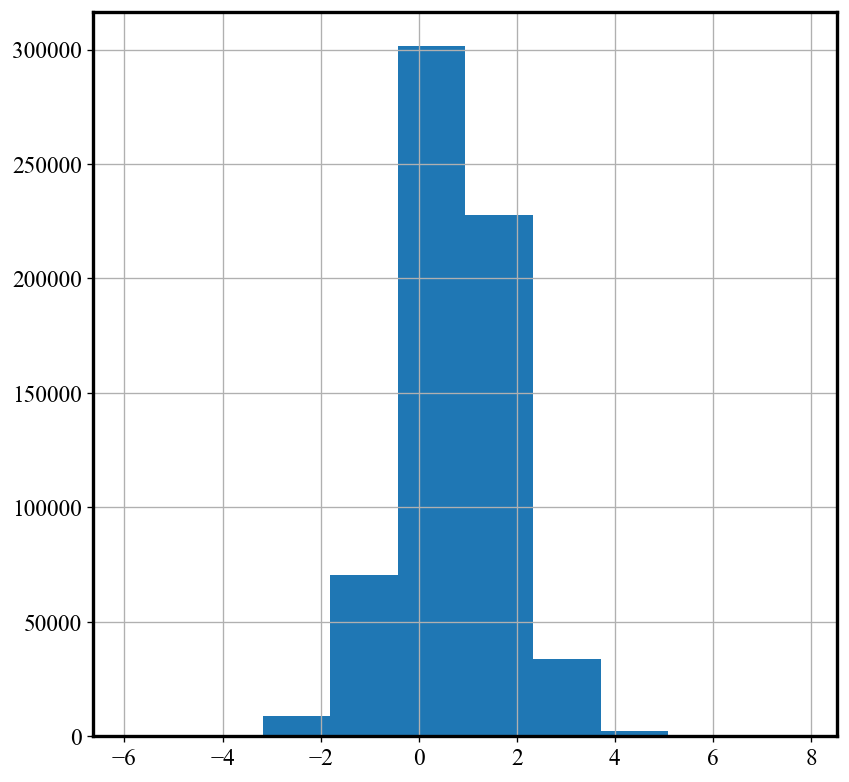

In [8]:
# show histogram of confidence
df_sp500hl.Sent_conf_abs.hist()

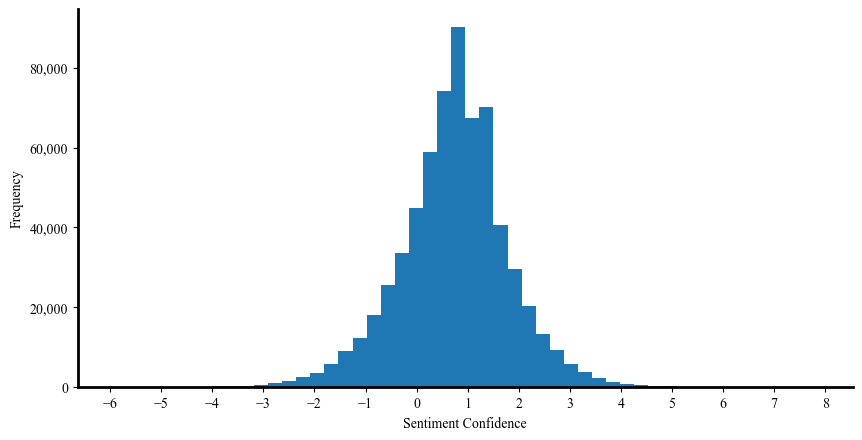

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':100})

fig, ax = plt.subplots()


# Hide the top and right spines of the axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(np.arange(-6,#min(df_sp500hl.Sent_conf_abs), 
                    9,# max(df_sp500hl.Sent_conf_abs)+1
                      1.0))

ax.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Plot Histogram on x
x = df_sp500hl.Sent_conf_abs
plt.hist(x, bins=50)
plt.gca().set(#title='Histogram', 
              ylabel='Frequency',xlabel="Sentiment Confidence")


# store to image
plt.savefig('Hist_sentiment_Real.png',dpi=300, transparent=False, bbox_inches='tight')

In [10]:
# show density curve /distribution of confidence
#df_sp500hl.Sent_conf_abs.plot.kde()

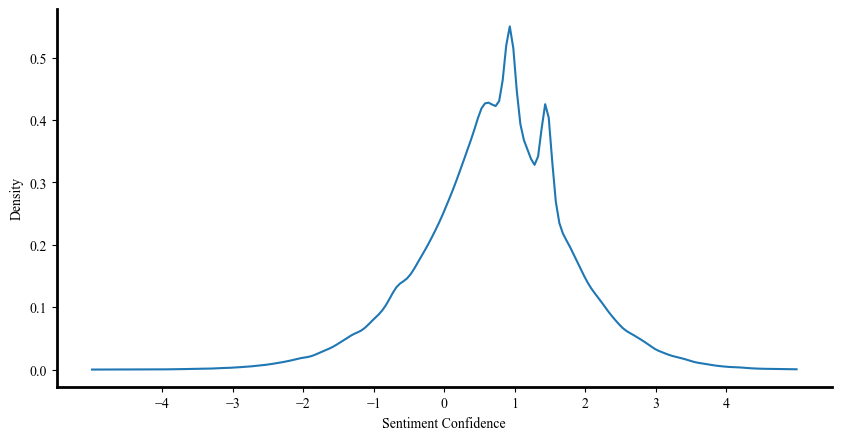

In [11]:
from scipy.stats import gaussian_kde
density = gaussian_kde(df_sp500hl.Sent_conf_abs)
xs = np.linspace(-5,5,200)
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.figure(figsize=(10,5))
plt.plot(xs,density(xs))

# Add the x and y-axis labels
plt.xlabel('Sentiment Confidence')
plt.ylabel('Density')


# Hide the top and right spines of the axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
#ax.xaxis.set_major_locator(loc)
plt.xticks(np.arange(-4,#min(df_sp500hl.Sent_conf_abs), 
                    5,# max(df_sp500hl.Sent_conf_abs)+1
                      1.0))

# store to image
plt.savefig('KDE_plot_sentiment_Real.png',dpi=300, transparent=False, bbox_inches='tight')

# display
plt.show()

In [12]:
# filter out irrelevant news, duplicated news (same score, same company, same day)

### Section 6.2: Transform news sentiment to daily measures of firm specfifc sentiment

In [13]:
# Create one grouped Dataframe 
# (that sums up the accidents for each categorical field)

# Define fields for grouping
group_list= ["Date",
             "RIC"
             ]

# Define components to compute target variable
dict_aggregations= {"Sent_abs": "sum", # = overall sentiment score  
                    "Sent_neg": "sum", # = number of negative news per day 
                    "Sent_pos": "sum",  # = number of positive news per day 
                    "Sent_abs_filt": "sum", # = overall sentiment score filtered 
                    "Sent_neg_filt": "sum", # = number of negative news per day filtered
                    "Sent_pos_filt": "sum",  # = number of positive news per day filtered
                    "Sent_conf_abs": "sum", # = sentiment score based on confidence
                    "Sent_conf_pos": "sum",
                    "Sent_conf_neg": "sum",
                    "Sentiment": "count" # =number of articles published
                   }

# Calculate daily scores for each company / Create aggregated tables
df_sp500_scores = df_sp500hl.groupby(group_list).agg(dict_aggregations).reset_index()
df_sp500_scores.set_index(["Date","RIC"], inplace=True)

# Replace column names for both test and train data
df_sp500_scores.rename(columns = {"Sentiment": "News_vol"}, inplace = True) 

df_sp500_scores.head(30)

Sent_abs  Sent_neg  Sent_pos  Sent_abs_filt  \
Date                      RIC                                                   
2019-03-01 00:00:00+00:00 A              2         0         2              2   
                          AAL.O          0        -4         4             -1   
                          AAPL.O        14        -4        18              6   
                          ABBV.K         6        -1         7              1   
                          ABC            0        -1         1              0   
                          ABT            2         0         2              1   
                          ACN            3         0         3              2   
                          ADBE.O         3         0         3              0   
                          ADM            3         0         3              1   
                          ADP.O          2         0         2              0   
                          ADS            1         0         1              1   
                          ADSK.O         9        -4        13              3   
                          AEP            1         0         1              0   
                          AFL            3         0         3              0   
                          AGN            3        -1         4              2   
                          AIG            1         0         1              1   
                          AIV            0        -1         1              0   
                          AIZ            1         0         1              1   
                          ALK            3         0         3              3   
                          ALL            1         0         1              1   
                          ALXN.O         1         0         1              0   
                          AMD.O          1         0         1              1   
                          AME            1         0         1              1   
                          AMG            0        -1         1              1   
                          AMGN.O         3         0         3              3   
                          AMZN.O        46       -15        61             20   
                          ANSS.O         4         0         4              1   
                          ANTM.K         3         0         3              1   
                          AON            1         0         1              1   
                          AOS            1         0         1              1   

                                  Sent_neg_filt  Sent_pos_filt  Sent_conf_abs  \
Date                      RIC                                                   
2019-03-01 00:00:00+00:00 A                   0              2       4.847166   
                          AAL.O              -3              2      -1.724518   
                          AAPL.O             -1              7      13.352791   
                          ABBV.K              0              1       4.841053   
                          ABC                -1              1       0.816663   
                          ABT                 0              1       2.802164   
                          ACN                 0              2       3.896514   
                          ADBE.O              0              0       1.046264   
                          ADM                 0              1       3.240979   
                          ADP.O               0              0       0.517331   
                          ADS                 0              1       1.176214   
                          ADSK.O             -1              4      10.101201   
                          AEP                 0              0       0.898395   
                          AFL                 0              0       2.320028   
                          AGN                -1              3       2.985714   
                          AIG                 0              1  

In [14]:
# Calculate average sentiment
df_sp500_scores["Sent_avg"]=df_sp500_scores["Sent_abs"]/df_sp500_scores["News_vol"]
df_sp500_scores["Sent_avg_filt"]=df_sp500_scores["Sent_abs_filt"]/df_sp500_scores["News_vol"]
df_sp500_scores["Sent_avg_conf"]=df_sp500_scores["Sent_conf_abs"]/df_sp500_scores["News_vol"]
df_sp500_scores["Sent_avg_conf_neg"]=df_sp500_scores["Sent_conf_neg"]/df_sp500_scores["News_vol"]
df_sp500_scores.head()

Sent_abs  Sent_neg  Sent_pos  Sent_abs_filt  \
Date                      RIC                                                   
2019-03-01 00:00:00+00:00 A              2         0         2              2   
                          AAL.O          0        -4         4             -1   
                          AAPL.O        14        -4        18              6   
                          ABBV.K         6        -1         7              1   
                          ABC            0        -1         1              0   

                                  Sent_neg_filt  Sent_pos_filt  Sent_conf_abs  \
Date                      RIC                                                   
2019-03-01 00:00:00+00:00 A                   0              2       4.847166   
                          AAL.O              -3              2      -1.724518   
                          AAPL.O             -1              7      13.352791   
                          ABBV.K              0              1       4.841053   
                          ABC                -1              1       0.816663   

                                  Sent_conf_pos  Sent_conf_neg  News_vol  \
Date                      RIC                                              
2019-03-01 00:00:00+00:00 A            4.847166       0.000000         2   
                          AAL.O        5.135082      -6.859599         8   
                          AAPL.O      15.933397      -2.580605        22   
                          ABBV.K       5.036389      -0.195336         8   
                          ABC          2.082110      -1.265447         2   

                                  Sent_avg  Sent_avg_filt  Sent_avg_conf  \
Date                      RIC                                              
2019-03-01 00:00:00+00:00 A       1.000000       1.000000       2.423583   
                          AAL.O   0.000000      -0.125000      -0.215565   
                          AAPL.O  0.636364       0.272727       0.606945   
                          ABBV.K  0.750000       0.125000       0.605132   
                          ABC     0.000000       0.000000       0.408332   

                                  Sent_avg_conf_neg  
Date                      RIC                        
2019-03-01 00:00:00+00:00 A                0.000000  
                          AAL.O           -0.857450  
                          AAPL.O          -0.117300  
                          ABBV.K          -0.024417  
                          ABC             -0.632723

In [15]:
# calculate ratios between positive and negative
df_sp500_scores["Sent_ratio"]=np.log((1+df_sp500_scores["Sent_pos"])/(1+df_sp500_scores["Sent_neg"]*-1))
df_sp500_scores["Sent_ratio_filt"]=np.log((1+df_sp500_scores["Sent_pos_filt"])/(1+df_sp500_scores["Sent_neg_filt"]*-1))
df_sp500_scores["Sent_ratio_conf"]=np.log((1+df_sp500_scores["Sent_conf_pos"])/(1+df_sp500_scores["Sent_conf_neg"]*-1))


df_sp500_scores.head()

Sent_abs  Sent_neg  Sent_pos  Sent_abs_filt  \
Date                      RIC                                                   
2019-03-01 00:00:00+00:00 A              2         0         2              2   
                          AAL.O          0        -4         4             -1   
                          AAPL.O        14        -4        18              6   
                          ABBV.K         6        -1         7              1   
                          ABC            0        -1         1              0   

                                  Sent_neg_filt  Sent_pos_filt  Sent_conf_abs  \
Date                      RIC                                                   
2019-03-01 00:00:00+00:00 A                   0              2       4.847166   
                          AAL.O              -3              2      -1.724518   
                          AAPL.O             -1              7      13.352791   
                          ABBV.K              0              1       4.841053   
                          ABC                -1              1       0.816663   

                                  Sent_conf_pos  Sent_conf_neg  News_vol  \
Date                      RIC                                              
2019-03-01 00:00:00+00:00 A            4.847166       0.000000         2   
                          AAL.O        5.135082      -6.859599         8   
                          AAPL.O      15.933397      -2.580605        22   
                          ABBV.K       5.036389      -0.195336         8   
                          ABC          2.082110      -1.265447         2   

                                  Sent_avg  Sent_avg_filt  Sent_avg_conf  \
Date                      RIC                                              
2019-03-01 00:00:00+00:00 A       1.000000       1.000000       2.423583   
                          AAL.O   0.000000      -0.125000      -0.215565   
                          AAPL.O  0.636364       0.272727       0.606945   
                          ABBV.K  0.750000       0.125000       0.605132   
                          ABC     0.000000       0.000000       0.408332   

                                  Sent_avg_conf_neg  Sent_ratio  \
Date                      RIC                                     
2019-03-01 00:00:00+00:00 A                0.000000    1.098612   
                          AAL.O           -0.857450    0.000000   
                          AAPL.O          -0.117300    1.335001   
                          ABBV.K          -0.024417    1.386294   
                          ABC             -0.632723    0.000000   

                                  Sent_ratio_filt  Sent_ratio_conf  
Date                      RIC                                       
2019-03-01 00:00:00+00:00 A              1.098612         1.765957  
                          AAL.O         -0.287682        -0.247712  
                          AAPL.O         1.386294         1.553756  
                          ABBV.K         0.693147         1.619378  
                          ABC            0.000000         0.307843

In [16]:
# create a copy to manipulate / for visualisations
df_sp500_scores_vis=df_sp500_scores.copy()
df_sp500_scores_vis=df_sp500_scores_vis.reset_index()
df_sp500_scores_vis

,Date,RIC,Sent_abs,Sent_neg,Sent_pos,Sent_abs_filt,Sent_neg_filt,Sent_pos_filt,Sent_conf_abs,Sent_conf_pos,Sent_conf_neg,News_vol,Sent_avg,Sent_avg_filt,Sent_avg_conf,Sent_avg_conf_neg,Sent_ratio,Sent_ratio_filt,Sent_ratio_conf
0,2019-03-01 00:00:00+00:00,A,2,0,2,2,0,2,4.847166,4.847166,0.000000,2,1.000000,1.000000,2.423583,0.000000,1.098612,1.098612,1.765957
1,2019-03-01 00:00:00+00:00,AAL.O,0,-4,4,-1,-3,2,-1.724518,5.135082,-6.859599,8,0.000000,-0.125000,-0.215565,-0.857450,0.000000,-0.287682,-0.247712
2,2019-03-01 00:00:00+00:00,AAPL.O,14,-4,18,6,-1,7,13.352791,15.933397,-2.580605,22,0.636364,0.272727,0.606945,-0.117300,1.335001,1.386294,1.553756
3,2019-03-01 00:00:00+00:00,ABBV.K,6,-1,7,1,0,1,4.841053,5.036389,-0.195336,8,0.750000,0.125000,0.605132,-0.024417,1.386294,0.693147,1.619378
4,2019-03-01 00:00:00+00:00,ABC,0,-1,1,0,-1,1,0.816663,2.082110,-1.265447,2,0.000000,0.000000,0.408332,-0.632723,0.000000,0.000000,0.307843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118649,2020-06-29 00:00:00+00:00,YUM,1,0,1,1,0,1,1.356275,1.356275,0.000000,1,1.000000,1.000000,1.356275,0.000000,0.693147,0.693147,0.857082
118650,2020-06-29 00:00:00+00:00,ZBH,2,0,2,0,0,0,0.709361,0.709361,0.000000,2,1.000000,0.000000,0.354680,0.000000,1.098612,0.000000,0.536119
118651,2020-06-29 00:00:00+00:00,ZBRA.O,1,0,1,1,0,1,1.133277,1.133277,0.000000,1,1.000000,1.000000,1.133277,0.000000,0.693147,0.693147,0.757659
118652,2020-06-29 00:00:00+00:00,ZION.O,-1,-1,0,0,0,0,-0.190981,0.000000,-0.190981,1,-1.000000,0.000000,-0.190981,-0.190981,-0.693147,0.000000,-0.174777


In [17]:
df_sp500_scores_vis.to_csv("../01_Data/10_Modelling/32_word2vec_Sentiment Analysis_Semeval__Headlines for visualisations.csv")

### Transform data to format needed for regression

In [18]:
# Unstack table
df_sp500_scores=df_sp500_scores.unstack()
df_sp500_scores

Sent_abs                                            \
RIC                              A AAL.O  AAP AAPL.O ABBV.K  ABC ABMD.O  ABT   
Date                                                                           
2019-03-01 00:00:00+00:00      2.0   0.0  NaN   14.0    6.0  0.0    NaN  2.0   
2019-03-04 00:00:00+00:00      3.0   0.0  1.0    8.0    7.0  2.0    NaN  2.0   
2019-03-05 00:00:00+00:00     -1.0   3.0 -1.0   13.0    1.0  2.0    NaN  3.0   
2019-03-06 00:00:00+00:00      1.0   2.0  1.0   17.0    5.0  NaN    NaN  3.0   
2019-03-07 00:00:00+00:00      3.0   8.0  NaN   12.0    5.0  1.0   -1.0 -1.0   
...                            ...   ...  ...    ...    ...  ...    ...  ...   
2020-06-24 00:00:00+00:00      1.0   4.0  0.0   18.0    2.0  1.0    NaN  3.0   
2020-06-25 00:00:00+00:00      2.0  14.0  NaN   16.0    9.0  NaN    NaN  0.0   
2020-06-26 00:00:00+00:00      2.0  11.0  0.0    0.0   19.0  1.0    NaN  3.0   
2020-06-29 00:00:00+00:00      2.0   6.0  NaN   14.0    3.0  0.0    NaN  3.0   
2020-06-30 00:00:00+00:00      NaN   NaN  NaN    NaN    NaN  NaN    NaN  NaN   

                                        ... Sent_ratio_conf            \
RIC                         ACN ADBE.O  ...          XLNX.O       XOM   
Date                                    ...                             
2019-03-01 00:00:00+00:00   3.0    3.0  ...       -0.640934  2.727331   
2019-03-04 00:00:00+00:00   3.0    NaN  ...        1.696068  0.249031   
2019-03-05 00:00:00+00:00  10.0    NaN  ...        1.043720  0.927248   
2019-03-06 00:00:00+00:00   3.0    NaN  ...             NaN  0.983294   
2019-03-07 00:00:00+00:00   3.0    NaN  ...             NaN  2.351413   
...                         ...    ...  ...             ...       ...   
2020-06-24 00:00:00+00:00   6.0    2.0  ...        1.464297  0.526455   
2020-06-25 00:00:00+00:00  28.0    NaN  ...             NaN -1.975135   
2020-06-26 00:00:00+00:00   8.0    1.0  ...        0.766251  0.099969   
2020-06-29 00:00:00+00:00   4.0    NaN  ...        2.264833  0.934082   
2020-06-30 00:00:00+00:00   NaN    NaN  ...             NaN       NaN   

                                                                             \
RIC                          XRAY.O       XRX       XYL       YUM       ZBH   
Date                                                                          
2019-03-01 00:00:00+00:00  2.282791  1.132055       NaN  0.870563 -1.175748   
2019-03-04 00:00:00+00:00  1.397488  1.868284       NaN  1.614306  1.251462   
2019-03-05 00:00:00+00:00       NaN -0.059798  2.101211  0.850649  1.178240   
2019-03-06 00:00:00+00:00       NaN  1.226063       NaN  1.490351       NaN   
2019-03-07 00:00:00+00:00       NaN  1.448943       NaN  0.052255  1.376796   
...                             ...       ...       ...       ...       ...   
2020-06-24 00:00:00+00:00  1.471644  1.058848  2.589430 -0.063438       NaN   
2020-06-25 00:00:00+00:00  0.211073  2.431602       NaN  2.108513  0.896315   
2020-06-26 00:00:00+00:00       NaN  2.355521  0.732647       NaN  0.658722   
2020-06-29 00:00:00+00:00       NaN  0.940556  2.511970  0.857082  0.536119   
2020-06-30 00:00:00+00:00       NaN       NaN       NaN       NaN       NaN   

                                                         
RIC                          ZBRA.O    ZION.O       ZTS  
Date                                                     
2019-03-01 00:00:00+00:00       NaN       NaN       NaN  
2019-03-04 00:00:00+00:00       NaN       NaN  2.084193  
2019-03-05 00:00:00+00:00       NaN  0.797170  0.615628  
2019-03-06 00:00:00+00:00       NaN       NaN       NaN  
2019-03-07 00:00:00+00:00       NaN  0.872693  0.658722  
...                             ...       ...       ...  
2020-06-24 00:00:00+00:00  1.113530       NaN       NaN  
2020-06-25 00:00:00+00:00  0.852498  1.793076       NaN  
2020-06-26 00:00:00+00:00  1.130651       NaN  0.015858  
2020-06-29 00:00:00+00:00  0.757659 -0.174777       NaN  
2020-06-30 00:00:00+0

In [19]:
df_sp500_scores

Sent_abs                                            \
RIC                              A AAL.O  AAP AAPL.O ABBV.K  ABC ABMD.O  ABT   
Date                                                                           
2019-03-01 00:00:00+00:00      2.0   0.0  NaN   14.0    6.0  0.0    NaN  2.0   
2019-03-04 00:00:00+00:00      3.0   0.0  1.0    8.0    7.0  2.0    NaN  2.0   
2019-03-05 00:00:00+00:00     -1.0   3.0 -1.0   13.0    1.0  2.0    NaN  3.0   
2019-03-06 00:00:00+00:00      1.0   2.0  1.0   17.0    5.0  NaN    NaN  3.0   
2019-03-07 00:00:00+00:00      3.0   8.0  NaN   12.0    5.0  1.0   -1.0 -1.0   
...                            ...   ...  ...    ...    ...  ...    ...  ...   
2020-06-24 00:00:00+00:00      1.0   4.0  0.0   18.0    2.0  1.0    NaN  3.0   
2020-06-25 00:00:00+00:00      2.0  14.0  NaN   16.0    9.0  NaN    NaN  0.0   
2020-06-26 00:00:00+00:00      2.0  11.0  0.0    0.0   19.0  1.0    NaN  3.0   
2020-06-29 00:00:00+00:00      2.0   6.0  NaN   14.0    3.0  0.0    NaN  3.0   
2020-06-30 00:00:00+00:00      NaN   NaN  NaN    NaN    NaN  NaN    NaN  NaN   

                                        ... Sent_ratio_conf            \
RIC                         ACN ADBE.O  ...          XLNX.O       XOM   
Date                                    ...                             
2019-03-01 00:00:00+00:00   3.0    3.0  ...       -0.640934  2.727331   
2019-03-04 00:00:00+00:00   3.0    NaN  ...        1.696068  0.249031   
2019-03-05 00:00:00+00:00  10.0    NaN  ...        1.043720  0.927248   
2019-03-06 00:00:00+00:00   3.0    NaN  ...             NaN  0.983294   
2019-03-07 00:00:00+00:00   3.0    NaN  ...             NaN  2.351413   
...                         ...    ...  ...             ...       ...   
2020-06-24 00:00:00+00:00   6.0    2.0  ...        1.464297  0.526455   
2020-06-25 00:00:00+00:00  28.0    NaN  ...             NaN -1.975135   
2020-06-26 00:00:00+00:00   8.0    1.0  ...        0.766251  0.099969   
2020-06-29 00:00:00+00:00   4.0    NaN  ...        2.264833  0.934082   
2020-06-30 00:00:00+00:00   NaN    NaN  ...             NaN       NaN   

                                                                             \
RIC                          XRAY.O       XRX       XYL       YUM       ZBH   
Date                                                                          
2019-03-01 00:00:00+00:00  2.282791  1.132055       NaN  0.870563 -1.175748   
2019-03-04 00:00:00+00:00  1.397488  1.868284       NaN  1.614306  1.251462   
2019-03-05 00:00:00+00:00       NaN -0.059798  2.101211  0.850649  1.178240   
2019-03-06 00:00:00+00:00       NaN  1.226063       NaN  1.490351       NaN   
2019-03-07 00:00:00+00:00       NaN  1.448943       NaN  0.052255  1.376796   
...                             ...       ...       ...       ...       ...   
2020-06-24 00:00:00+00:00  1.471644  1.058848  2.589430 -0.063438       NaN   
2020-06-25 00:00:00+00:00  0.211073  2.431602       NaN  2.108513  0.896315   
2020-06-26 00:00:00+00:00       NaN  2.355521  0.732647       NaN  0.658722   
2020-06-29 00:00:00+00:00       NaN  0.940556  2.511970  0.857082  0.536119   
2020-06-30 00:00:00+00:00       NaN       NaN       NaN       NaN       NaN   

                                                         
RIC                          ZBRA.O    ZION.O       ZTS  
Date                                                     
2019-03-01 00:00:00+00:00       NaN       NaN       NaN  
2019-03-04 00:00:00+00:00       NaN       NaN  2.084193  
2019-03-05 00:00:00+00:00       NaN  0.797170  0.615628  
2019-03-06 00:00:00+00:00       NaN       NaN       NaN  
2019-03-07 00:00:00+00:00       NaN  0.872693  0.658722  
...                             ...       ...       ...  
2020-06-24 00:00:00+00:00  1.113530       NaN       NaN  
2020-06-25 00:00:00+00:00  0.852498  1.793076       NaN  
2020-06-26 00:00:00+00:00  1.130651       NaN  0.015858  
2020-06-29 00:00:00+00:00  0.757659 -0.174777       NaN  
2020-06-30 00:00:00+0

In [20]:
# Reduce multi index to single column index
level_one = df_sp500_scores.columns.get_level_values(0).astype(str)
level_two = df_sp500_scores.columns.get_level_values(1).astype(str)
df_sp500_scores.columns = level_one+"_" + level_two 
df_sp500_scores

,Sent_abs_A,Sent_abs_AAL.O,Sent_abs_AAP,Sent_abs_AAPL.O,Sent_abs_ABBV.K,Sent_abs_ABC,Sent_abs_ABMD.O,Sent_abs_ABT,Sent_abs_ACN,Sent_abs_ADBE.O,...,Sent_ratio_conf_XLNX.O,Sent_ratio_conf_XOM,Sent_ratio_conf_XRAY.O,Sent_ratio_conf_XRX,Sent_ratio_conf_XYL,Sent_ratio_conf_YUM,Sent_ratio_conf_ZBH,Sent_ratio_conf_ZBRA.O,Sent_ratio_conf_ZION.O,Sent_ratio_conf_ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-01 00:00:00+00:00,2.0,0.0,NaN,14.0,6.0,0.0,NaN,2.0,3.0,3.0,...,-0.640934,2.727331,2.282791,1.132055,NaN,0.870563,-1.175748,NaN,NaN,NaN
2019-03-04 00:00:00+00:00,3.0,0.0,1.0,8.0,7.0,2.0,NaN,2.0,3.0,NaN,...,1.696068,0.249031,1.397488,1.868284,NaN,1.614306,1.251462,NaN,NaN,2.084193
2019-03-05 00:00:00+00:00,-1.0,3.0,-1.0,13.0,1.0,2.0,NaN,3.0,10.0,NaN,...,1.043720,0.927248,NaN,-0.059798,2.101211,0.850649,1.178240,NaN,0.797170,0.615628
2019-03-06 00:00:00+00:00,1.0,2.0,1.0,17.0,5.0,NaN,NaN,3.0,3.0,NaN,...,NaN,0.983294,NaN,1.226063,NaN,1.490351,NaN,NaN,NaN,NaN
2019-03-07 00:00:00+00:00,3.0,8.0,NaN,12.0,5.0,1.0,-1.0,-1.0,3.0,NaN,...,NaN,2.351413,NaN,1.448943,NaN,0.052255,1.376796,NaN,0.872693,0.658722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24 00:00:00+00:00,1.0,4.0,0.0,18.0,2.0,1.0,NaN,3.0,6.0,2.0,...,1.464297,0.526455,1.471644,1.058848,2.589430,-0.063438,NaN,1.113530,NaN,NaN
2020-06-25 00:00:00+00:00,2.0,14.0,NaN,16.0,9.0,NaN,NaN,0.0,28.0,NaN,...,NaN,-1.975135,0.211073,2.431602,NaN,2.108513,0.896315,0.852498,1.793076,NaN
2020-06-26 00:00:00+00:00,2.0,11.0,0.0,0.0,19.0,1.0,NaN,3.0,8.0,1.0,...,0.766251,0.099969,NaN,2.355521,0.732647,NaN,0.658722,1.130651,NaN,0.015858


In [23]:
# Convert index to datetime
df_sp500_scores.index= pd.to_datetime(df_sp500_scores.index).date
df_sp500_scores

,Sent_abs_A,Sent_abs_AAL.O,Sent_abs_AAP,Sent_abs_AAPL.O,Sent_abs_ABBV.K,Sent_abs_ABC,Sent_abs_ABMD.O,Sent_abs_ABT,Sent_abs_ACN,Sent_abs_ADBE.O,...,Sent_ratio_conf_XLNX.O,Sent_ratio_conf_XOM,Sent_ratio_conf_XRAY.O,Sent_ratio_conf_XRX,Sent_ratio_conf_XYL,Sent_ratio_conf_YUM,Sent_ratio_conf_ZBH,Sent_ratio_conf_ZBRA.O,Sent_ratio_conf_ZION.O,Sent_ratio_conf_ZTS
2019-03-01,2.0,0.0,NaN,14.0,6.0,0.0,NaN,2.0,3.0,3.0,...,-0.640934,2.727331,2.282791,1.132055,NaN,0.870563,-1.175748,NaN,NaN,NaN
2019-03-04,3.0,0.0,1.0,8.0,7.0,2.0,NaN,2.0,3.0,NaN,...,1.696068,0.249031,1.397488,1.868284,NaN,1.614306,1.251462,NaN,NaN,2.084193
2019-03-05,-1.0,3.0,-1.0,13.0,1.0,2.0,NaN,3.0,10.0,NaN,...,1.043720,0.927248,NaN,-0.059798,2.101211,0.850649,1.178240,NaN,0.797170,0.615628
2019-03-06,1.0,2.0,1.0,17.0,5.0,NaN,NaN,3.0,3.0,NaN,...,NaN,0.983294,NaN,1.226063,NaN,1.490351,NaN,NaN,NaN,NaN
2019-03-07,3.0,8.0,NaN,12.0,5.0,1.0,-1.0,-1.0,3.0,NaN,...,NaN,2.351413,NaN,1.448943,NaN,0.052255,1.376796,NaN,0.872693,0.658722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24,1.0,4.0,0.0,18.0,2.0,1.0,NaN,3.0,6.0,2.0,...,1.464297,0.526455,1.471644,1.058848,2.589430,-0.063438,NaN,1.113530,NaN,NaN
2020-06-25,2.0,14.0,NaN,16.0,9.0,NaN,NaN,0.0,28.0,NaN,...,NaN,-1.975135,0.211073,2.431602,NaN,2.108513,0.896315,0.852498,1.793076,NaN
2020-06-26,2.0,11.0,0.0,0.0,19.0,1.0,NaN,3.0,8.0,1.0,...,0.766251,0.099969,NaN,2.355521,0.732647,NaN,0.658722,1.130651,NaN,0.015858
2020-06-29,2.0,6.0,NaN,14.0,3.0,0.0,NaN,3.0,4.0,NaN,...,2.264833,0.934082,NaN,0.940556,2.511970,0.857082,0.536119,0.757659,-0.174777,NaN


In [24]:
# Reset index so that date becomes a column again
df_sp500_scores.reset_index()
df_sp500_scores.rename(columns =  {"index": "Date"}, inplace = True)
df_sp500_scores

,Sent_abs_A,Sent_abs_AAL.O,Sent_abs_AAP,Sent_abs_AAPL.O,Sent_abs_ABBV.K,Sent_abs_ABC,Sent_abs_ABMD.O,Sent_abs_ABT,Sent_abs_ACN,Sent_abs_ADBE.O,...,Sent_ratio_conf_XLNX.O,Sent_ratio_conf_XOM,Sent_ratio_conf_XRAY.O,Sent_ratio_conf_XRX,Sent_ratio_conf_XYL,Sent_ratio_conf_YUM,Sent_ratio_conf_ZBH,Sent_ratio_conf_ZBRA.O,Sent_ratio_conf_ZION.O,Sent_ratio_conf_ZTS
2019-03-01,2.0,0.0,NaN,14.0,6.0,0.0,NaN,2.0,3.0,3.0,...,-0.640934,2.727331,2.282791,1.132055,NaN,0.870563,-1.175748,NaN,NaN,NaN
2019-03-04,3.0,0.0,1.0,8.0,7.0,2.0,NaN,2.0,3.0,NaN,...,1.696068,0.249031,1.397488,1.868284,NaN,1.614306,1.251462,NaN,NaN,2.084193
2019-03-05,-1.0,3.0,-1.0,13.0,1.0,2.0,NaN,3.0,10.0,NaN,...,1.043720,0.927248,NaN,-0.059798,2.101211,0.850649,1.178240,NaN,0.797170,0.615628
2019-03-06,1.0,2.0,1.0,17.0,5.0,NaN,NaN,3.0,3.0,NaN,...,NaN,0.983294,NaN,1.226063,NaN,1.490351,NaN,NaN,NaN,NaN
2019-03-07,3.0,8.0,NaN,12.0,5.0,1.0,-1.0,-1.0,3.0,NaN,...,NaN,2.351413,NaN,1.448943,NaN,0.052255,1.376796,NaN,0.872693,0.658722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24,1.0,4.0,0.0,18.0,2.0,1.0,NaN,3.0,6.0,2.0,...,1.464297,0.526455,1.471644,1.058848,2.589430,-0.063438,NaN,1.113530,NaN,NaN
2020-06-25,2.0,14.0,NaN,16.0,9.0,NaN,NaN,0.0,28.0,NaN,...,NaN,-1.975135,0.211073,2.431602,NaN,2.108513,0.896315,0.852498,1.793076,NaN
2020-06-26,2.0,11.0,0.0,0.0,19.0,1.0,NaN,3.0,8.0,1.0,...,0.766251,0.099969,NaN,2.355521,0.732647,NaN,0.658722,1.130651,NaN,0.015858
2020-06-29,2.0,6.0,NaN,14.0,3.0,0.0,NaN,3.0,4.0,NaN,...,2.264833,0.934082,NaN,0.940556,2.511970,0.857082,0.536119,0.757659,-0.174777,NaN


In [25]:
df_sp500_scores.index.name = 'Date'
df_sp500_scores

,Sent_abs_A,Sent_abs_AAL.O,Sent_abs_AAP,Sent_abs_AAPL.O,Sent_abs_ABBV.K,Sent_abs_ABC,Sent_abs_ABMD.O,Sent_abs_ABT,Sent_abs_ACN,Sent_abs_ADBE.O,...,Sent_ratio_conf_XLNX.O,Sent_ratio_conf_XOM,Sent_ratio_conf_XRAY.O,Sent_ratio_conf_XRX,Sent_ratio_conf_XYL,Sent_ratio_conf_YUM,Sent_ratio_conf_ZBH,Sent_ratio_conf_ZBRA.O,Sent_ratio_conf_ZION.O,Sent_ratio_conf_ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-01,2.0,0.0,NaN,14.0,6.0,0.0,NaN,2.0,3.0,3.0,...,-0.640934,2.727331,2.282791,1.132055,NaN,0.870563,-1.175748,NaN,NaN,NaN
2019-03-04,3.0,0.0,1.0,8.0,7.0,2.0,NaN,2.0,3.0,NaN,...,1.696068,0.249031,1.397488,1.868284,NaN,1.614306,1.251462,NaN,NaN,2.084193
2019-03-05,-1.0,3.0,-1.0,13.0,1.0,2.0,NaN,3.0,10.0,NaN,...,1.043720,0.927248,NaN,-0.059798,2.101211,0.850649,1.178240,NaN,0.797170,0.615628
2019-03-06,1.0,2.0,1.0,17.0,5.0,NaN,NaN,3.0,3.0,NaN,...,NaN,0.983294,NaN,1.226063,NaN,1.490351,NaN,NaN,NaN,NaN
2019-03-07,3.0,8.0,NaN,12.0,5.0,1.0,-1.0,-1.0,3.0,NaN,...,NaN,2.351413,NaN,1.448943,NaN,0.052255,1.376796,NaN,0.872693,0.658722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24,1.0,4.0,0.0,18.0,2.0,1.0,NaN,3.0,6.0,2.0,...,1.464297,0.526455,1.471644,1.058848,2.589430,-0.063438,NaN,1.113530,NaN,NaN
2020-06-25,2.0,14.0,NaN,16.0,9.0,NaN,NaN,0.0,28.0,NaN,...,NaN,-1.975135,0.211073,2.431602,NaN,2.108513,0.896315,0.852498,1.793076,NaN
2020-06-26,2.0,11.0,0.0,0.0,19.0,1.0,NaN,3.0,8.0,1.0,...,0.766251,0.099969,NaN,2.355521,0.732647,NaN,0.658722,1.130651,NaN,0.015858


In [26]:
# store to excel 
df_sp500_scores.to_excel("../01_Data/10_Modelling/32_word2vec_Sentiment Analysis_Semeval_Daily_firm_specific_sentiment_scores.xlsx")

### Create Visualisation and descriptive statistics

In [3]:
import matplotlib as mpl

# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2

mpl.rcParams['figure.figsize'] = [8.0, 8.0]
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['savefig.dpi'] = 120

In [4]:
df_sp500_scores_vis=pd.read_csv("../01_Data/10_Modelling/32_word2vec_Sentiment Analysis_Semeval__Headlines for visualisations.csv", index_col="Unnamed: 0")
df_sp500_scores_vis

,Date,RIC,Sent_abs,Sent_neg,Sent_pos,Sent_abs_filt,Sent_neg_filt,Sent_pos_filt,Sent_conf_abs,Sent_conf_pos,Sent_conf_neg,News_vol,Sent_avg,Sent_avg_filt,Sent_avg_conf,Sent_avg_conf_neg,Sent_ratio,Sent_ratio_filt,Sent_ratio_conf
0,2019-03-01 00:00:00+00:00,A,2,0,2,2,0,2,4.847166,4.847166,0.000000,2,1.000000,1.000000,2.423583,0.000000,1.098612,1.098612,1.765957
1,2019-03-01 00:00:00+00:00,AAL.O,0,-4,4,-1,-3,2,-1.724518,5.135082,-6.859599,8,0.000000,-0.125000,-0.215565,-0.857450,0.000000,-0.287682,-0.247712
2,2019-03-01 00:00:00+00:00,AAPL.O,14,-4,18,6,-1,7,13.352791,15.933397,-2.580605,22,0.636364,0.272727,0.606945,-0.117300,1.335001,1.386294,1.553756
3,2019-03-01 00:00:00+00:00,ABBV.K,6,-1,7,1,0,1,4.841053,5.036389,-0.195336,8,0.750000,0.125000,0.605132,-0.024417,1.386294,0.693147,1.619378
4,2019-03-01 00:00:00+00:00,ABC,0,-1,1,0,-1,1,0.816663,2.082110,-1.265447,2,0.000000,0.000000,0.408332,-0.632723,0.000000,0.000000,0.307843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118649,2020-06-29 00:00:00+00:00,YUM,1,0,1,1,0,1,1.356275,1.356275,0.000000,1,1.000000,1.000000,1.356275,0.000000,0.693147,0.693147,0.857082
118650,2020-06-29 00:00:00+00:00,ZBH,2,0,2,0,0,0,0.709361,0.709361,0.000000,2,1.000000,0.000000,0.354680,0.000000,1.098612,0.000000,0.536119
118651,2020-06-29 00:00:00+00:00,ZBRA.O,1,0,1,1,0,1,1.133277,1.133277,0.000000,1,1.000000,1.000000,1.133277,0.000000,0.693147,0.693147,0.757659
118652,2020-06-29 00:00:00+00:00,ZION.O,-1,-1,0,0,0,0,-0.190981,0.000000,-0.190981,1,-1.000000,0.000000,-0.190981,-0.190981,-0.693147,0.000000,-0.174777


In [5]:
#Filter out Moodys
df_sp500_scores_vis = df_sp500_scores_vis[df_sp500_scores_vis.RIC!="MCO"]

In [6]:
df_sp500_scores_vis

,Date,RIC,Sent_abs,Sent_neg,Sent_pos,Sent_abs_filt,Sent_neg_filt,Sent_pos_filt,Sent_conf_abs,Sent_conf_pos,Sent_conf_neg,News_vol,Sent_avg,Sent_avg_filt,Sent_avg_conf,Sent_avg_conf_neg,Sent_ratio,Sent_ratio_filt,Sent_ratio_conf
0,2019-03-01 00:00:00+00:00,A,2,0,2,2,0,2,4.847166,4.847166,0.000000,2,1.000000,1.000000,2.423583,0.000000,1.098612,1.098612,1.765957
1,2019-03-01 00:00:00+00:00,AAL.O,0,-4,4,-1,-3,2,-1.724518,5.135082,-6.859599,8,0.000000,-0.125000,-0.215565,-0.857450,0.000000,-0.287682,-0.247712
2,2019-03-01 00:00:00+00:00,AAPL.O,14,-4,18,6,-1,7,13.352791,15.933397,-2.580605,22,0.636364,0.272727,0.606945,-0.117300,1.335001,1.386294,1.553756
3,2019-03-01 00:00:00+00:00,ABBV.K,6,-1,7,1,0,1,4.841053,5.036389,-0.195336,8,0.750000,0.125000,0.605132,-0.024417,1.386294,0.693147,1.619378
4,2019-03-01 00:00:00+00:00,ABC,0,-1,1,0,-1,1,0.816663,2.082110,-1.265447,2,0.000000,0.000000,0.408332,-0.632723,0.000000,0.000000,0.307843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118649,2020-06-29 00:00:00+00:00,YUM,1,0,1,1,0,1,1.356275,1.356275,0.000000,1,1.000000,1.000000,1.356275,0.000000,0.693147,0.693147,0.857082
118650,2020-06-29 00:00:00+00:00,ZBH,2,0,2,0,0,0,0.709361,0.709361,0.000000,2,1.000000,0.000000,0.354680,0.000000,1.098612,0.000000,0.536119
118651,2020-06-29 00:00:00+00:00,ZBRA.O,1,0,1,1,0,1,1.133277,1.133277,0.000000,1,1.000000,1.000000,1.133277,0.000000,0.693147,0.693147,0.757659
118652,2020-06-29 00:00:00+00:00,ZION.O,-1,-1,0,0,0,0,-0.190981,0.000000,-0.190981,1,-1.000000,0.000000,-0.190981,-0.190981,-0.693147,0.000000,-0.174777


In [7]:
# sort by date
df_sp500_scores_vis=df_sp500_scores_vis.sort_values(by="Date")
df_sp500_scores_vis

,Date,RIC,Sent_abs,Sent_neg,Sent_pos,Sent_abs_filt,Sent_neg_filt,Sent_pos_filt,Sent_conf_abs,Sent_conf_pos,Sent_conf_neg,News_vol,Sent_avg,Sent_avg_filt,Sent_avg_conf,Sent_avg_conf_neg,Sent_ratio,Sent_ratio_filt,Sent_ratio_conf
0,2019-03-01 00:00:00+00:00,A,2,0,2,2,0,2,4.847166,4.847166,0.000000,2,1.000000,1.000000,2.423583,0.000000,1.098612,1.098612,1.765957
237,2019-03-01 00:00:00+00:00,NRG,3,0,3,3,0,3,3.420256,3.420256,0.000000,3,1.000000,1.000000,1.140085,0.000000,1.386294,1.386294,1.486198
236,2019-03-01 00:00:00+00:00,NOV,1,0,1,1,0,1,2.655401,2.655401,0.000000,1,1.000000,1.000000,2.655401,0.000000,0.693147,0.693147,1.296206
235,2019-03-01 00:00:00+00:00,NOC,1,0,1,0,0,0,0.926428,0.926428,0.000000,1,1.000000,0.000000,0.926428,0.000000,0.693147,0.000000,0.655667
234,2019-03-01 00:00:00+00:00,NLSN.K,1,-1,2,1,0,1,1.757204,2.301808,-0.544604,3,0.333333,0.333333,0.585735,-0.181535,0.405465,0.693147,0.759702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118438,2020-06-29 00:00:00+00:00,EQR,2,0,2,1,0,1,2.136208,2.136208,0.000000,2,1.000000,0.500000,1.068104,0.000000,1.098612,0.693147,1.143015
118437,2020-06-29 00:00:00+00:00,EOG,3,0,3,2,0,2,3.311120,3.311120,0.000000,3,1.000000,0.666667,1.103707,0.000000,1.386294,1.098612,1.461198
118436,2020-06-29 00:00:00+00:00,EL,1,-1,2,1,-1,2,0.060732,2.173658,-2.112925,3,0.333333,0.333333,0.020244,-0.704308,0.405465,0.405465,0.019322
118443,2020-06-29 00:00:00+00:00,EXPE.O,2,0,2,0,0,0,0.626432,0.626432,0.000000,2,1.000000,0.000000,0.313216,0.000000,1.098612,0.000000,0.486389


In [8]:
# Show data for Apple
#df_sp500_scores_vis[df_sp500_scores_vis.RIC=="AAPL.O"]

### Calculate average sentiment by company

In [9]:
# Calculate average sentiment by company
df_comp_avg_sent=pd.pivot_table(df_sp500_scores_vis,index=["RIC"],\
               #values=["Sent_conf_neg"],\
               aggfunc=(np.mean, min, max,sum),fill_value=np.NaN)
df_comp_avg_sent.head()

News_vol                       Sent_abs                       \
            max       mean min    sum      max       mean min   sum   
RIC                                                                   
A            20   3.084871   1    836       16   2.206642  -3   598   
AAL.O        79  10.344828   1   3300       44   4.721003  -6  1506   
AAP          27   2.929078   1    413       19   1.879433  -2   265   
AAPL.O      237  40.424779   6  13704      173  23.221239  -3  7872   
ABBV.K      109   7.239394   1   2389       85   5.081818  -2  1677   

       Sent_abs_filt             ... Sent_ratio             Sent_ratio_conf  \
                 max       mean  ...        min         sum             max   
RIC                              ...                                          
A                 14   1.793358  ...  -1.386294  231.520661        3.313709   
AAL.O             24   2.338558  ...  -1.386294  242.352534        3.031083   
AAP               16   1.085106  ...  -1.098612   86.095999        2.506823   
AAPL.O           102  13.271386  ...  -0.182322  424.351064        4.182546   
ABBV.K            38   2.569697  ...  -1.098612  391.657803        3.249914   

                                       Sent_ratio_filt                      \
            mean       min         sum             max      mean       min   
RIC                                                                          
A       1.126720 -1.062498  305.341215        2.708050  0.792107 -0.693147   
AAL.O   0.935462 -1.531113  298.412523        2.564949  0.726880 -1.609438   
AAP     0.685271 -1.261724   96.623267        2.833213  0.430061 -0.693147   
AAPL.O  1.658818 -0.430762  562.339334        3.526361  1.669318 -0.693147   
ABBV.K  1.356987 -0.871230  447.805596        3.091042  0.918717 -1.098612   

                    
               sum  
RIC                 
A       214.660998  
AAL.O   231.874713  
AAP      60.638620  
AAPL.O  565.898652  
ABBV.K  303.176701  

[5 rows x 68 columns]

In [10]:
# store in excel
df_comp_avg_sent.to_excel("../01_Data/10_Modelling/32_word2vec_Sentiment Analysis_Semeval_Headlines AVG Sentiment by company.xlsx")

### Plot weekly average sentiment overall

In [11]:
df_sp500_scores_vis.columns

Index(['Date', 'RIC', 'Sent_abs', 'Sent_neg', 'Sent_pos', 'Sent_abs_filt',
       'Sent_neg_filt', 'Sent_pos_filt', 'Sent_conf_abs', 'Sent_conf_pos',
       'Sent_conf_neg', 'News_vol', 'Sent_avg', 'Sent_avg_filt',
       'Sent_avg_conf', 'Sent_avg_conf_neg', 'Sent_ratio', 'Sent_ratio_filt',
       'Sent_ratio_conf'],
      dtype='object')

In [12]:
df_sp500_scores_vis

,Date,RIC,Sent_abs,Sent_neg,Sent_pos,Sent_abs_filt,Sent_neg_filt,Sent_pos_filt,Sent_conf_abs,Sent_conf_pos,Sent_conf_neg,News_vol,Sent_avg,Sent_avg_filt,Sent_avg_conf,Sent_avg_conf_neg,Sent_ratio,Sent_ratio_filt,Sent_ratio_conf
0,2019-03-01 00:00:00+00:00,A,2,0,2,2,0,2,4.847166,4.847166,0.000000,2,1.000000,1.000000,2.423583,0.000000,1.098612,1.098612,1.765957
237,2019-03-01 00:00:00+00:00,NRG,3,0,3,3,0,3,3.420256,3.420256,0.000000,3,1.000000,1.000000,1.140085,0.000000,1.386294,1.386294,1.486198
236,2019-03-01 00:00:00+00:00,NOV,1,0,1,1,0,1,2.655401,2.655401,0.000000,1,1.000000,1.000000,2.655401,0.000000,0.693147,0.693147,1.296206
235,2019-03-01 00:00:00+00:00,NOC,1,0,1,0,0,0,0.926428,0.926428,0.000000,1,1.000000,0.000000,0.926428,0.000000,0.693147,0.000000,0.655667
234,2019-03-01 00:00:00+00:00,NLSN.K,1,-1,2,1,0,1,1.757204,2.301808,-0.544604,3,0.333333,0.333333,0.585735,-0.181535,0.405465,0.693147,0.759702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118438,2020-06-29 00:00:00+00:00,EQR,2,0,2,1,0,1,2.136208,2.136208,0.000000,2,1.000000,0.500000,1.068104,0.000000,1.098612,0.693147,1.143015
118437,2020-06-29 00:00:00+00:00,EOG,3,0,3,2,0,2,3.311120,3.311120,0.000000,3,1.000000,0.666667,1.103707,0.000000,1.386294,1.098612,1.461198
118436,2020-06-29 00:00:00+00:00,EL,1,-1,2,1,-1,2,0.060732,2.173658,-2.112925,3,0.333333,0.333333,0.020244,-0.704308,0.405465,0.405465,0.019322
118443,2020-06-29 00:00:00+00:00,EXPE.O,2,0,2,0,0,0,0.626432,0.626432,0.000000,2,1.000000,0.000000,0.313216,0.000000,1.098612,0.000000,0.486389


In [13]:
df_sp500_scores_vis["Date"]

0         2019-03-01 00:00:00+00:00
237       2019-03-01 00:00:00+00:00
236       2019-03-01 00:00:00+00:00
235       2019-03-01 00:00:00+00:00
234       2019-03-01 00:00:00+00:00
                    ...            
118438    2020-06-29 00:00:00+00:00
118437    2020-06-29 00:00:00+00:00
118436    2020-06-29 00:00:00+00:00
118443    2020-06-29 00:00:00+00:00
118653    2020-06-30 00:00:00+00:00
Name: Date, Length: 118654, dtype: object

In [14]:
df_sp500_scores_vis.dtypes

Date                  object
RIC                   object
Sent_abs               int64
Sent_neg               int64
Sent_pos               int64
Sent_abs_filt          int64
Sent_neg_filt          int64
Sent_pos_filt          int64
Sent_conf_abs        float64
Sent_conf_pos        float64
Sent_conf_neg        float64
News_vol               int64
Sent_avg             float64
Sent_avg_filt        float64
Sent_avg_conf        float64
Sent_avg_conf_neg    float64
Sent_ratio           float64
Sent_ratio_filt      float64
Sent_ratio_conf      float64
dtype: object

In [15]:
df_sp500_scores_vis["Date"]=pd.to_datetime(df_sp500_scores_vis["Date"])

In [16]:
df_sp500_scores_vis.dtypes

Date                 datetime64[ns, UTC]
RIC                               object
Sent_abs                           int64
Sent_neg                           int64
Sent_pos                           int64
Sent_abs_filt                      int64
Sent_neg_filt                      int64
Sent_pos_filt                      int64
Sent_conf_abs                    float64
Sent_conf_pos                    float64
Sent_conf_neg                    float64
News_vol                           int64
Sent_avg                         float64
Sent_avg_filt                    float64
Sent_avg_conf                    float64
Sent_avg_conf_neg                float64
Sent_ratio                       float64
Sent_ratio_filt                  float64
Sent_ratio_conf                  float64
dtype: object

In [17]:
df_sp500_scores_vis['weeknum'] = df_sp500_scores_vis["Date"].apply(lambda x:x.isocalendar()[1])
df_sp500_scores_vis['year'] = df_sp500_scores_vis["Date"].apply(lambda x:x.isocalendar()[0])
df_sp500_scores_vis["Week_display"]=df_sp500_scores_vis['year'].astype(str)+"-"+df_sp500_scores_vis['weeknum'].astype(str)
df_sp500_scores_vis["Week"]=df_sp500_scores_vis['weeknum'].astype(str)
df_sp500_scores_vis

,Date,RIC,Sent_abs,Sent_neg,Sent_pos,Sent_abs_filt,Sent_neg_filt,Sent_pos_filt,Sent_conf_abs,Sent_conf_pos,...,Sent_avg_filt,Sent_avg_conf,Sent_avg_conf_neg,Sent_ratio,Sent_ratio_filt,Sent_ratio_conf,weeknum,year,Week_display,Week
0,2019-03-01 00:00:00+00:00,A,2,0,2,2,0,2,4.847166,4.847166,...,1.000000,2.423583,0.000000,1.098612,1.098612,1.765957,9,2019,2019-9,9
237,2019-03-01 00:00:00+00:00,NRG,3,0,3,3,0,3,3.420256,3.420256,...,1.000000,1.140085,0.000000,1.386294,1.386294,1.486198,9,2019,2019-9,9
236,2019-03-01 00:00:00+00:00,NOV,1,0,1,1,0,1,2.655401,2.655401,...,1.000000,2.655401,0.000000,0.693147,0.693147,1.296206,9,2019,2019-9,9
235,2019-03-01 00:00:00+00:00,NOC,1,0,1,0,0,0,0.926428,0.926428,...,0.000000,0.926428,0.000000,0.693147,0.000000,0.655667,9,2019,2019-9,9
234,2019-03-01 00:00:00+00:00,NLSN.K,1,-1,2,1,0,1,1.757204,2.301808,...,0.333333,0.585735,-0.181535,0.405465,0.693147,0.759702,9,2019,2019-9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118438,2020-06-29 00:00:00+00:00,EQR,2,0,2,1,0,1,2.136208,2.136208,...,0.500000,1.068104,0.000000,1.098612,0.693147,1.143015,27,2020,2020-27,27
118437,2020-06-29 00:00:00+00:00,EOG,3,0,3,2,0,2,3.311120,3.311120,...,0.666667,1.103707,0.000000,1.386294,1.098612,1.461198,27,2020,2020-27,27
118436,2020-06-29 00:00:00+00:00,EL,1,-1,2,1,-1,2,0.060732,2.173658,...,0.333333,0.020244,-0.704308,0.405465,0.405465,0.019322,27,2020,2020-27,27
118443,2020-06-29 00:00:00+00:00,EXPE.O,2,0,2,0,0,0,0.626432,0.626432,...,0.000000,0.313216,0.000000,1.098612,0.000000,0.486389,27,2020,2020-27,27


In [18]:
import datetime

In [19]:
df_sp500_scores_vis['ISO'] = df_sp500_scores_vis['year'].astype(str) + '-W' + df_sp500_scores_vis['Week'].astype(str) + '-1'

# Create column that shows first day of week as "Week"
df_sp500_scores_vis['Week'] = df_sp500_scores_vis['ISO'].map(lambda x: datetime.datetime.strptime(x, "%G-W%V-%u"))
df_sp500_scores_vis

,Date,RIC,Sent_abs,Sent_neg,Sent_pos,Sent_abs_filt,Sent_neg_filt,Sent_pos_filt,Sent_conf_abs,Sent_conf_pos,...,Sent_avg_conf,Sent_avg_conf_neg,Sent_ratio,Sent_ratio_filt,Sent_ratio_conf,weeknum,year,Week_display,Week,ISO
0,2019-03-01 00:00:00+00:00,A,2,0,2,2,0,2,4.847166,4.847166,...,2.423583,0.000000,1.098612,1.098612,1.765957,9,2019,2019-9,2019-02-25,2019-W9-1
237,2019-03-01 00:00:00+00:00,NRG,3,0,3,3,0,3,3.420256,3.420256,...,1.140085,0.000000,1.386294,1.386294,1.486198,9,2019,2019-9,2019-02-25,2019-W9-1
236,2019-03-01 00:00:00+00:00,NOV,1,0,1,1,0,1,2.655401,2.655401,...,2.655401,0.000000,0.693147,0.693147,1.296206,9,2019,2019-9,2019-02-25,2019-W9-1
235,2019-03-01 00:00:00+00:00,NOC,1,0,1,0,0,0,0.926428,0.926428,...,0.926428,0.000000,0.693147,0.000000,0.655667,9,2019,2019-9,2019-02-25,2019-W9-1
234,2019-03-01 00:00:00+00:00,NLSN.K,1,-1,2,1,0,1,1.757204,2.301808,...,0.585735,-0.181535,0.405465,0.693147,0.759702,9,2019,2019-9,2019-02-25,2019-W9-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118438,2020-06-29 00:00:00+00:00,EQR,2,0,2,1,0,1,2.136208,2.136208,...,1.068104,0.000000,1.098612,0.693147,1.143015,27,2020,2020-27,2020-06-29,2020-W27-1
118437,2020-06-29 00:00:00+00:00,EOG,3,0,3,2,0,2,3.311120,3.311120,...,1.103707,0.000000,1.386294,1.098612,1.461198,27,2020,2020-27,2020-06-29,2020-W27-1
118436,2020-06-29 00:00:00+00:00,EL,1,-1,2,1,-1,2,0.060732,2.173658,...,0.020244,-0.704308,0.405465,0.405465,0.019322,27,2020,2020-27,2020-06-29,2020-W27-1
118443,2020-06-29 00:00:00+00:00,EXPE.O,2,0,2,0,0,0,0.626432,0.626432,...,0.313216,0.000000,1.098612,0.000000,0.486389,27,2020,2020-27,2020-06-29,2020-W27-1


In [20]:
#df_sp500_scores_vis["Week"]=df_sp500_scores_vis["Date"].dt.strftime('%Y-%V')
df_sp500_scores_vis["Month"]=df_sp500_scores_vis["Date"].dt.strftime('%Y-%m')
df_sp500_scores_vis.sort_values(by="Week")
df_sp500_scores_vis

,Date,RIC,Sent_abs,Sent_neg,Sent_pos,Sent_abs_filt,Sent_neg_filt,Sent_pos_filt,Sent_conf_abs,Sent_conf_pos,...,Sent_avg_conf_neg,Sent_ratio,Sent_ratio_filt,Sent_ratio_conf,weeknum,year,Week_display,Week,ISO,Month
0,2019-03-01 00:00:00+00:00,A,2,0,2,2,0,2,4.847166,4.847166,...,0.000000,1.098612,1.098612,1.765957,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03
237,2019-03-01 00:00:00+00:00,NRG,3,0,3,3,0,3,3.420256,3.420256,...,0.000000,1.386294,1.386294,1.486198,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03
236,2019-03-01 00:00:00+00:00,NOV,1,0,1,1,0,1,2.655401,2.655401,...,0.000000,0.693147,0.693147,1.296206,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03
235,2019-03-01 00:00:00+00:00,NOC,1,0,1,0,0,0,0.926428,0.926428,...,0.000000,0.693147,0.000000,0.655667,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03
234,2019-03-01 00:00:00+00:00,NLSN.K,1,-1,2,1,0,1,1.757204,2.301808,...,-0.181535,0.405465,0.693147,0.759702,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118438,2020-06-29 00:00:00+00:00,EQR,2,0,2,1,0,1,2.136208,2.136208,...,0.000000,1.098612,0.693147,1.143015,27,2020,2020-27,2020-06-29,2020-W27-1,2020-06
118437,2020-06-29 00:00:00+00:00,EOG,3,0,3,2,0,2,3.311120,3.311120,...,0.000000,1.386294,1.098612,1.461198,27,2020,2020-27,2020-06-29,2020-W27-1,2020-06
118436,2020-06-29 00:00:00+00:00,EL,1,-1,2,1,-1,2,0.060732,2.173658,...,-0.704308,0.405465,0.405465,0.019322,27,2020,2020-27,2020-06-29,2020-W27-1,2020-06
118443,2020-06-29 00:00:00+00:00,EXPE.O,2,0,2,0,0,0,0.626432,0.626432,...,0.000000,1.098612,0.000000,0.486389,27,2020,2020-27,2020-06-29,2020-W27-1,2020-06


In [21]:
df_sp500_scores_vis["Week"].min()

Timestamp('2019-02-25 00:00:00')

In [22]:
# Show average sentiment per week
df_daily_avg_sent=pd.pivot_table(df_sp500_scores_vis,index=["Date"],\
               #values=["Sent_avg"],\
              # values=["Sent_avg_filt"],\
               values=["Sent_avg"],\
               aggfunc=[np.mean],fill_value=np.NaN)
df_daily_avg_sent.sort_index()

,mean
,Sent_avg
Date,
2019-03-01 00:00:00+00:00,0.597285
2019-03-04 00:00:00+00:00,0.651217
2019-03-05 00:00:00+00:00,0.698074
2019-03-06 00:00:00+00:00,0.664929
2019-03-07 00:00:00+00:00,0.592820
...,...
2020-06-24 00:00:00+00:00,0.730556
2020-06-25 00:00:00+00:00,0.669857


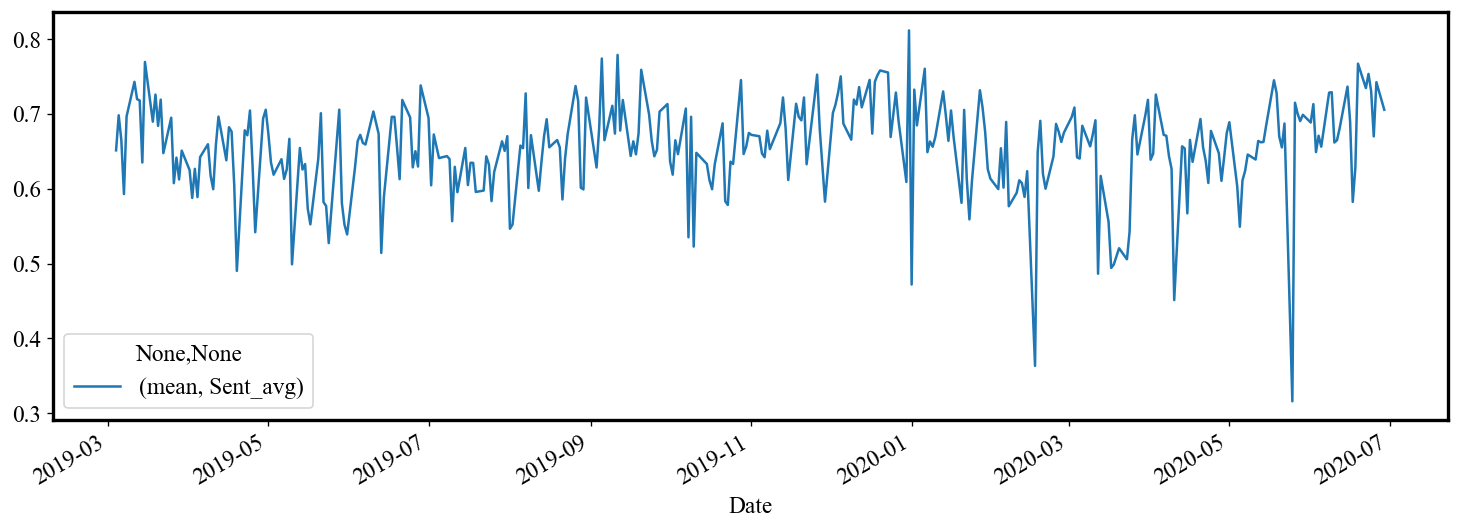

In [23]:
df_daily_avg_sent.loc["03.03.2019":"29.06.2020"].plot(figsize=(15,5))

## Plot overall sentiment by week

In [24]:
# Show average sentiment per week
df_weekly_avg_sent=pd.pivot_table(df_sp500_scores_vis,index=["Week"],\
               values=["Sent_avg_conf"],\
              # values=["Sent_avg"],\
               #values=["Sent_neg_filt","Sent_neg"],\
               aggfunc=[np.mean],fill_value=np.NaN)

# drop 2 level columns
df_weekly_avg_sent.columns = df_weekly_avg_sent.columns.map('_'.join)


#df_daily_avg_sent.plot(figsize=(15,5))
df_weekly_avg_sent

,mean_Sent_avg_conf
Week,
2019-02-25,0.793798
2019-03-04,0.892184
2019-03-11,0.945848
2019-03-18,0.940750
2019-03-25,0.876832
...,...
2020-06-01,0.887266
2020-06-08,0.865769
2020-06-15,0.876325


In [25]:
# Filter out first and last week
#df_weekly_avg_sent=df_weekly_avg_sent.loc["2019-03-03":"2020-06-28"]
df_weekly_avg_sent

,mean_Sent_avg_conf
Week,
2019-02-25,0.793798
2019-03-04,0.892184
2019-03-11,0.945848
2019-03-18,0.940750
2019-03-25,0.876832
...,...
2020-06-01,0.887266
2020-06-08,0.865769
2020-06-15,0.876325


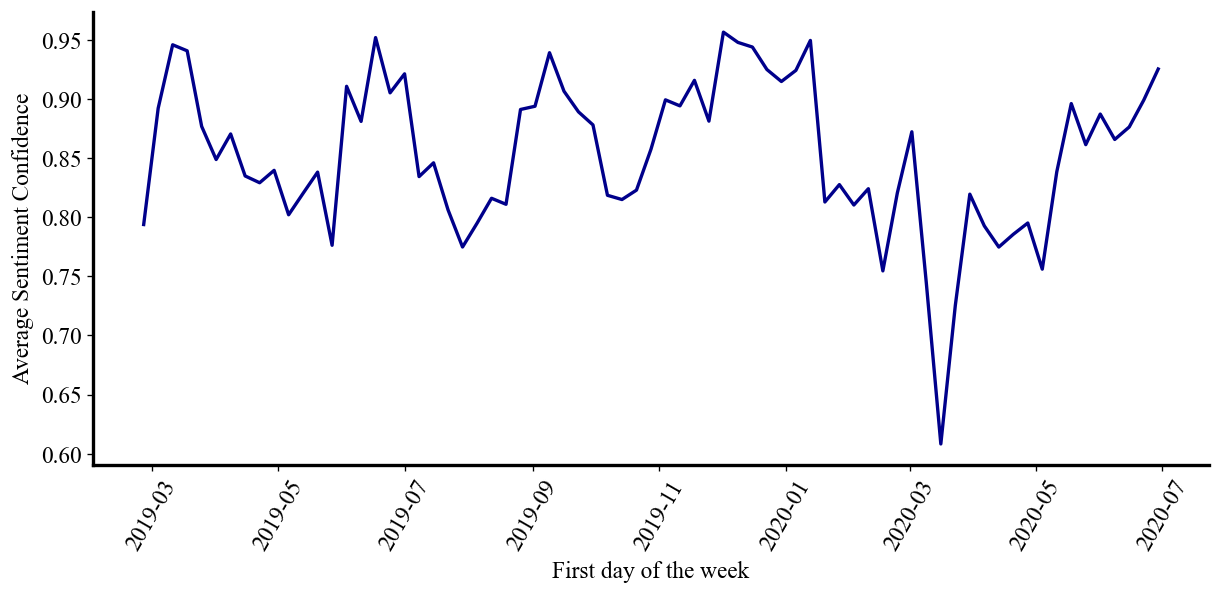

In [26]:
#colourWheel =['#00008b','#a6e9ff']
colourWheel =['#00008b','#000000']

#plt.close('all')
fig, ax = plt.subplots(figsize=(12,5))
alphaVal = 1
linethick=2
ax.plot(df_weekly_avg_sent.index,
        df_weekly_avg_sent,
        color="#00008b",
        #color="blue",
        linestyle = '-',
        #dashes=dashesStyles[j%len(dashesStyles)],
        lw=linethick,
        label="AVG Sent",
        alpha=alphaVal)

ax.set_xlabel('')
#ax.yaxis.set_major_formatter(ScalarFormatter())
#ax.yaxis.major.formatter._useMathText = True
#ax.yaxis.set_minor_locator(  AutoMinorLocator(5))
#ax.xaxis.set_minor_locator(  AutoMinorLocator(5))
#ax.yaxis.set_label_coords(0.63,1.01)
#ax.yaxis.tick_right()
plt.xticks(rotation=60)
#fig.autofmt_xdate()

import matplotlib.ticker as plticker
#loc = plticker.MultipleLocator(base=25.0) # this locator puts ticks at regular intervals
#ax.xaxis.set_major_locator(loc)


#nameOfPlot = 'GDP per hour (constant prices, indexed to 2007)'
plt.xlabel("First day of the week",rotation=0)
plt.ylabel("Average Sentiment Confidence",rotation=90)
#ax.legend(frameon=False, title="Decil",loc='lower left',ncol=2,handlelength=2)

# Hide the top and right spines of the axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# store to image
plt.savefig('Average Sentiment by week.png',dpi=300, transparent=False, bbox_inches='tight')


plt.show()

In [27]:
# Show average sentiment per week
df_weekly_avg_sent_2=pd.pivot_table(df_sp500_scores_vis,index=["Week"],\
               values=["Sent_avg_conf","Sent_conf_pos","Sent_conf_neg","News_vol"],\
              # values=["Sent_avg"],\
               #values=["Sent_neg_filt","Sent_neg"],\
               aggfunc=[np.mean,"sum"],fill_value=np.NaN)

# drop 2 level columns
df_weekly_avg_sent_2.columns = df_weekly_avg_sent_2.columns.map('_'.join)


#df_daily_avg_sent.plot(figsize=(15,5))
df_weekly_avg_sent_2

,mean_News_vol,mean_Sent_avg_conf,mean_Sent_conf_neg,mean_Sent_conf_pos,sum_News_vol,sum_Sent_avg_conf,sum_Sent_conf_neg,sum_Sent_conf_pos
Week,,,,,,,,
2019-02-25,5.553009,0.793798,-0.912282,5.305369,1938,277.035515,-318.386329,1851.573612
2019-03-04,5.204900,0.892184,-0.792234,4.782113,9348,1602.361592,-1422.851702,8588.675773
2019-03-11,5.932306,0.945848,-0.809860,5.278751,10779,1718.606680,-1471.516131,9591.490966
2019-03-18,5.425228,0.940750,-0.815643,4.977593,9505,1648.193461,-1429.005960,8720.742348
2019-03-25,5.579812,0.876832,-0.773334,5.098815,9508,1494.121315,-1317.761609,8688.380041
...,...,...,...,...,...,...,...,...
2020-06-01,4.397293,0.887266,-0.664602,3.896211,7471,1507.465697,-1129.158264,6619.661683
2020-06-08,4.490909,0.865769,-0.786497,4.006931,7410,1428.518898,-1297.719530,6611.436427
2020-06-15,4.483761,0.876325,-0.703731,3.993075,7869,1537.950419,-1235.047680,7007.847415


In [28]:
# Filter out first and last week
#df_weekly_avg_sent_2=df_weekly_avg_sent_2.loc["2019-03-03":"2020-06-28"]
df_weekly_avg_sent_2

,mean_News_vol,mean_Sent_avg_conf,mean_Sent_conf_neg,mean_Sent_conf_pos,sum_News_vol,sum_Sent_avg_conf,sum_Sent_conf_neg,sum_Sent_conf_pos
Week,,,,,,,,
2019-02-25,5.553009,0.793798,-0.912282,5.305369,1938,277.035515,-318.386329,1851.573612
2019-03-04,5.204900,0.892184,-0.792234,4.782113,9348,1602.361592,-1422.851702,8588.675773
2019-03-11,5.932306,0.945848,-0.809860,5.278751,10779,1718.606680,-1471.516131,9591.490966
2019-03-18,5.425228,0.940750,-0.815643,4.977593,9505,1648.193461,-1429.005960,8720.742348
2019-03-25,5.579812,0.876832,-0.773334,5.098815,9508,1494.121315,-1317.761609,8688.380041
...,...,...,...,...,...,...,...,...
2020-06-01,4.397293,0.887266,-0.664602,3.896211,7471,1507.465697,-1129.158264,6619.661683
2020-06-08,4.490909,0.865769,-0.786497,4.006931,7410,1428.518898,-1297.719530,6611.436427
2020-06-15,4.483761,0.876325,-0.703731,3.993075,7869,1537.950419,-1235.047680,7007.847415


In [29]:
df_weekly_avg_sent_2[df_weekly_avg_sent_2.index=="2019-12-23"]

,mean_News_vol,mean_Sent_avg_conf,mean_Sent_conf_neg,mean_Sent_conf_pos,sum_News_vol,sum_Sent_avg_conf,sum_Sent_conf_neg,sum_Sent_conf_pos
Week,,,,,,,,
2019-12-23,3.575298,0.924925,-0.474912,3.330734,3300,853.705996,-438.343479,3074.267258


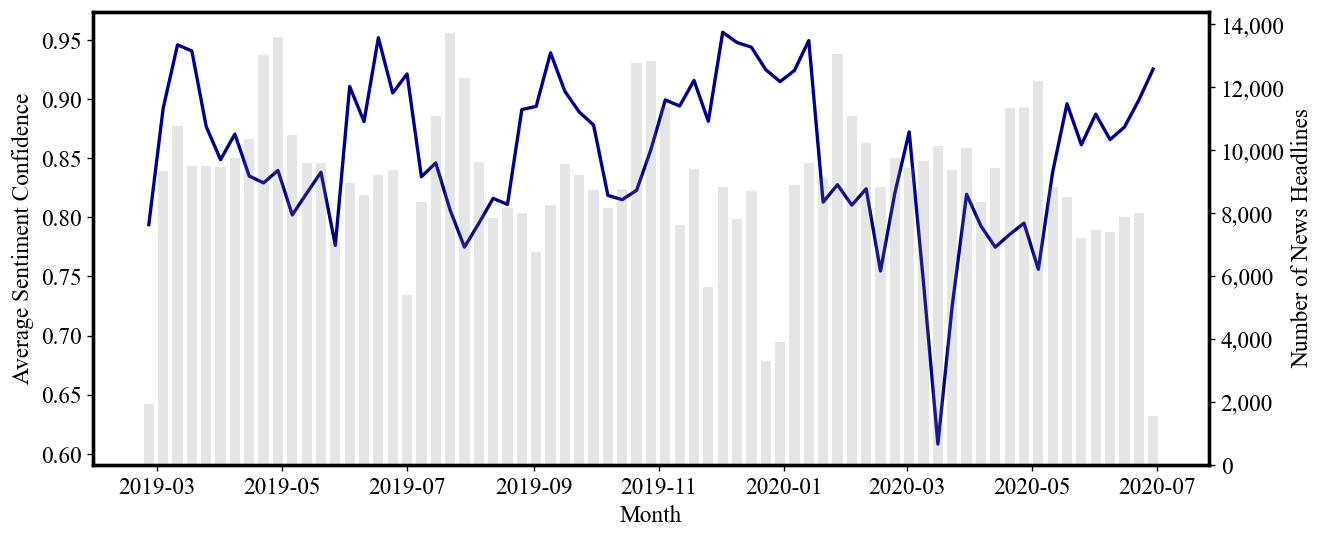

In [30]:
#df_mean_percentiles_trans[:"29.06.2020"].plot(figsize=(12,8),rot=60)
#colourWheel =['#00008b','#a6e9ff']
colourWheel =['#00008b','#000000']

#plt.close('all')
fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()  # set up the 2nd axis

alphaVal = 1
linethick=2

ax2.bar(df_weekly_avg_sent_2.index,
        df_weekly_avg_sent_2.sum_News_vol,
        color="grey",
        alpha=0.2, 
        width=5,
        #color="blue",
        label="News Vol",
        #alpha=alphaVal
       )

ax.plot(df_weekly_avg_sent_2.index,
        df_weekly_avg_sent_2.mean_Sent_avg_conf,
        color="#00008b",
        #color="blue",
        linestyle = '-',
        #dashes=dashesStyles[j%len(dashesStyles)],
        lw=linethick,
        label="Sent AVG Conf",
       # alpha=alphaVal
       )


"""ax.plot(df_weekly_avg_sent_2.index,
        df_weekly_avg_sent_2.mean_Sent_conf_neg,
        color="#000000",
        #color="blue",
        linestyle = '-',
        #dashes=dashesStyles[j%len(dashesStyles)],
        lw=linethick,
        label=series,
        alpha=alphaVal)

ax.plot(df_weekly_avg_sent_2.index,
        df_weekly_avg_sent_2.mean_Sent_conf_pos,
        color="#00000b",
        #color="blue",
        linestyle = '-',
        #dashes=dashesStyles[j%len(dashesStyles)],
        lw=linethick,
        label=series,
        alpha=alphaVal)
"""



#df_weekly_avg_sent_2.sum_News_vol.plot(secondary_y=True)

ax.set_xlabel('')
#ax.yaxis.set_major_formatter(ScalarFormatter())
#ax.yaxis.major.formatter._useMathText = True
#ax.yaxis.set_minor_locator(  AutoMinorLocator(5))
#ax.xaxis.set_minor_locator(  AutoMinorLocator(5))
#ax.yaxis.set_label_coords(0.63,1.01)
#ax.yaxis.tick_right()

#fig.autofmt_xdate()

#nameOfPlot = 'GDP per hour (constant prices, indexed to 2007)'
ax.set_xlabel("Month",rotation=0)
#plt.ylabel("Average Sentiment Confidence",rotation=90)
ax.set_ylabel('Average Sentiment Confidence')
ax2.set_ylabel('Number of News Headlines')

# Set number format for second y axis
ax2.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# store to image
plt.savefig('Average Sentiment and News Vol. by week.png',dpi=300, transparent=False, bbox_inches='tight')


plt.show()

### Add S&P index to chart

In [31]:
df_sp=pd.read_excel("../01_Data/01_Eikon/2_Prices/2_Full Stock Prices data/2_WRDS_SP 500 Full stock price.xlsx",usecols=["Date",".SPX"])
df_sp.head()

,Date,.SPX
0,2019-03-01,2803.69
1,2019-03-04,2792.81
2,2019-03-05,2789.65
3,2019-03-06,2771.45
4,2019-03-07,2748.93


In [32]:
df_sp["Date"]=pd.to_datetime(df_sp["Date"])
df_sp['weeknum'] = df_sp["Date"].apply(lambda x:x.isocalendar()[1])
df_sp["Week"]=df_sp['weeknum'].astype(str)
df_sp['year'] = df_sp["Date"].apply(lambda x:x.isocalendar()[0])
df_sp['ISO'] = df_sp['year'].astype(str) + '-W' + df_sp['Week'].astype(str) + '-1'
df_sp

,Date,.SPX,weeknum,Week,year,ISO
0,2019-03-01,2803.69,9,9,2019,2019-W9-1
1,2019-03-04,2792.81,10,10,2019,2019-W10-1
2,2019-03-05,2789.65,10,10,2019,2019-W10-1
3,2019-03-06,2771.45,10,10,2019,2019-W10-1
4,2019-03-07,2748.93,10,10,2019,2019-W10-1
...,...,...,...,...,...,...
332,2020-06-24,3050.33,26,26,2020,2020-W26-1
333,2020-06-25,3083.76,26,26,2020,2020-W26-1
334,2020-06-26,3009.05,26,26,2020,2020-W26-1
335,2020-06-29,3053.24,27,27,2020,2020-W27-1


In [33]:
# Create column that shows first day of week as "Week"
df_sp['Week'] = df_sp['ISO'].map(lambda x: datetime.datetime.strptime(x, "%G-W%V-%u"))

# Sort by date
df_sp=df_sp.sort_values(by="Date")
df_sp

# set index
df_sp=df_sp.set_index("Date")
df_sp

,.SPX,weeknum,Week,year,ISO
Date,,,,,
2019-03-01,2803.69,9,2019-02-25,2019,2019-W9-1
2019-03-04,2792.81,10,2019-03-04,2019,2019-W10-1
2019-03-05,2789.65,10,2019-03-04,2019,2019-W10-1
2019-03-06,2771.45,10,2019-03-04,2019,2019-W10-1
2019-03-07,2748.93,10,2019-03-04,2019,2019-W10-1
...,...,...,...,...,...
2020-06-24,3050.33,26,2020-06-22,2020,2020-W26-1
2020-06-25,3083.76,26,2020-06-22,2020,2020-W26-1
2020-06-26,3009.05,26,2020-06-22,2020,2020-W26-1


In [34]:
# Filter out first and last week
#df_sp=df_sp.loc["2019-03-03":"2020-06-28"]
df_sp

,.SPX,weeknum,Week,year,ISO
Date,,,,,
2019-03-01,2803.69,9,2019-02-25,2019,2019-W9-1
2019-03-04,2792.81,10,2019-03-04,2019,2019-W10-1
2019-03-05,2789.65,10,2019-03-04,2019,2019-W10-1
2019-03-06,2771.45,10,2019-03-04,2019,2019-W10-1
2019-03-07,2748.93,10,2019-03-04,2019,2019-W10-1
...,...,...,...,...,...
2020-06-24,3050.33,26,2020-06-22,2020,2020-W26-1
2020-06-25,3083.76,26,2020-06-22,2020,2020-W26-1
2020-06-26,3009.05,26,2020-06-22,2020,2020-W26-1


#### Show weekly data

In [36]:
df_sp2=df_sp.groupby("Week").agg("mean")
df_sp2

,.SPX,weeknum,year
Week,,,
2019-02-25,2803.690,9,2019
2019-03-04,2769.182,10,2019
2019-03-11,2803.340,11,2019
2019-03-18,2829.066,12,2019
2019-03-25,2814.406,13,2019
...,...,...,...
2020-06-01,3113.140,23,2020
2020-06-08,3134.624,24,2020
2020-06-15,3103.580,25,2020


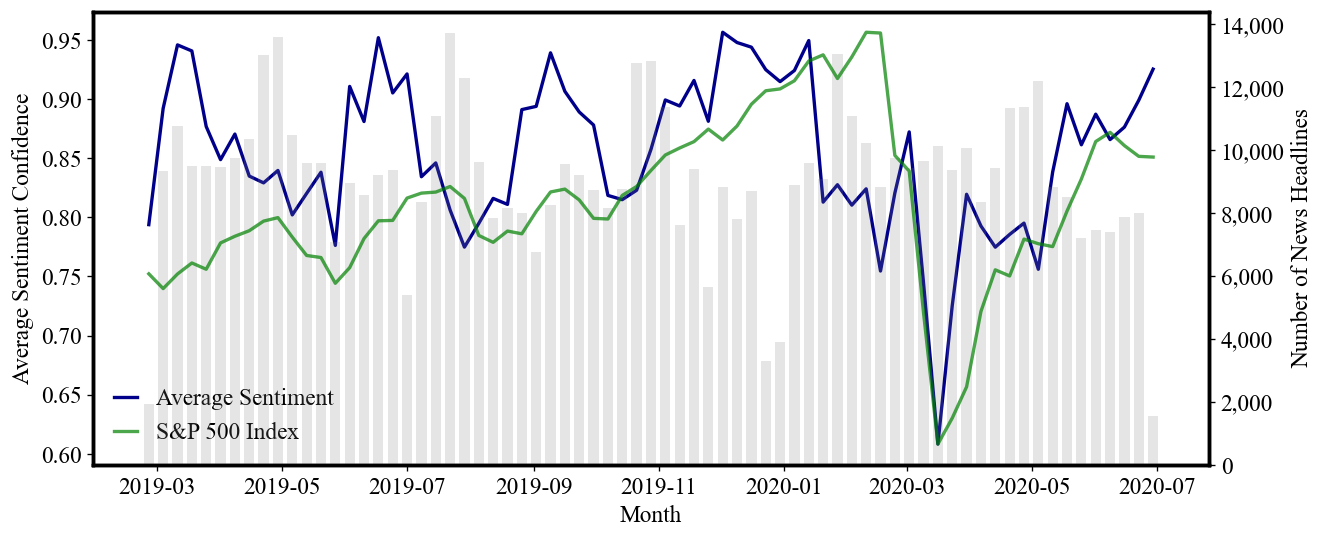

In [37]:
#df_mean_percentiles_trans[:"29.06.2020"].plot(figsize=(12,8),rot=60)
#colourWheel =['#00008b','#a6e9ff']
colourWheel =['#00008b','#000000']

#plt.close('all')
fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()  # set up the 2nd axis

alphaVal = 1
linethick=2

ax2.bar(df_weekly_avg_sent_2.index,
        df_weekly_avg_sent_2.sum_News_vol,
        color="grey",
        alpha=0.2, 
        width=5,
        #color="blue",
        label="News Vol.",
        #alpha=alphaVal
       )

lns1=ax.plot(df_weekly_avg_sent_2.index,
        df_weekly_avg_sent_2.mean_Sent_avg_conf,
        color="#00008b",
        #color="blue",
        linestyle = '-',
        #dashes=dashesStyles[j%len(dashesStyles)],
        lw=linethick,
        label="Average Sentiment",
   
       # alpha=alphaVal
       )

ax3 = ax.twinx() 

lns2=ax3.plot(df_sp2.index,
        df_sp2[".SPX"],
        color="green",
        #color="blue",
        linestyle = '-',
         alpha=.7,
        #dashes=dashesStyles[j%len(dashesStyles)],
        lw=linethick,
        label="S&P 500 Index",
       # alpha=alphaVal
       )
# hide axis three
ax3.get_yaxis().set_visible(False)


"""ax.plot(df_weekly_avg_sent_2.index,
        df_weekly_avg_sent_2.mean_Sent_conf_neg,
        color="#000000",
        #color="blue",
        linestyle = '-',
        #dashes=dashesStyles[j%len(dashesStyles)],
        lw=linethick,
        label=series,
        alpha=alphaVal)

ax.plot(df_weekly_avg_sent_2.index,
        df_weekly_avg_sent_2.mean_Sent_conf_pos,
        color="#00000b",
        #color="blue",
        linestyle = '-',
        #dashes=dashesStyles[j%len(dashesStyles)],
        lw=linethick,
        label=series,
        alpha=alphaVal)
"""



#df_weekly_avg_sent_2.sum_News_vol.plot(secondary_y=True)

ax.set_xlabel('')
#ax.yaxis.set_major_formatter(ScalarFormatter())
#ax.yaxis.major.formatter._useMathText = True
#ax.yaxis.set_minor_locator(  AutoMinorLocator(5))
#ax.xaxis.set_minor_locator(  AutoMinorLocator(5))
#ax.yaxis.set_label_coords(0.63,1.01)
#ax.yaxis.tick_right()

#fig.autofmt_xdate()

#nameOfPlot = 'GDP per hour (constant prices, indexed to 2007)'
ax.set_xlabel("Month",rotation=0)
#plt.ylabel("Average Sentiment Confidence",rotation=90)
ax.set_ylabel('Average Sentiment Confidence')
ax2.set_ylabel('Number of News Headlines')

# Set number format for second y axis
ax2.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# insert legend
#ax.legend(frameon=True, title="Legend",loc='lower left',ncol=2,handlelength=2)
#plt.legend(loc='lower left')
#fig.legend(loc="lower left")
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False,
          #title="Legend",\
          loc='lower left',ncol=1,handlelength=1,framealpha=1,facecolor="w")

# store to image
plt.savefig('Average Sentiment and News Vol. and SP Index by week.png',dpi=300, transparent=False, bbox_inches='tight')


plt.show()

### Sentiment per day

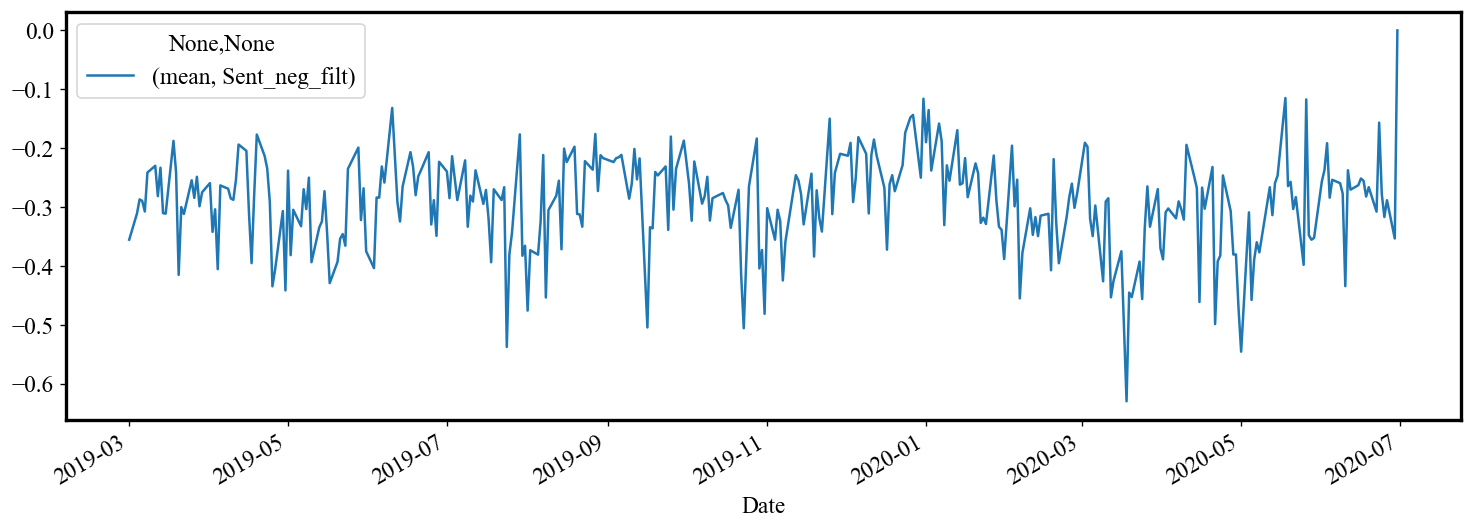

In [38]:
# Show average negative sentiment per day
df_daily_avg_sent=pd.pivot_table(df_sp500_scores_vis,index=["Date"],\
               values=["Sent_neg_filt"],\
               #values=["Sent_neg"],\
               #values=["Sent_neg_filt","Sent_neg"],\
               aggfunc=[np.mean],fill_value=np.NaN)

df_daily_avg_sent.plot(figsize=(15,5))

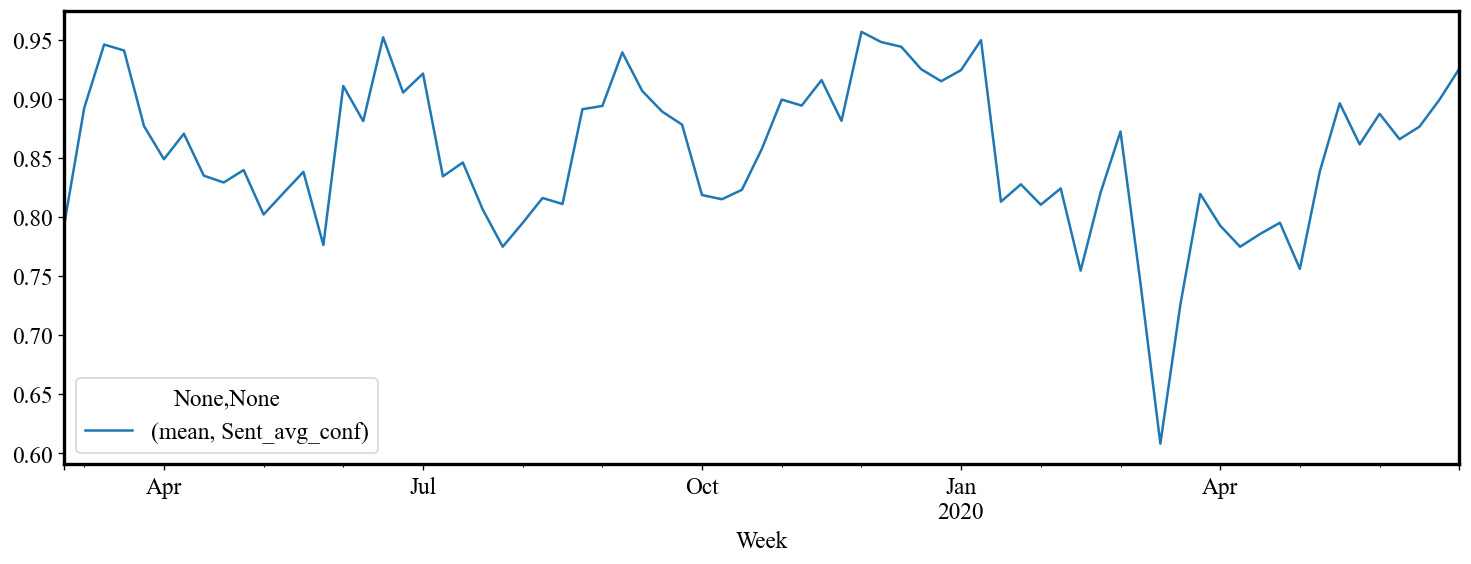

In [39]:
# Show average negative sentiment per day
df_daily_avg_sent=pd.pivot_table(df_sp500_scores_vis,index=["Week"],\
               values=["Sent_avg_conf"],\
              # values=["Sent_avg"],\
               #values=["Sent_neg_filt","Sent_neg"],\
               aggfunc=[np.mean],fill_value=np.NaN)

df_daily_avg_sent.plot(figsize=(15,5))

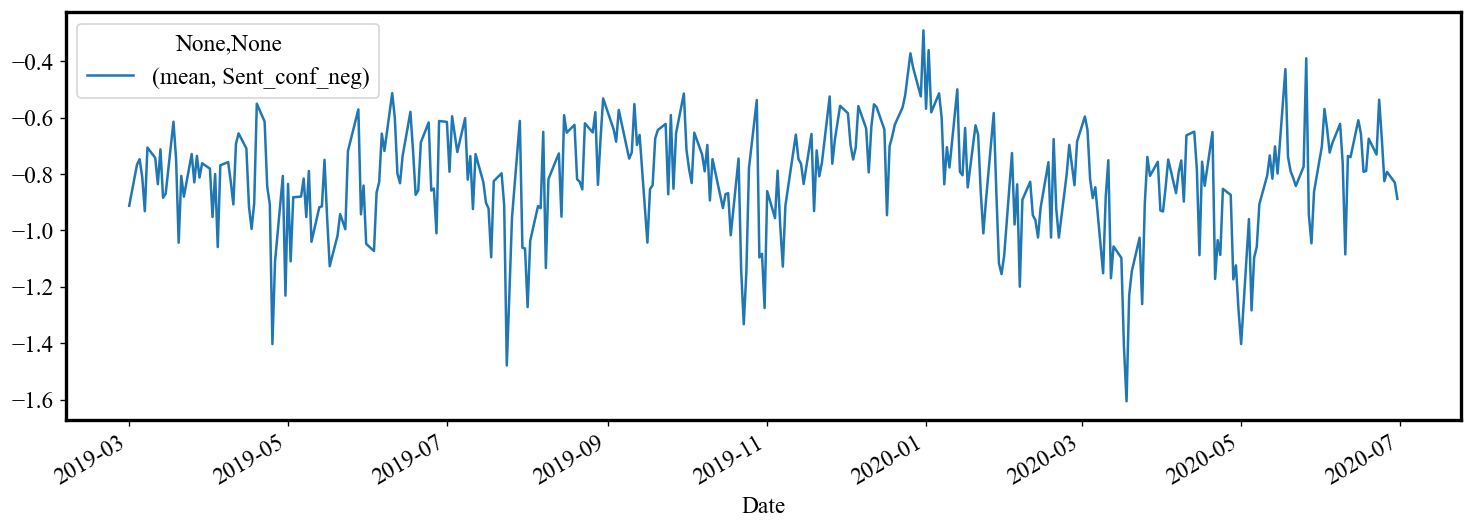

In [40]:
# Show average negative sentiment per day
df_daily_avg_sent=pd.pivot_table(df_sp500_scores_vis,index=["Date"],\
               values=["Sent_conf_neg"],\
               #values=["Sent_neg"],\
               #values=["Sent_neg_filt","Sent_neg"],\
               aggfunc=[np.mean],fill_value=np.NaN)

df_daily_avg_sent.plot(figsize=(15,5))

### Plot weekly average sentiment by firm

In [41]:
df_sp500_scores_vis.sort_values(by="Week")

,Date,RIC,Sent_abs,Sent_neg,Sent_pos,Sent_abs_filt,Sent_neg_filt,Sent_pos_filt,Sent_conf_abs,Sent_conf_pos,...,Sent_avg_conf_neg,Sent_ratio,Sent_ratio_filt,Sent_ratio_conf,weeknum,year,Week_display,Week,ISO,Month
0,2019-03-01 00:00:00+00:00,A,2,0,2,2,0,2,4.847166,4.847166,...,0.000000,1.098612,1.098612,1.765957,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03
174,2019-03-01 00:00:00+00:00,J,2,0,2,2,0,2,3.340299,3.340299,...,0.000000,1.098612,1.098612,1.467943,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03
1,2019-03-01 00:00:00+00:00,AAL.O,0,-4,4,-1,-3,2,-1.724518,5.135082,...,-0.857450,0.000000,-0.287682,-0.247712,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03
2,2019-03-01 00:00:00+00:00,AAPL.O,14,-4,18,6,-1,7,13.352791,15.933397,...,-0.117300,1.335001,1.386294,1.553756,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03
3,2019-03-01 00:00:00+00:00,ABBV.K,6,-1,7,1,0,1,4.841053,5.036389,...,-0.024417,1.386294,0.693147,1.619378,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118650,2020-06-29 00:00:00+00:00,ZBH,2,0,2,0,0,0,0.709361,0.709361,...,0.000000,1.098612,0.000000,0.536119,27,2020,2020-27,2020-06-29,2020-W27-1,2020-06
118651,2020-06-29 00:00:00+00:00,ZBRA.O,1,0,1,1,0,1,1.133277,1.133277,...,0.000000,0.693147,0.693147,0.757659,27,2020,2020-27,2020-06-29,2020-W27-1,2020-06
118495,2020-06-29 00:00:00+00:00,IPG,1,0,1,1,0,1,1.450557,1.450557,...,0.000000,0.693147,0.693147,0.896315,27,2020,2020-27,2020-06-29,2020-W27-1,2020-06
118635,2020-06-29 00:00:00+00:00,WDC.O,2,0,2,2,0,2,3.047957,3.047957,...,0.000000,1.098612,1.098612,1.398212,27,2020,2020-27,2020-06-29,2020-W27-1,2020-06


In [42]:
# Show average sentiment per week
df_week_avg_sent_by_comp=pd.pivot_table(df_sp500_scores_vis,index=["RIC"],columns=["Week"],\
               #values=["Sent_avg"],\
               #values=["Sent_avg_filt"],\
               values=["Sent_avg_conf"],\
               #values=["Sent_conf_neg"],\
               aggfunc=[np.mean],fill_value=np.NaN)

df_week_avg_sent_by_comp.head()

mean                                                         \
       Sent_avg_conf                                                          
Week      2019-02-25 2019-03-04 2019-03-11 2019-03-18 2019-03-25 2019-04-01   
RIC                                                                           
A           2.423583   1.123538   1.103127   1.001984   0.867805   0.497732   
AAL.O      -0.215565   0.649199   0.265726  -0.052005   0.339435   1.117340   
AAP              NaN   0.354106        NaN   1.044754   1.978439   1.232818   
AAPL.O      0.606945   0.629923   0.682446   1.080747   0.571667   0.669947   
ABBV.K      0.605132   0.945986   1.217553   0.380793   0.804673   0.894639   

                                                    ...                        \
                                                    ...                         
Week   2019-04-08 2019-04-15 2019-04-22 2019-04-29  ... 2020-04-27 2020-05-04   
RIC                                                 ...                         
A        1.211661   1.382477   0.922506   1.487917  ...   1.305730   1.768609   
AAL.O    0.640775   0.425036   0.659178   1.040581  ...   0.415970   0.168054   
AAP      0.702361  -0.664961        NaN   0.126646  ...        NaN  -0.910425   
AAPL.O   0.908920   0.654183   0.504707   1.000421  ...   0.660011   0.737765   
ABBV.K   1.334903   0.988127   0.810557   0.559579  ...   0.333153   0.890941   

                                                                          \
                                                                           
Week   2020-05-11 2020-05-18 2020-05-25 2020-06-01 2020-06-08 2020-06-15   
RIC                                                                        
A        0.752886   1.079164   1.017360   1.004194   0.629873   1.132245   
AAL.O    0.442194   0.147727   0.432921   1.172001   0.507481   0.475563   
AAP      0.535897   0.290299  -0.094326        NaN   0.375257   0.315963   
AAPL.O   0.713031   0.636215   0.728642   0.472120   0.685519   0.463039   
ABBV.K   0.650657   0.919366   0.596201   0.938494   1.349063   0.567975   

                              
                              
Week   2020-06-22 2020-06-29  
RIC                           
A        0.855500   1.763380  
AAL.O    0.667597   0.339270  
AAP      0.123364        NaN  
AAPL.O   0.675814   0.610957  
ABBV.K   1.268257   0.318114  

[5 rows x 71 columns]

In [43]:
# flatten columns
level_three = df_week_avg_sent_by_comp.columns.get_level_values(2).astype(str)
df_week_avg_sent_by_comp.columns = level_three

In [44]:
labels=[1,2,3,4,5,6,7,8,9,10]
#labels=[1,2,3]

col_list=df_week_avg_sent_by_comp.columns

# Calculate percentiles by week and company
for i in col_list:
    df_week_avg_sent_by_comp[str(i)+"_percentile"]=pd.qcut(df_week_avg_sent_by_comp[i].rank(method='first'),\
                                                      10,
                                                      #[0,0.33,0.66,1.0],\
                                                      #duplicates="drop",\
                                                      labels=labels
                                                     )

df_week_avg_sent_by_comp

Week,2019-02-25,2019-03-04,2019-03-11,2019-03-18,2019-03-25,2019-04-01,2019-04-08,2019-04-15,2019-04-22,2019-04-29,...,2020-04-27_percentile,2020-05-04_percentile,2020-05-11_percentile,2020-05-18_percentile,2020-05-25_percentile,2020-06-01_percentile,2020-06-08_percentile,2020-06-15_percentile,2020-06-22_percentile,2020-06-29_percentile
RIC,,,,,,,,,,,,,,,,,,,,,
A,2.423583,1.123538,1.103127,1.001984,0.867805,0.497732,1.211661,1.382477,0.922506,1.487917,...,9,10,4,7,6,7,3,8,5,10
AAL.O,-0.215565,0.649199,0.265726,-0.052005,0.339435,1.117340,0.640775,0.425036,0.659178,1.040581,...,3,2,2,1,2,8,3,3,3,2
AAP,NaN,0.354106,NaN,1.044754,1.978439,1.232818,0.702361,-0.664961,NaN,0.126646,...,NaN,1,3,2,1,NaN,2,2,1,NaN
AAPL.O,0.606945,0.629923,0.682446,1.080747,0.571667,0.669947,0.908920,0.654183,0.504707,1.000421,...,4,5,4,3,4,2,4,2,3,4
ABBV.K,0.605132,0.945986,1.217553,0.380793,0.804673,0.894639,1.334903,0.988127,0.810557,0.559579,...,2,7,4,6,3,6,9,3,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.953513,0.659385,0.911560,1.095176,1.901223,-0.063787,0.693087,1.287894,0.682422,0.775832,...,1,10,8,2,5,3,3,1,7,8
ZBH,-2.240566,1.652744,1.169143,1.295503,1.677742,0.436067,0.730092,1.037556,0.660466,1.607468,...,7,2,9,8,2,NaN,9,4,10,2
ZBRA.O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7,2,5,3,10,10,10,3,10,7


In [45]:
df_week_avg_sent_by_comp.to_excel("Test_avg_sent_score_by_week.xlsx")

In [46]:
df_week_avg_sent_perc=pd.DataFrame()
list_dfs=[]

for i in col_list:
    df_week_avg_sent_perc=df_week_avg_sent_by_comp.groupby(str(i)+'_percentile').mean()[i]
    list_dfs.append(df_week_avg_sent_perc)
    
#list_dfs[5]

In [47]:
# append dataframes
df_mean_percentiles = pd.concat(list_dfs,axis=1)

df_mean_percentiles.head()

,2019-02-25,2019-03-04,2019-03-11,2019-03-18,2019-03-25,2019-04-01,2019-04-08,2019-04-15,2019-04-22,2019-04-29,...,2020-04-27,2020-05-04,2020-05-11,2020-05-18,2020-05-25,2020-06-01,2020-06-08,2020-06-15,2020-06-22,2020-06-29
1,-0.834012,-0.209052,0.077653,-0.028196,-0.127737,-0.194839,-0.130813,-0.103212,-0.146550,0.032452,...,-0.117790,-0.188150,-0.038547,-0.006486,-0.165736,-0.092451,-0.248575,-0.112007,0.018230,-0.564077
2,0.020200,0.335001,0.464202,0.392165,0.374849,0.254727,0.370523,0.344286,0.371178,0.411760,...,0.294571,0.276073,0.383590,0.378375,0.366357,0.350493,0.381007,0.341947,0.412550,0.223795
3,0.326327,0.554125,0.658325,0.614060,0.557012,0.483894,0.533481,0.543452,0.523864,0.552876,...,0.491143,0.474403,0.563844,0.604150,0.593474,0.585443,0.576917,0.565304,0.629141,0.497969
4,0.555478,0.708581,0.793142,0.797098,0.680591,0.660545,0.666076,0.675104,0.661510,0.687147,...,0.620329,0.585339,0.700719,0.728182,0.755097,0.727844,0.723351,0.737162,0.782244,0.711473
5,0.761948,0.844418,0.915774,0.910225,0.831763,0.771400,0.805507,0.824022,0.768509,0.797700,...,0.753929,0.699210,0.825725,0.823034,0.872202,0.839420,0.868796,0.880966,0.892830,0.885900


In [48]:
df_mean_percentiles_trans=df_mean_percentiles.transpose()
df_mean_percentiles_trans


,1,2,3,4,5,6,7,8,9,10
2019-02-25,-0.834012,0.020200,0.326327,0.555478,0.761948,0.942421,1.133511,1.387002,1.533741,2.115611
2019-03-04,-0.209052,0.335001,0.554125,0.708581,0.844418,0.955491,1.085419,1.251133,1.475200,2.016739
2019-03-11,0.077653,0.464202,0.658325,0.793142,0.915774,1.015654,1.122130,1.235617,1.405569,1.866255
2019-03-18,-0.028196,0.392165,0.614060,0.797098,0.910225,1.028827,1.140545,1.259381,1.425460,1.944957
2019-03-25,-0.127737,0.374849,0.557012,0.680591,0.831763,0.943925,1.060837,1.262957,1.475560,1.982252
...,...,...,...,...,...,...,...,...,...,...
2020-06-01,-0.092451,0.350493,0.585443,0.727844,0.839420,0.938945,1.061958,1.204386,1.403787,1.862832
2020-06-08,-0.248575,0.381007,0.576917,0.723351,0.868796,0.958105,1.051258,1.171708,1.323109,1.822470
2020-06-15,-0.112007,0.341947,0.565304,0.737162,0.880966,0.972862,1.060017,1.187410,1.383061,1.804980
2020-06-22,0.018230,0.412550,0.629141,0.782244,0.892830,0.962153,1.054599,1.168698,1.343977,1.954662


In [49]:
# Filter out first and last week
df_mean_percentiles_trans=df_mean_percentiles_trans.loc["2019-03-03":"2020-06-28"]
df_mean_percentiles_trans

,1,2,3,4,5,6,7,8,9,10
2019-03-04,-0.209052,0.335001,0.554125,0.708581,0.844418,0.955491,1.085419,1.251133,1.475200,2.016739
2019-03-11,0.077653,0.464202,0.658325,0.793142,0.915774,1.015654,1.122130,1.235617,1.405569,1.866255
2019-03-18,-0.028196,0.392165,0.614060,0.797098,0.910225,1.028827,1.140545,1.259381,1.425460,1.944957
2019-03-25,-0.127737,0.374849,0.557012,0.680591,0.831763,0.943925,1.060837,1.262957,1.475560,1.982252
2019-04-01,-0.194839,0.254727,0.483894,0.660545,0.771400,0.875875,1.006827,1.154487,1.367932,1.856332
...,...,...,...,...,...,...,...,...,...,...
2020-05-25,-0.165736,0.366357,0.593474,0.755097,0.872202,0.965285,1.079800,1.197717,1.368270,1.805091
2020-06-01,-0.092451,0.350493,0.585443,0.727844,0.839420,0.938945,1.061958,1.204386,1.403787,1.862832
2020-06-08,-0.248575,0.381007,0.576917,0.723351,0.868796,0.958105,1.051258,1.171708,1.323109,1.822470
2020-06-15,-0.112007,0.341947,0.565304,0.737162,0.880966,0.972862,1.060017,1.187410,1.383061,1.804980


In [50]:
df_mean_percentiles_trans.to_excel("Weekly_average_Sent_conf by Percentile.xlsx")

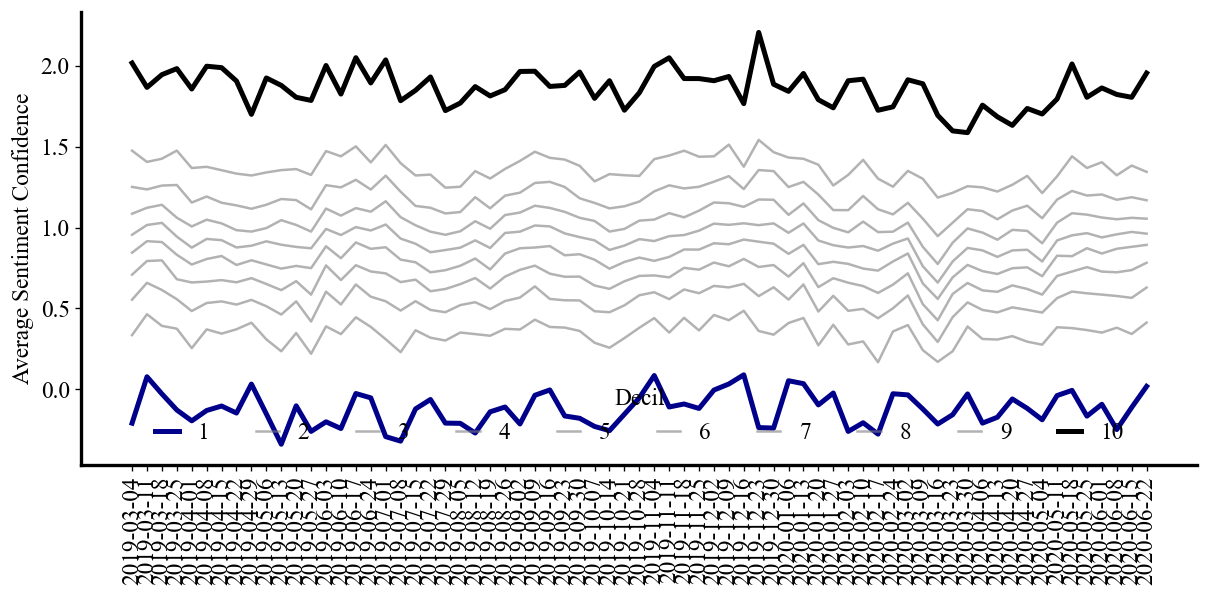

In [51]:
#df_mean_percentiles_trans[:"29.06.2020"].plot(figsize=(12,8),rot=60)
#colourWheel =['#00008b','#a6e9ff']
colourWheel =['#00008b','#000000']

#plt.close('all')
fig, ax = plt.subplots(figsize=(12,5))
for j,series in enumerate(df_mean_percentiles_trans):
    if(series==1 or series==10):
        alphaVal = 1
        linethick=3
        ax.plot(df_mean_percentiles_trans[series].index,
                df_mean_percentiles_trans[series],
                color=colourWheel[j%len(colourWheel)],
                #color="blue",
                linestyle = '-',
                #dashes=dashesStyles[j%len(dashesStyles)],
                lw=linethick,
                label=series,
                alpha=alphaVal)
    else:
        alphaVal = 0.6
        linethick = 1.5
        ax.plot(df_mean_percentiles_trans[series].index,
                df_mean_percentiles_trans[series],
                #color=colourWheel[j%len(colourWheel)],
                color="grey",
                linestyle = '-',
                #dashes=dashesStyles[j%len(dashesStyles)],
                lw=linethick,
                label=series,
                alpha=alphaVal)
#ax.set_xlabel('')
#ax.yaxis.set_major_formatter(ScalarFormatter())
#ax.yaxis.major.formatter._useMathText = True
#ax.yaxis.set_minor_locator(  AutoMinorLocator(5))
#ax.xaxis.set_minor_locator(  AutoMinorLocator(5))
#ax.yaxis.set_label_coords(0.63,1.01)
#ax.yaxis.tick_right()
plt.xticks(rotation=90)
#fig.autofmt_xdate()

import matplotlib.ticker as plticker

#loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
#ax.xaxis.set_major_locator(loc)

# Hide the top and right spines of the axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)



#nameOfPlot = 'GDP per hour (constant prices, indexed to 2007)'
#plt.xlabel("First Day of Week",rotation=0)
plt.ylabel("Average Sentiment Confidence",rotation=90)
ax.legend(frameon=False, title="Decil",loc='lower center',ncol=10,handlelength=1)

# store to image
plt.savefig('Average Sentiment by decil and week.png',dpi=300, transparent=False, bbox_inches='tight')

plt.show()

### Plot monthly average sentiment by percentile and month

In [53]:
# Show average sentiment per week
df_month_avg_sent_by_comp=pd.pivot_table(df_sp500_scores_vis,index=["RIC"],columns=["Month"],\
               #values=["Sent_avg"],\
               #values=["Sent_avg_filt"],\
               values=["Sent_avg_conf"],\
               #values=["Sent_conf_neg"],\
               aggfunc=[np.mean],fill_value=np.NaN)

# flatten columns
level_three = df_month_avg_sent_by_comp.columns.get_level_values(2).astype(str)
df_month_avg_sent_by_comp.columns = level_three

df_month_avg_sent_by_comp.head()

Month,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06
RIC,,,,,,,,,,,,,,,,
A,1.112385,1.153164,1.102437,1.181171,0.687223,1.218059,1.274209,1.499000,1.284887,0.387496,1.326865,1.152614,1.289565,1.257005,1.111414,0.941300
AAL.O,0.276010,0.712094,0.456874,0.555902,0.709540,0.445767,0.537994,0.823808,0.537389,0.389838,0.392229,0.420764,0.510786,0.364282,0.298546,0.664024
AAP,1.019182,0.212431,0.710521,0.896621,0.926158,0.666008,0.968886,0.180201,0.500833,1.168865,0.766952,0.737200,1.003019,0.811514,0.200519,0.275225
AAPL.O,0.734803,0.712191,0.735880,0.699489,0.722769,0.550802,0.777754,0.790562,0.641680,0.828222,0.791416,0.591841,0.453659,0.637668,0.703913,0.575877
ABBV.K,0.826198,0.972155,0.698110,0.807890,0.714705,0.806687,0.680803,0.814893,1.088047,1.053923,1.040052,0.699780,0.688178,0.700647,0.773138,0.997003


In [54]:
labels=[1,2,3,4,5,6,7,8,9,10]

col_list=df_month_avg_sent_by_comp.columns

# Calculate percentiles by week and company
for i in col_list:
    df_month_avg_sent_by_comp[str(i)+"_decil"]=pd.qcut(df_month_avg_sent_by_comp[i].rank(method='first'),10,\
                                                      #duplicates="drop",\
                                                      labels=labels)

df_month_avg_sent_by_comp.head()

Month,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,...,2019-09_decil,2019-10_decil,2019-11_decil,2019-12_decil,2020-01_decil,2020-02_decil,2020-03_decil,2020-04_decil,2020-05_decil,2020-06_decil
RIC,,,,,,,,,,,,,,,,,,,,,
A,1.112385,1.153164,1.102437,1.181171,0.687223,1.218059,1.274209,1.499000,1.284887,0.387496,...,9,10,9,1,10,9,10,10,8,6
AAL.O,0.276010,0.712094,0.456874,0.555902,0.709540,0.445767,0.537994,0.823808,0.537389,0.389838,...,2,5,2,1,1,2,3,2,1,3
AAP,1.019182,0.212431,0.710521,0.896621,0.926158,0.666008,0.968886,0.180201,0.500833,1.168865,...,6,1,2,8,4,5,8,6,1,1
AAPL.O,0.734803,0.712191,0.735880,0.699489,0.722769,0.550802,0.777754,0.790562,0.641680,0.828222,...,4,5,3,4,4,3,2,4,4,3
ABBV.K,0.826198,0.972155,0.698110,0.807890,0.714705,0.806687,0.680803,0.814893,1.088047,1.053923,...,3,5,8,6,7,4,5,4,4,7


In [55]:
df_month_avg_sent_perc=pd.DataFrame()
list_dfs=[]

for i in col_list:
    df_month_avg_sent_perc=df_month_avg_sent_by_comp.groupby(str(i)+'_decil').mean()[i]
    list_dfs.append(df_month_avg_sent_perc)
    
#list_dfs[5]

In [56]:
# append dataframes
df_mean_percentiles = pd.concat(list_dfs,axis=1)

df_mean_percentiles.head()

,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06
1,0.250718,0.198529,0.177126,0.191551,0.230892,0.180255,0.263003,0.199756,0.238704,0.285001,0.269188,0.178147,0.192727,0.176372,0.212951,0.236427
2,0.512537,0.501117,0.457547,0.514661,0.500492,0.468263,0.509639,0.475505,0.527304,0.598376,0.523797,0.439397,0.422902,0.443195,0.451194,0.479773
3,0.672542,0.623528,0.573068,0.685366,0.609471,0.597692,0.651841,0.605144,0.666663,0.728391,0.645454,0.564947,0.525791,0.576941,0.616704,0.638464
4,0.777607,0.722006,0.676329,0.803029,0.713413,0.708878,0.778069,0.704826,0.765972,0.825420,0.771761,0.666798,0.617630,0.674835,0.740946,0.768896
5,0.872049,0.800851,0.771095,0.889327,0.795384,0.799908,0.882686,0.785458,0.866966,0.929294,0.871064,0.780914,0.702022,0.763641,0.813595,0.873033


In [57]:
df_mean_percentiles_trans=df_mean_percentiles.transpose()

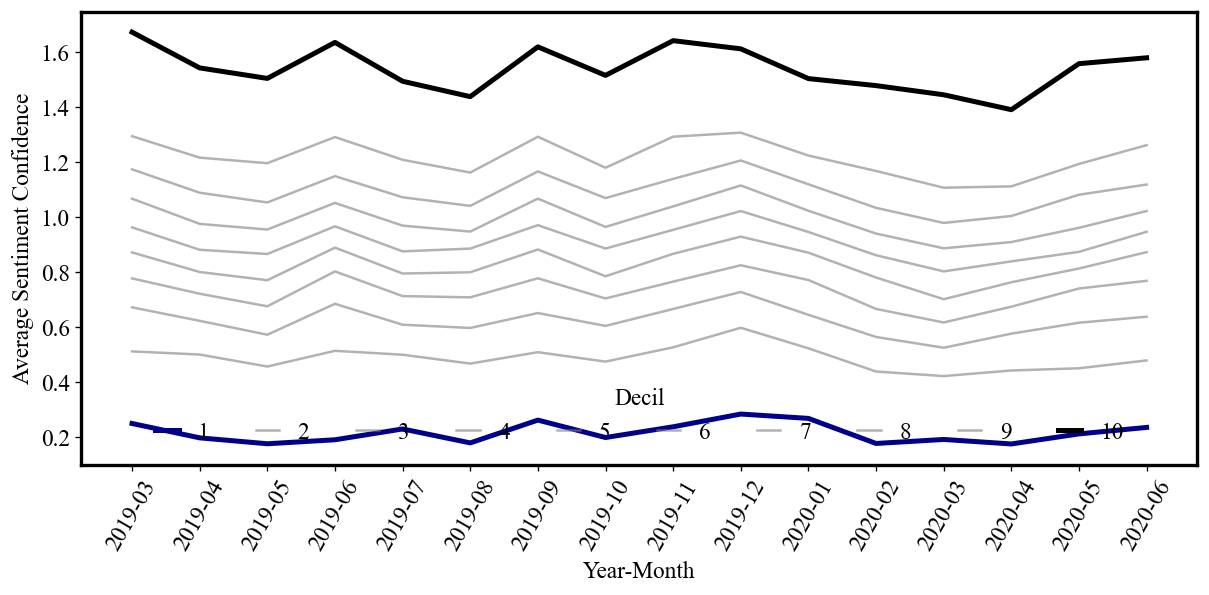

In [58]:
#df_mean_percentiles_trans[:"29.06.2020"].plot(figsize=(12,8),rot=60)
#colourWheel =['#00008b','#a6e9ff']
colourWheel =['#00008b','#000000']

#plt.close('all')
fig, ax = plt.subplots(figsize=(12,5))
for j,series in enumerate(df_mean_percentiles_trans[:]):
    if(series==1 or series==10):
        alphaVal = 1
        linethick=3
        ax.plot(df_mean_percentiles_trans[series].index,
                df_mean_percentiles_trans[series],
                color=colourWheel[j%len(colourWheel)],
                #color="blue",
                linestyle = '-',
                #dashes=dashesStyles[j%len(dashesStyles)],
                lw=linethick,
                label=series,
                alpha=alphaVal)
    else:
        alphaVal = 0.6
        linethick = 1.5
        ax.plot(df_mean_percentiles_trans[series].index,
                df_mean_percentiles_trans[series],
                #color=colourWheel[j%len(colourWheel)],
                color="grey",
                linestyle = '-',
                #dashes=dashesStyles[j%len(dashesStyles)],
                lw=linethick,
                label=series,
                alpha=alphaVal)
ax.set_xlabel('')
#ax.yaxis.set_major_formatter(ScalarFormatter())
#ax.yaxis.major.formatter._useMathText = True
#ax.yaxis.set_minor_locator(  AutoMinorLocator(5))
#ax.xaxis.set_minor_locator(  AutoMinorLocator(5))
#ax.yaxis.set_label_coords(0.63,1.01)
#ax.yaxis.tick_right()
plt.xticks(rotation=60)
#fig.autofmt_xdate()

import matplotlib.ticker as plticker

loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

#nameOfPlot = 'GDP per hour (constant prices, indexed to 2007)'
plt.xlabel("Year-Month",rotation=0)
plt.ylabel("Average Sentiment Confidence",rotation=90)
ax.legend(frameon=False, title="Decil",loc='lower center',ncol=10,handlelength=1)
#plt.savefig(os.path.join(dirFile,'test.png'),dpi=300)
plt.show()

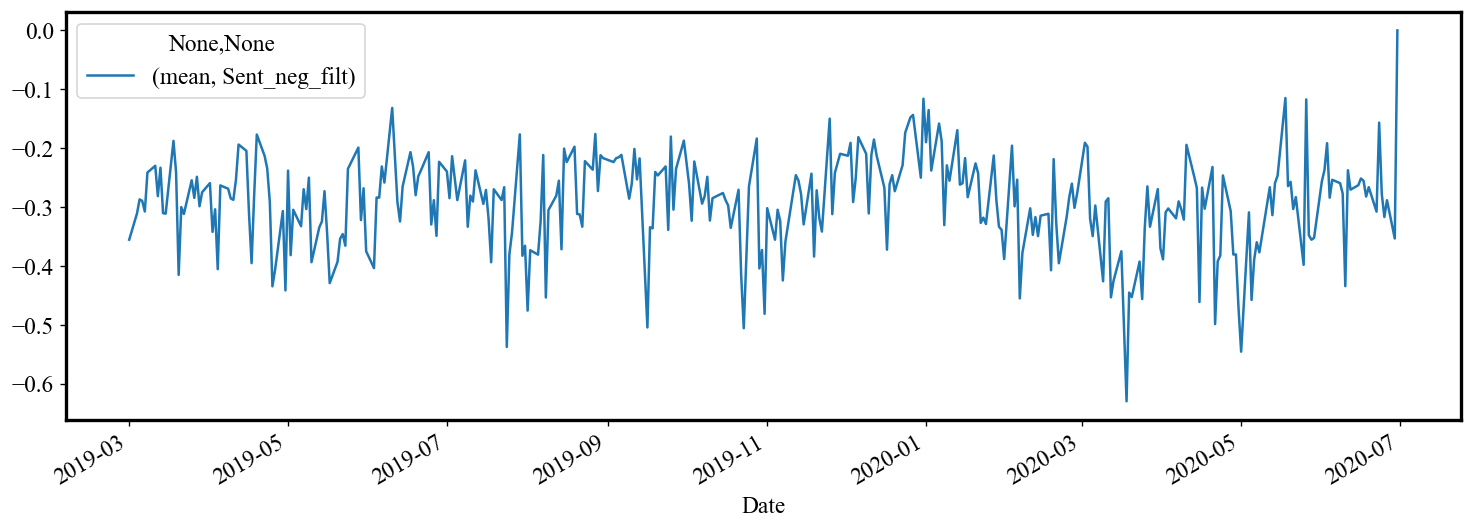

In [59]:
# Show average negative sentiment per day
df_daily_avg_sent=pd.pivot_table(df_sp500_scores_vis,index=["Date"],\
               values=["Sent_neg_filt"],\
               #values=["Sent_neg"],\
               #values=["Sent_neg_filt","Sent_neg"],\
               aggfunc=[np.mean],fill_value=np.NaN)

df_daily_avg_sent.plot(figsize=(15,5))

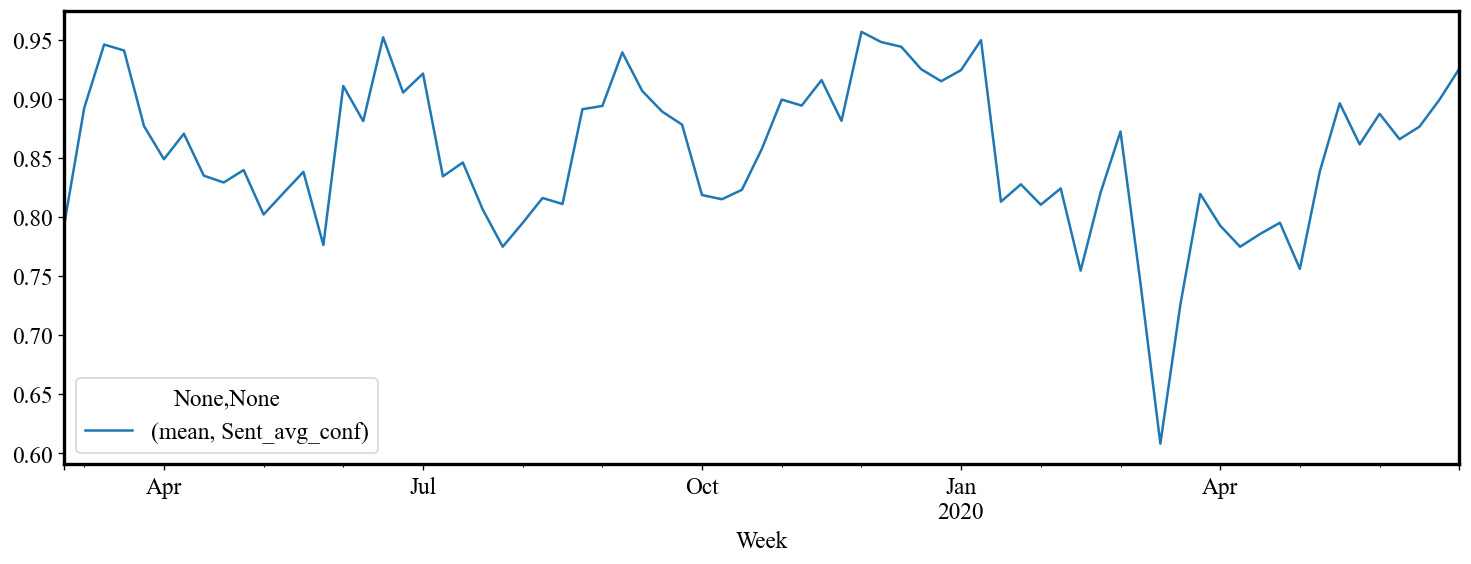

In [60]:
# Show average negative sentiment per day
df_daily_avg_sent=pd.pivot_table(df_sp500_scores_vis,index=["Week"],\
               values=["Sent_avg_conf"],\
              # values=["Sent_avg"],\
               #values=["Sent_neg_filt","Sent_neg"],\
               aggfunc=[np.mean],fill_value=np.NaN)

df_daily_avg_sent.plot(figsize=(15,5))

In [63]:
# Show volume of news per day
df_daily_avg_sent=pd.pivot_table(df_sp500_scores_vis,index=["Date"],\
             values=["News_vol"],\
               #values=["Sent_ratio"],\
              # values=["Sent_ratio","Sent_ratio_filt"],\
               aggfunc=[np.mean],fill_value=np.NaN)

#df_daily_avg_sent.plot(kind="bar",figsize=(15,5))
df_daily_avg_sent

,mean
,News_vol
Date,
2019-03-01 00:00:00+00:00,5.553009
2019-03-04 00:00:00+00:00,5.313316
2019-03-05 00:00:00+00:00,5.622951
2019-03-06 00:00:00+00:00,5.421053
2019-03-07 00:00:00+00:00,5.193906
...,...
2020-06-24 00:00:00+00:00,4.144022
2020-06-25 00:00:00+00:00,5.000000


### Analyse average daily sentiment 

In [79]:
# load average daily media attention decils
df_Quantiles=pd.read_excel("RIC and News Quantiles.xlsx")
df_Quantiles=df_Quantiles.drop_duplicates(subset="Company")
df_Quantiles=df_Quantiles[["Company","News_Quantile"]]
df_Quantiles

,Company,News_Quantile
0,A,"(2.974, 3.219]"
1,AAL.O,"(7.387, 55.775]"
2,AAP,"(2.778, 2.974]"
3,AAPL.O,"(7.387, 55.775]"
4,ABBV.K,"(4.963, 7.387]"
...,...,...
529,YUM,"(3.569, 4.043]"
530,ZBH,"(2.778, 2.974]"
531,ZBRA.O,"(0.999, 2.302]"
532,ZION.O,"(2.533, 2.778]"


In [75]:
df_sp500_scores_vis.columns

Index(['Date', 'RIC', 'Sent_abs', 'Sent_neg', 'Sent_pos', 'Sent_abs_filt',
       'Sent_neg_filt', 'Sent_pos_filt', 'Sent_conf_abs', 'Sent_conf_pos',
       'Sent_conf_neg', 'News_vol', 'Sent_avg', 'Sent_avg_filt',
       'Sent_avg_conf', 'Sent_avg_conf_neg', 'Sent_ratio', 'Sent_ratio_filt',
       'Sent_ratio_conf', 'weeknum', 'year', 'Week_display', 'Week', 'ISO',
       'Month'],
      dtype='object')

In [76]:
# join percentiles 
df_sp500_scores_vis_inc_dec=df_sp500_scores_vis.merge(df_Quantiles,how="left",left_on="RIC",right_on="Company")

df_sp500_scores_vis_inc_dec.head()

,Date,RIC,Sent_abs,Sent_neg,Sent_pos,Sent_abs_filt,Sent_neg_filt,Sent_pos_filt,Sent_conf_abs,Sent_conf_pos,...,Sent_ratio_filt,Sent_ratio_conf,weeknum,year,Week_display,Week,ISO,Month,Company,News_Quantile
0,2019-03-01 00:00:00+00:00,A,2,0,2,2,0,2,4.847166,4.847166,...,1.098612,1.765957,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03,A,"(2.974, 3.219]"
1,2019-03-01 00:00:00+00:00,NRG,3,0,3,3,0,3,3.420256,3.420256,...,1.386294,1.486198,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03,NRG,"(2.302, 2.533]"
2,2019-03-01 00:00:00+00:00,NOV,1,0,1,1,0,1,2.655401,2.655401,...,0.693147,1.296206,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03,NOV,"(2.302, 2.533]"
3,2019-03-01 00:00:00+00:00,NOC,1,0,1,0,0,0,0.926428,0.926428,...,0.000000,0.655667,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03,NOC,"(4.043, 4.963]"
4,2019-03-01 00:00:00+00:00,NLSN.K,1,-1,2,1,0,1,1.757204,2.301808,...,0.693147,0.759702,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03,NLSN.K,"(2.974, 3.219]"


In [81]:
# Show average sentiment stats
df_sp500_scores_vis_inc_dec_piv=pd.pivot_table(df_sp500_scores_vis_inc_dec,index=["News_Quantile"],\
               values=["Sent_avg_conf"],\
               aggfunc=[np.mean, "median","max","std","skew"],fill_value=np.NaN)
df_sp500_scores_vis_inc_dec_piv.sort_index()

,mean,median,max,std,skew
,Sent_avg_conf,Sent_avg_conf,Sent_avg_conf,Sent_avg_conf,Sent_avg_conf
News_Quantile,,,,,
"(0.999, 2.302]",0.926466,0.932321,4.872793,0.719261,-0.320794
"(2.302, 2.533]",0.983586,0.966975,5.136273,0.750064,-0.037588
"(2.533, 2.778]",0.932367,0.932321,5.261132,0.809916,0.149464
"(2.778, 2.974]",0.903155,0.924398,6.680911,0.825344,0.155141
"(2.974, 3.219]",0.920235,0.932321,5.094904,0.797696,0.006456
"(3.219, 3.569]",0.882413,0.932321,4.928485,0.797696,-0.176071
"(3.569, 4.043]",0.854737,0.921197,5.710679,0.813748,-0.287734
"(4.043, 4.963]",0.818229,0.875729,4.317619,0.761065,-0.369005


In [82]:
df_sp500_scores_vis_inc_dec_piv.to_excel("Average daily sentiment by decil of media coverage.xlsx")

### Analyse industries

In [86]:
# load industries
df_Industry=pd.read_excel("RIC and Industry Sector 2.xlsx")
df_Industry=df_Industry.drop_duplicates(subset="RIC")
#df_Industry=df_Industry[["Company","News_Quantile"]]
df_Industry

,RIC,ICB Sector
0,A,Health Care
1,NRG,Utilities
2,NOV,Energy
3,NOC,Industrials
4,NLSN.K,Consumer Discretion
...,...,...
530,DPZ,Consumer Discretion
531,WST,Health Care
532,TYL,Technology
533,BIO,Health Care


In [87]:
df_sp500_scores_vis.head()

,Date,RIC,Sent_abs,Sent_neg,Sent_pos,Sent_abs_filt,Sent_neg_filt,Sent_pos_filt,Sent_conf_abs,Sent_conf_pos,...,Sent_avg_conf_neg,Sent_ratio,Sent_ratio_filt,Sent_ratio_conf,weeknum,year,Week_display,Week,ISO,Month
0,2019-03-01 00:00:00+00:00,A,2,0,2,2,0,2,4.847166,4.847166,...,0.000000,1.098612,1.098612,1.765957,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03
237,2019-03-01 00:00:00+00:00,NRG,3,0,3,3,0,3,3.420256,3.420256,...,0.000000,1.386294,1.386294,1.486198,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03
236,2019-03-01 00:00:00+00:00,NOV,1,0,1,1,0,1,2.655401,2.655401,...,0.000000,0.693147,0.693147,1.296206,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03
235,2019-03-01 00:00:00+00:00,NOC,1,0,1,0,0,0,0.926428,0.926428,...,0.000000,0.693147,0.000000,0.655667,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03
234,2019-03-01 00:00:00+00:00,NLSN.K,1,-1,2,1,0,1,1.757204,2.301808,...,-0.181535,0.405465,0.693147,0.759702,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03


In [88]:
# join industries 
df_sp500_scores_vis_inc_ind=df_sp500_scores_vis.merge(df_Industry,how="left",left_on="RIC",right_on="RIC")

df_sp500_scores_vis_inc_ind.head()

,Date,RIC,Sent_abs,Sent_neg,Sent_pos,Sent_abs_filt,Sent_neg_filt,Sent_pos_filt,Sent_conf_abs,Sent_conf_pos,...,Sent_ratio,Sent_ratio_filt,Sent_ratio_conf,weeknum,year,Week_display,Week,ISO,Month,ICB Sector
0,2019-03-01 00:00:00+00:00,A,2,0,2,2,0,2,4.847166,4.847166,...,1.098612,1.098612,1.765957,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03,Health Care
1,2019-03-01 00:00:00+00:00,NRG,3,0,3,3,0,3,3.420256,3.420256,...,1.386294,1.386294,1.486198,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03,Utilities
2,2019-03-01 00:00:00+00:00,NOV,1,0,1,1,0,1,2.655401,2.655401,...,0.693147,0.693147,1.296206,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03,Energy
3,2019-03-01 00:00:00+00:00,NOC,1,0,1,0,0,0,0.926428,0.926428,...,0.693147,0.000000,0.655667,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03,Industrials
4,2019-03-01 00:00:00+00:00,NLSN.K,1,-1,2,1,0,1,1.757204,2.301808,...,0.405465,0.693147,0.759702,9,2019,2019-9,2019-02-25,2019-W9-1,2019-03,Consumer Discretion


In [93]:
# Show average sentiment per week
df_sp500_scores_vis_inc_ind_piv=pd.pivot_table(df_sp500_scores_vis_inc_ind,index=["ICB Sector"],\
               values=["Sent_avg_conf"],\
               aggfunc=[np.mean, "median","max","std","skew"],fill_value=np.NaN)
#df_sp500_scores_vis_inc_ind_piv.sort_values()

In [90]:
df_sp500_scores_vis_inc_ind_piv.to_excel("Average daily sentiment by industry.xlsx")